In [1]:
from __future__ import print_function
import time, os, json
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM


from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


# Build Model

load small datasets for testing

In [2]:
data = load_coco_data(pca_features = False, max_train=20000)
input_size = data['train_features'].shape[1]
maxLen = data['train_captions'].shape[1]
wordLs = []
for caption in data['train_captions']:
    for word in caption:
        wordLs.append(word)
voc_size = len(list(set(wordLs)))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
print('\ninput_size:', input_size, ' maxLen:', maxLen, ' voc_size:', voc_size)
print('Finish loading training data!')

idx_to_word <class 'list'> 1004
train_image_idxs <class 'numpy.ndarray'> (20000,) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
train_captions <class 'numpy.ndarray'> (20000, 17) int32
word_to_idx <class 'dict'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_features <class 'numpy.ndarray'> (40504, 4096) float32

input_size: 4096  maxLen: 17  voc_size: 1004
Finish loading training data!


In [3]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2index = {}
index2word = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2index[word] = i
    index2word[i] = word
print('finish building dictionary')

finish building dictionary


build model

In [4]:
# define parameters
num_frames = 1
batch_size = 512
epochs = 200
learning_rate = 1e-5
word_vector_size = 50
LSTM_output_size = 100
LSTM_hidden_size = 100

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", LSTM_hidden_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", learning_rate, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", input_size, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", batch_size, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", maxLen, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_vector_size, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", voc_size, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", epochs, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", num_frames, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", LSTM_output_size, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS  

In [5]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

is_training = True



captions_train = []
captions_corresponding_videoIds = []
input_frames_train = {}

captions_corresponding_videoIds = data['train_image_idxs']
for i, ind in enumerate(data['train_image_idxs']):
    caption = data['train_captions'][i]
    caption_new = []
    for word_ind in caption:
        word = index2Word_ori[word_ind]
        caption_new.append( word2index[word] )
        
    captions_train.append( (ind, list(caption_new) ) )
    input_frames_train[ind] = data['train_features'][ind].reshape(1, input_size)

word_embedding = np.random.randn(voc_size, word_vector_size).astype(np.float32)

In [6]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
total number of parameter 1880604


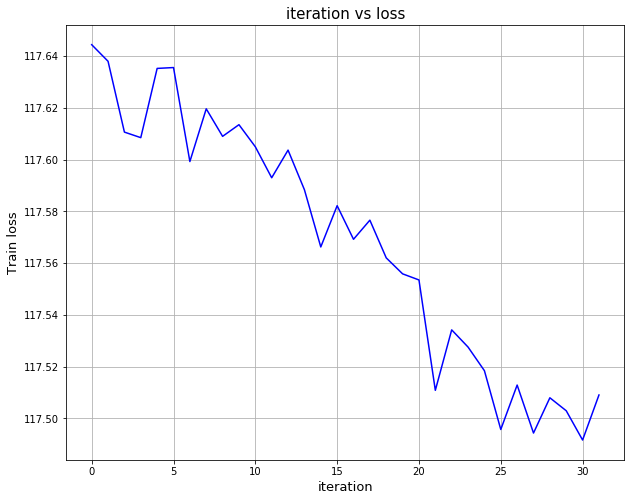

  1/200 [..............................] - ETA: 1196s - train loss: 117.5680 - dev loss: 117.4609

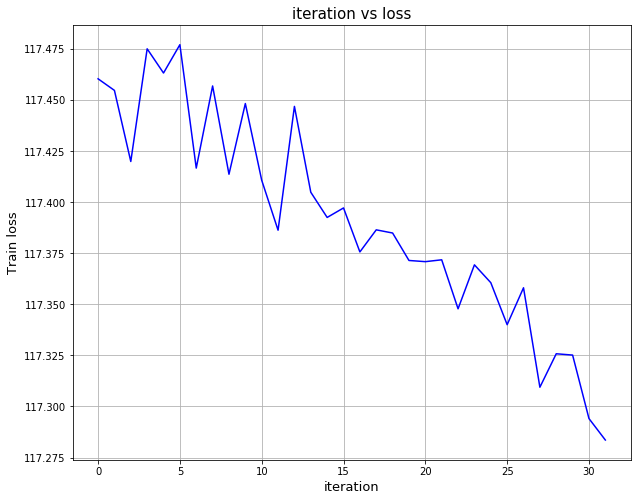

  2/200 [..............................] - ETA: 1124s - train loss: 117.3907 - dev loss: 117.3897

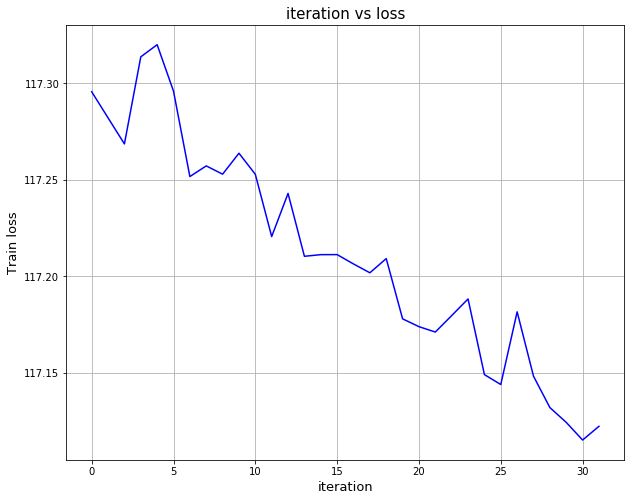

  3/200 [..............................] - ETA: 1095s - train loss: 117.2118 - dev loss: 117.3041

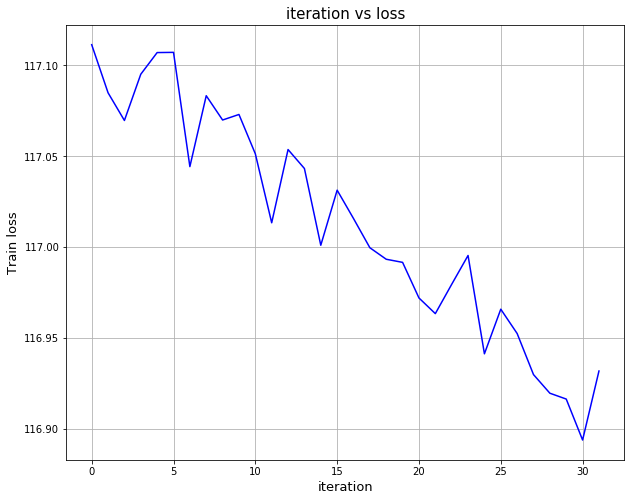

  4/200 [..............................] - ETA: 1077s - train loss: 117.0125 - dev loss: 117.1871

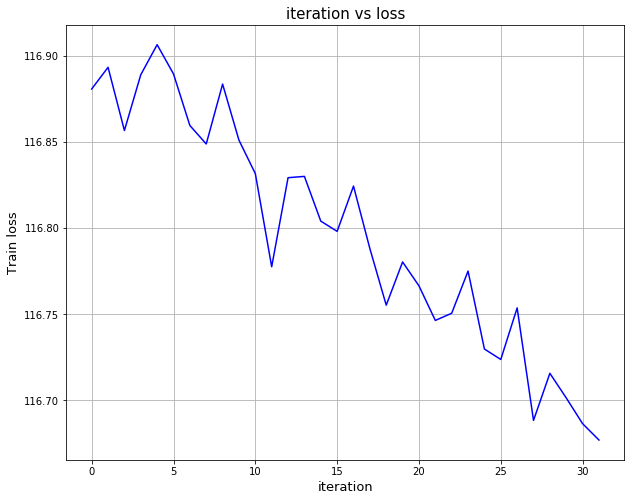

  5/200 [..............................] - ETA: 1063s - train loss: 116.7967 - dev loss: 117.0532

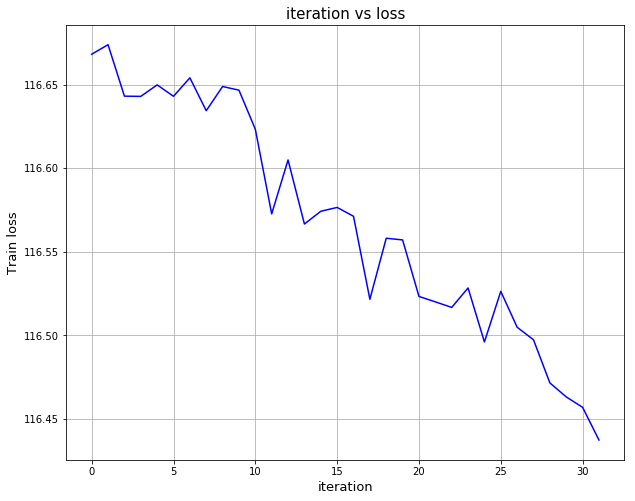

  6/200 [..............................] - ETA: 1052s - train loss: 116.5679 - dev loss: 116.9356

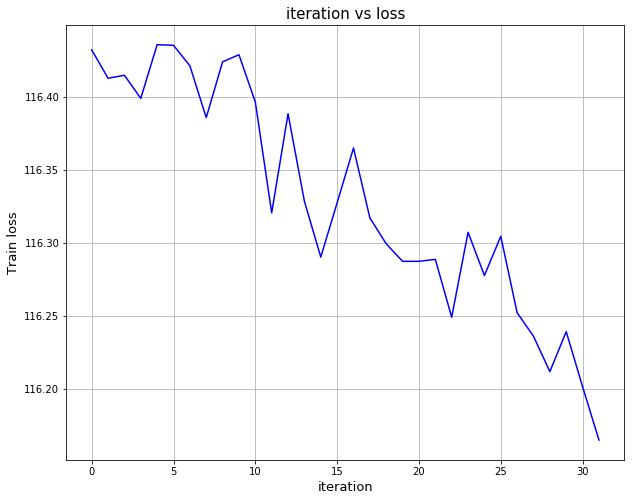

  7/200 [>.............................] - ETA: 1044s - train loss: 116.3291 - dev loss: 116.7711

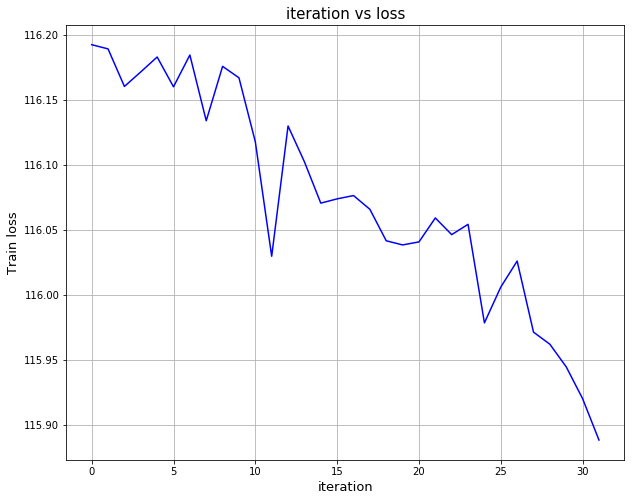

  8/200 [>.............................] - ETA: 1036s - train loss: 116.0737 - dev loss: 116.4553

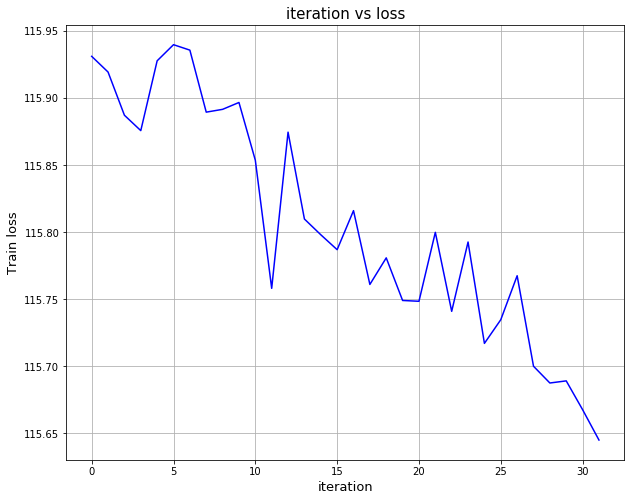

  9/200 [>.............................] - ETA: 1029s - train loss: 115.8055 - dev loss: 115.8666

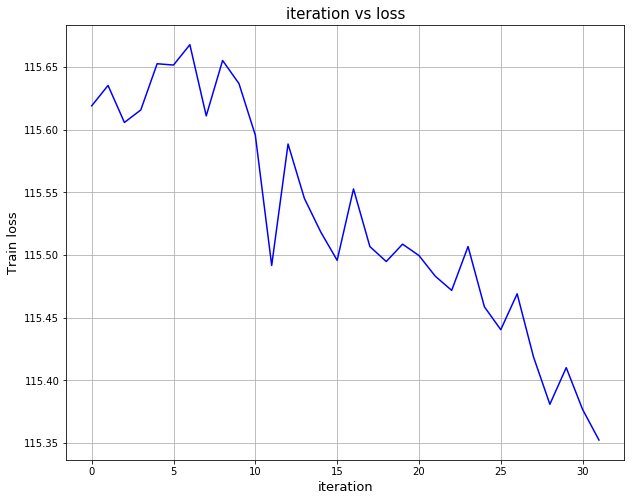

 10/200 [>.............................] - ETA: 1023s - train loss: 115.5286 - dev loss: 115.1168

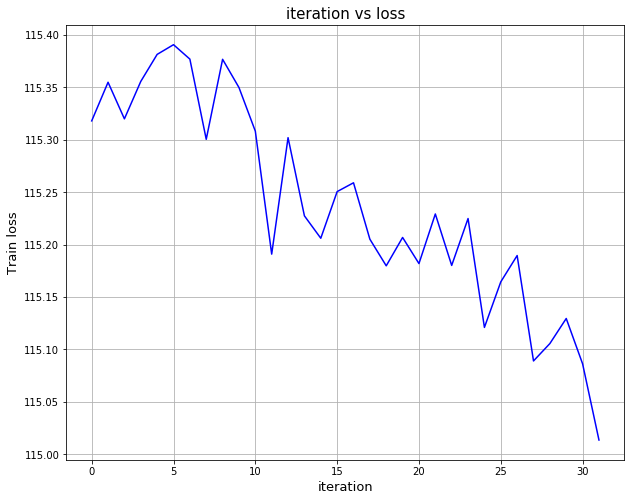

 11/200 [>.............................] - ETA: 1017s - train loss: 115.2368 - dev loss: 114.5409

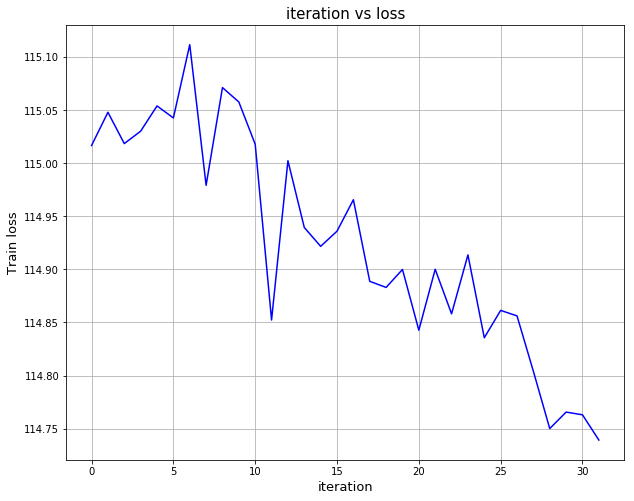

 12/200 [>.............................] - ETA: 1011s - train loss: 114.9258 - dev loss: 114.1360

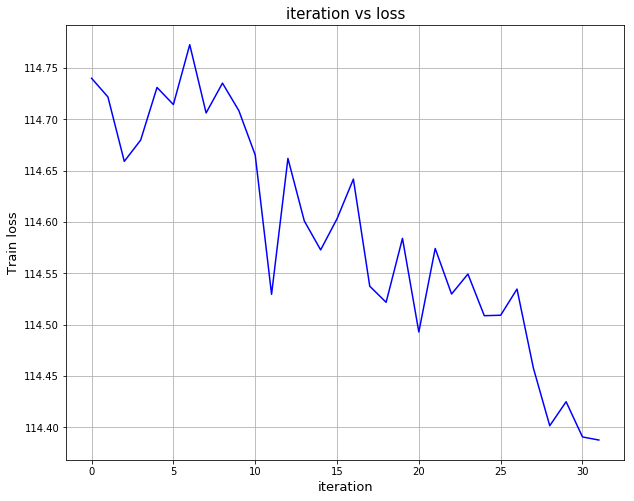

 13/200 [>.............................] - ETA: 1004s - train loss: 114.5892 - dev loss: 113.7359

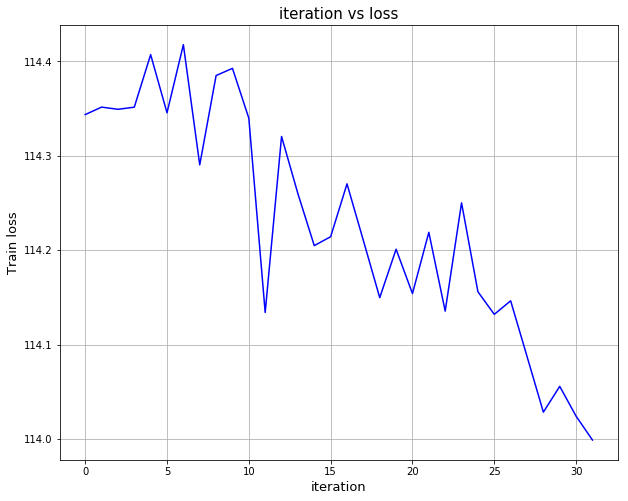

 14/200 [=>............................] - ETA: 998s - train loss: 114.2290 - dev loss: 113.3312 

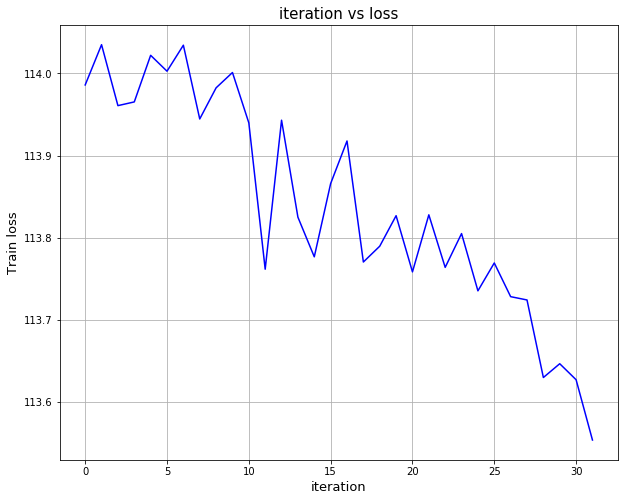

 15/200 [=>............................] - ETA: 991s - train loss: 113.8413 - dev loss: 112.9117

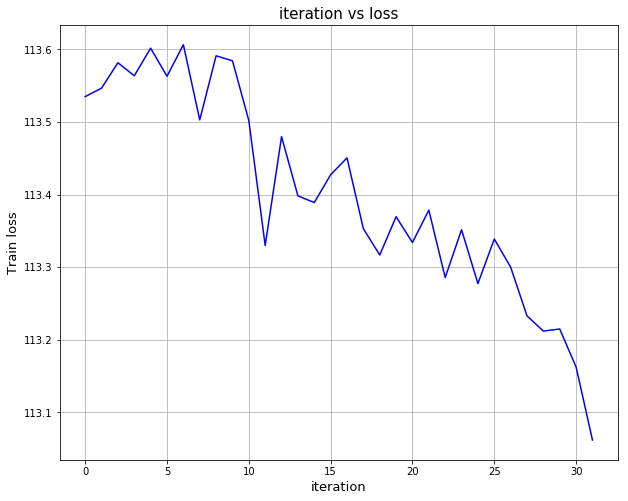

 16/200 [=>............................] - ETA: 987s - train loss: 113.4013 - dev loss: 112.4648

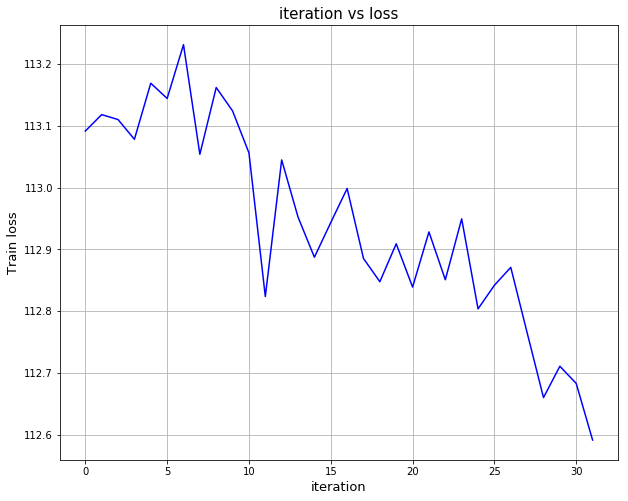

 17/200 [=>............................] - ETA: 981s - train loss: 112.9415 - dev loss: 111.9773

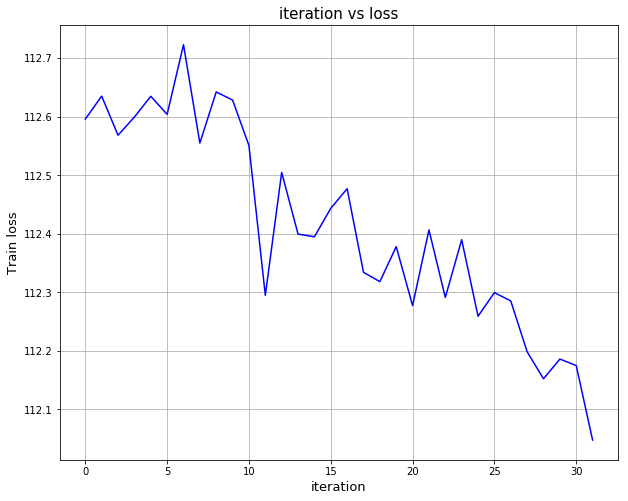

 18/200 [=>............................] - ETA: 975s - train loss: 112.4141 - dev loss: 111.4042

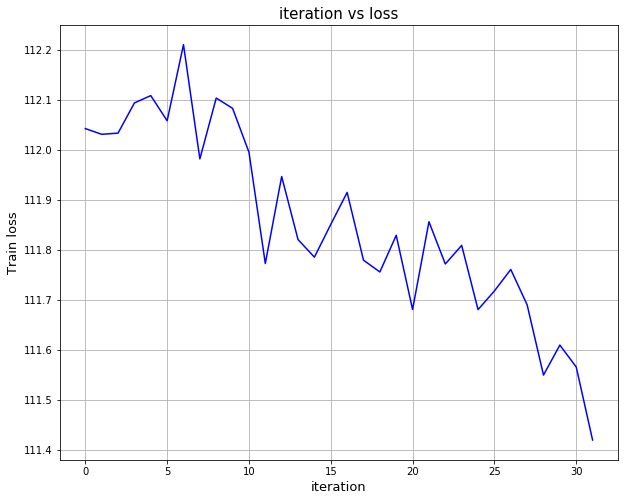

 19/200 [=>............................] - ETA: 969s - train loss: 111.8532 - dev loss: 110.7959

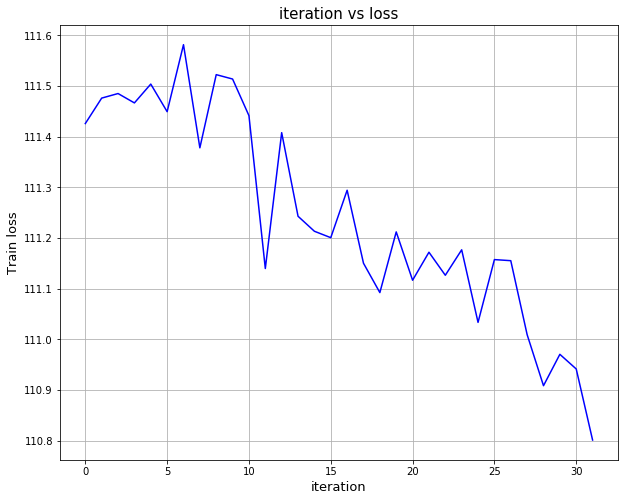

 20/200 [==>...........................] - ETA: 963s - train loss: 111.2426 - dev loss: 110.1677

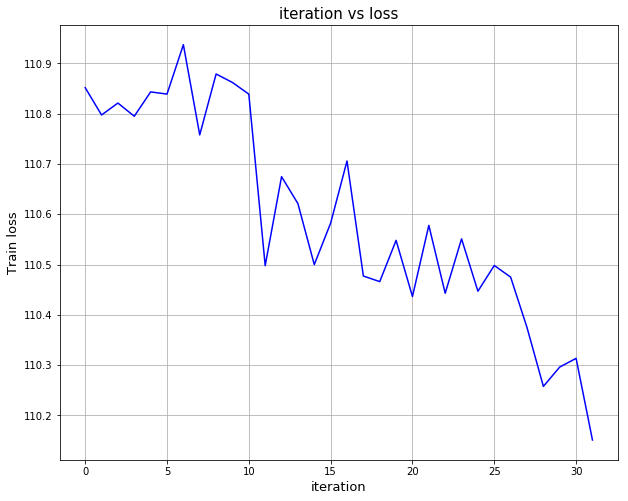

 21/200 [==>...........................] - ETA: 957s - train loss: 110.5973 - dev loss: 109.5090

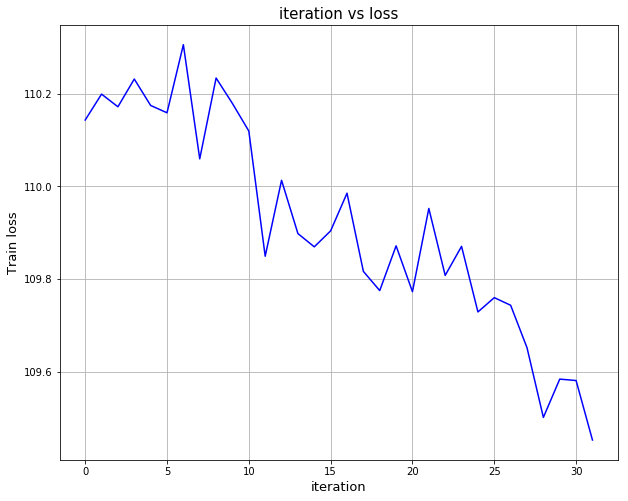

 22/200 [==>...........................] - ETA: 951s - train loss: 109.9179 - dev loss: 108.8261

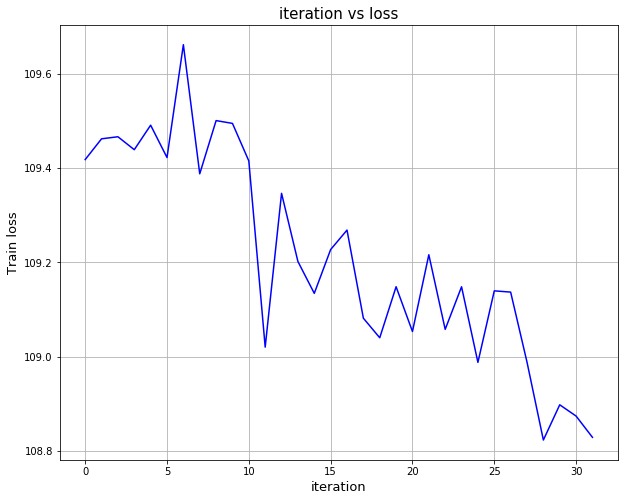

 23/200 [==>...........................] - ETA: 945s - train loss: 109.2120 - dev loss: 108.1045

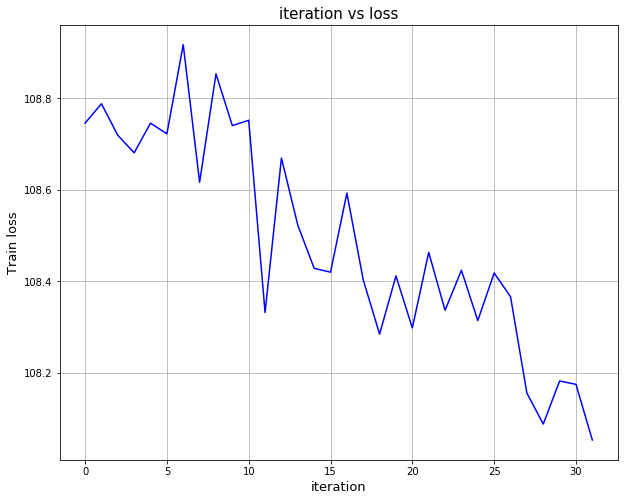

 24/200 [==>...........................] - ETA: 939s - train loss: 108.4881 - dev loss: 107.3447

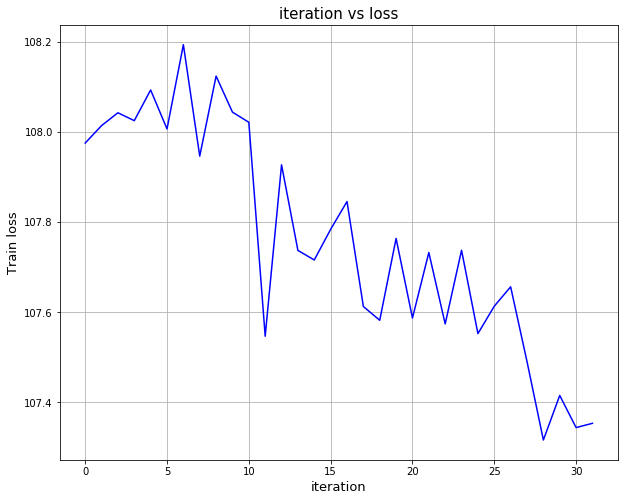

 25/200 [==>...........................] - ETA: 933s - train loss: 107.7617 - dev loss: 106.6204

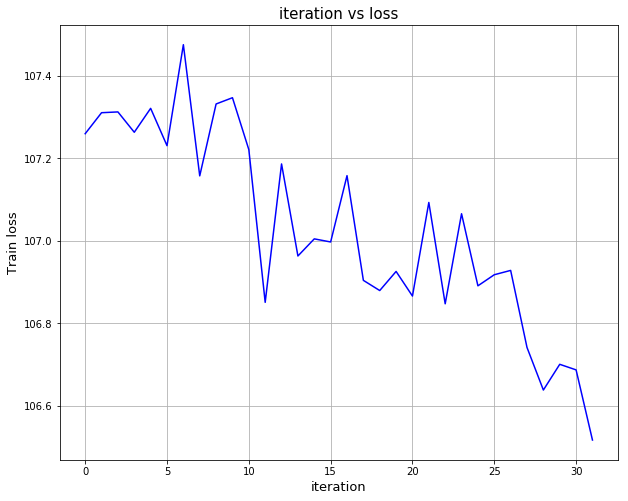

 26/200 [==>...........................] - ETA: 928s - train loss: 107.0313 - dev loss: 105.8950

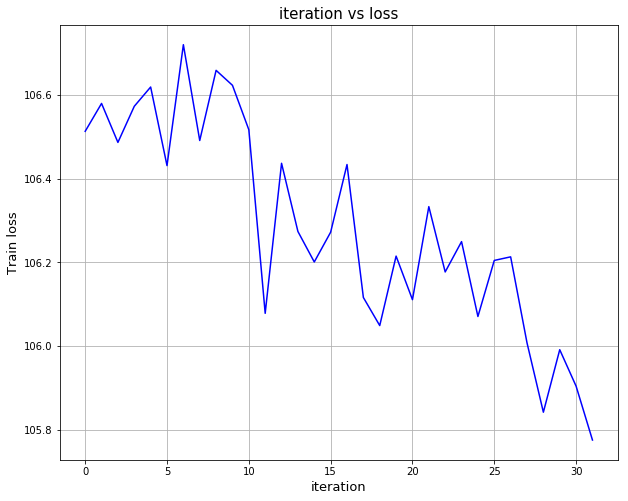

 27/200 [===>..........................] - ETA: 922s - train loss: 106.2866 - dev loss: 105.1733

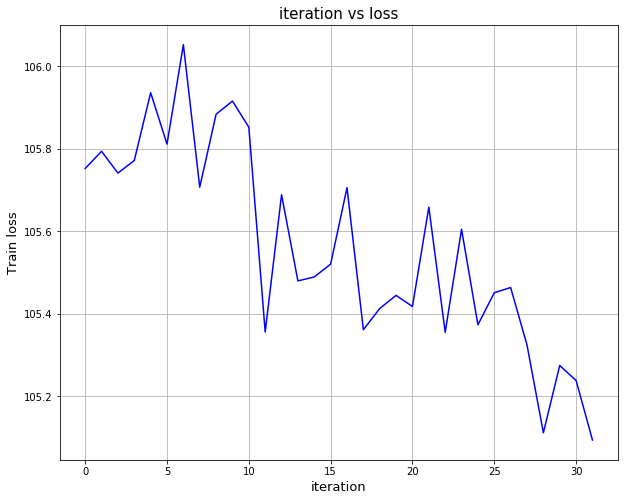

 28/200 [===>..........................] - ETA: 916s - train loss: 105.5640 - dev loss: 104.4796

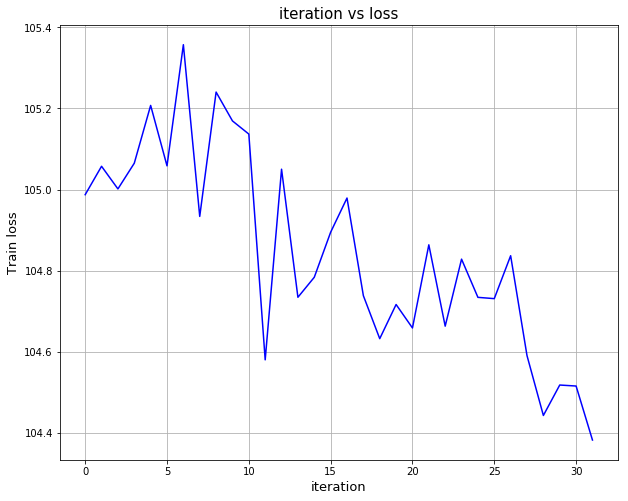

 29/200 [===>..........................] - ETA: 911s - train loss: 104.8468 - dev loss: 103.8784

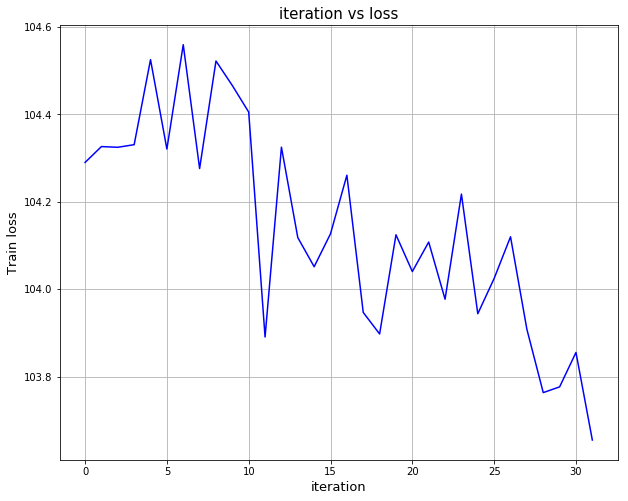

 30/200 [===>..........................] - ETA: 905s - train loss: 104.1400 - dev loss: 103.5988

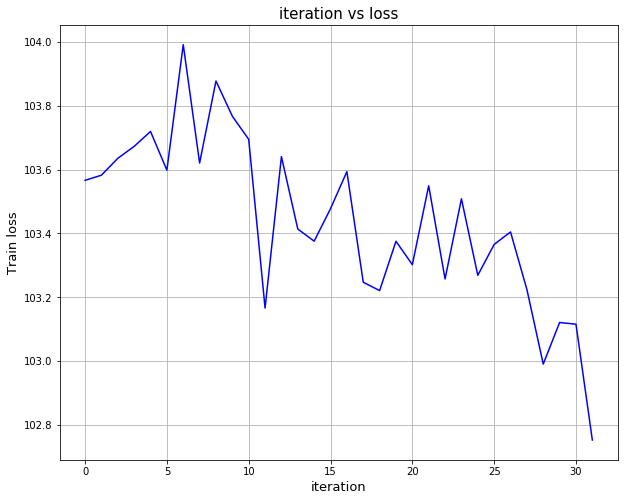

 31/200 [===>..........................] - ETA: 900s - train loss: 103.4408 - dev loss: 103.0189

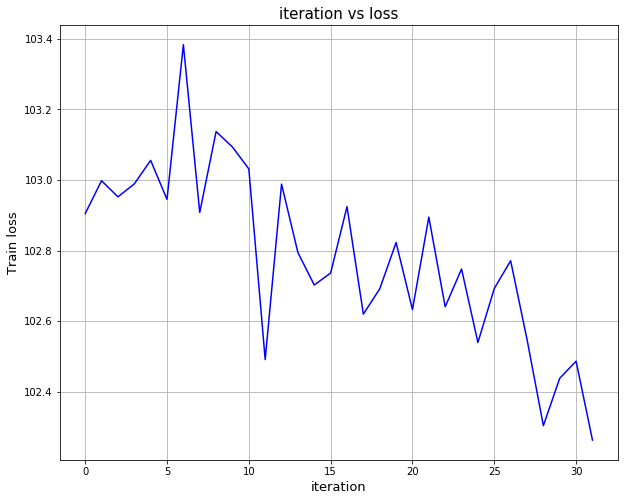

 32/200 [===>..........................] - ETA: 895s - train loss: 102.7851 - dev loss: 102.3798

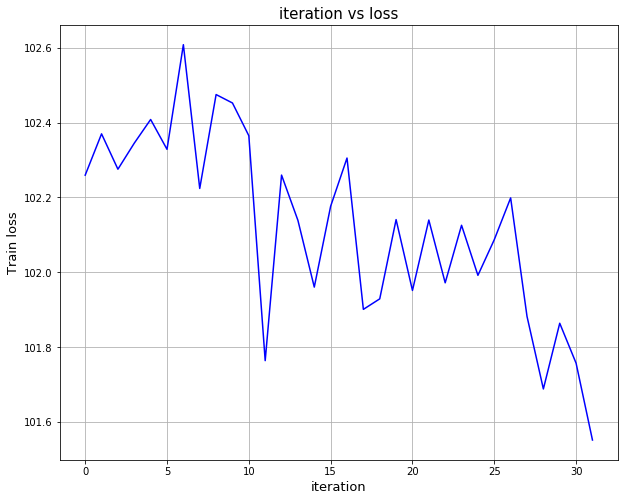

 33/200 [===>..........................] - ETA: 889s - train loss: 102.1219 - dev loss: 101.7356

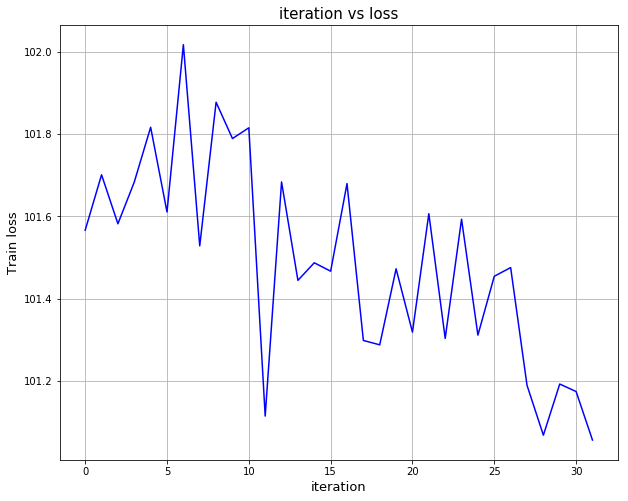

 34/200 [====>.........................] - ETA: 883s - train loss: 101.4898 - dev loss: 101.0950

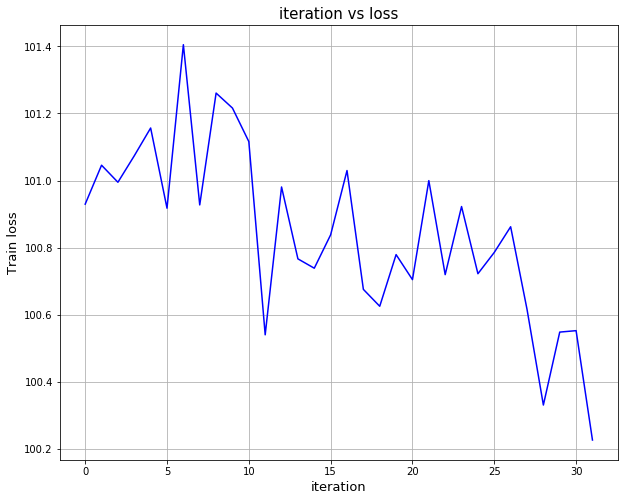

 35/200 [====>.........................] - ETA: 878s - train loss: 100.8440 - dev loss: 100.4486

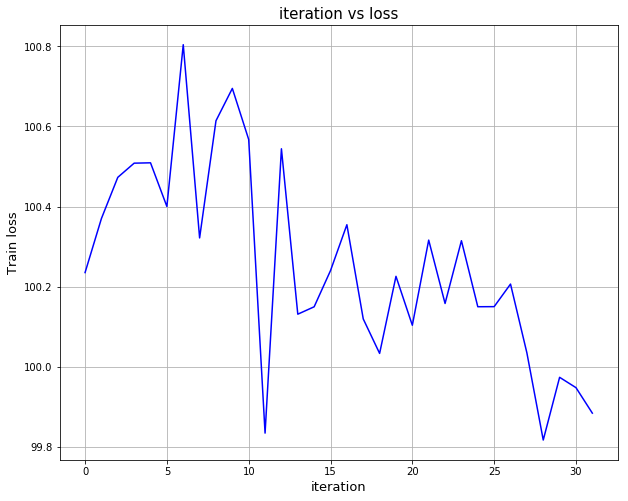

 36/200 [====>.........................] - ETA: 872s - train loss: 100.2559 - dev loss: 99.7459 

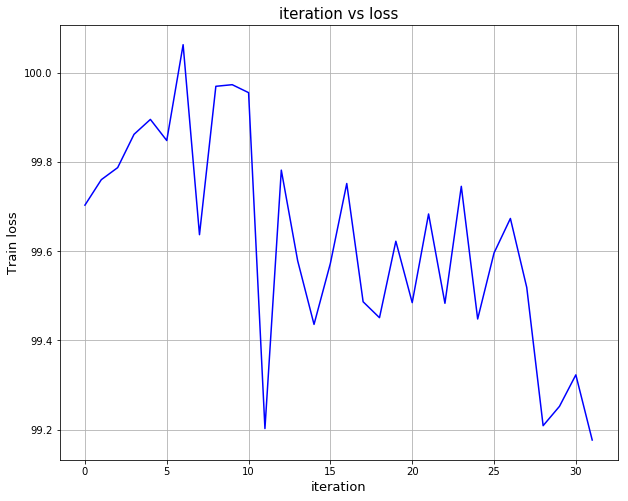

 37/200 [====>.........................] - ETA: 867s - train loss: 99.6231 - dev loss: 99.1333 

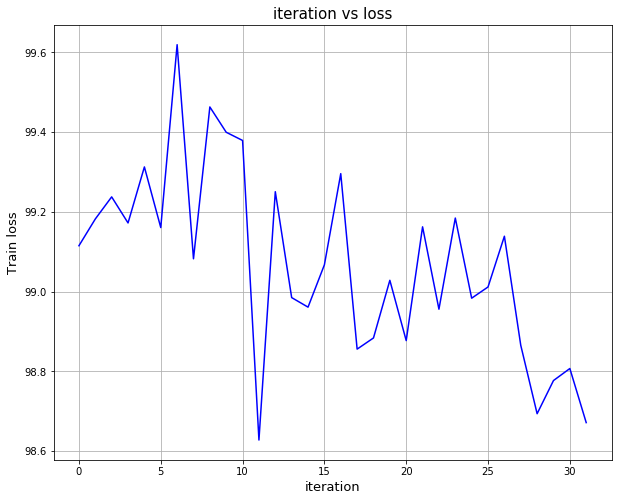

 38/200 [====>.........................] - ETA: 862s - train loss: 99.0689 - dev loss: 98.5510

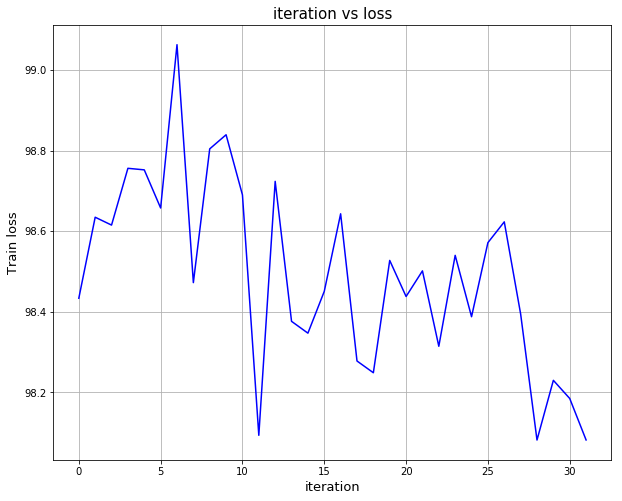

 39/200 [====>.........................] - ETA: 857s - train loss: 98.4923 - dev loss: 97.9795

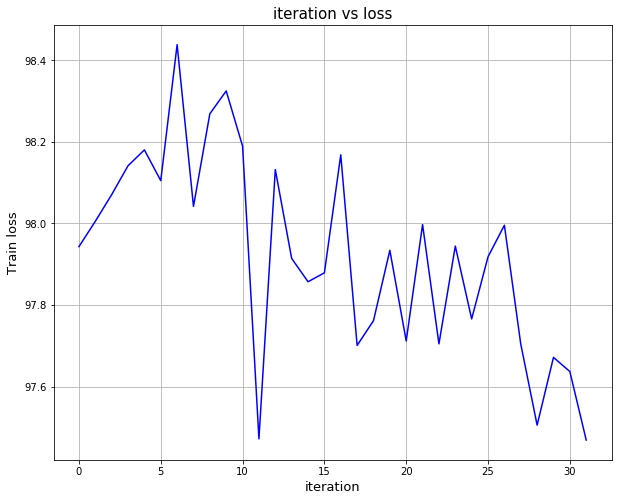

 40/200 [=====>........................] - ETA: 851s - train loss: 97.9236 - dev loss: 97.4180

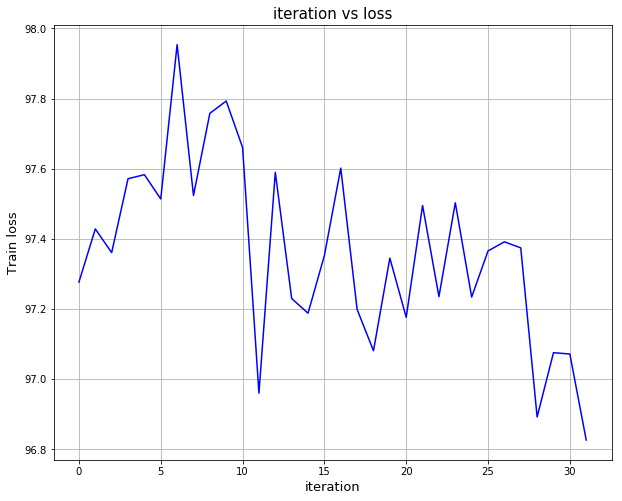

 41/200 [=====>........................] - ETA: 846s - train loss: 97.3629 - dev loss: 96.8657

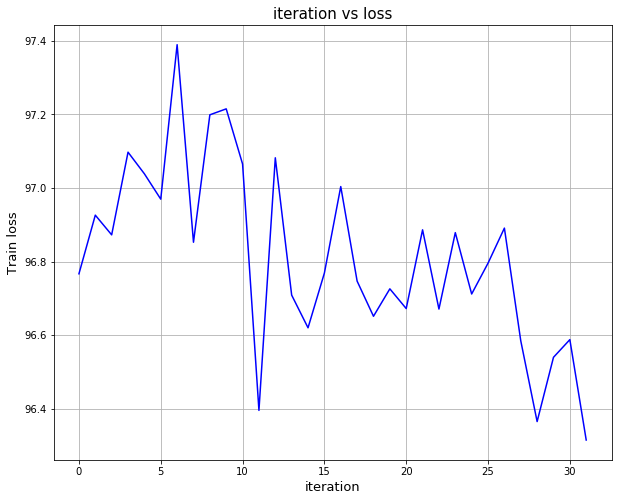

 42/200 [=====>........................] - ETA: 840s - train loss: 96.8124 - dev loss: 96.0155

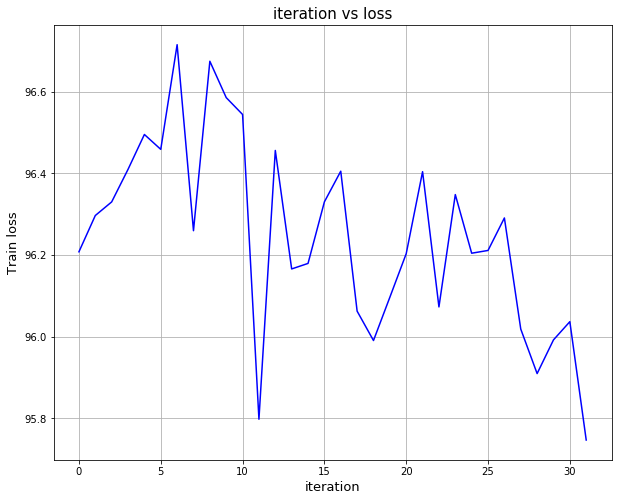

 43/200 [=====>........................] - ETA: 835s - train loss: 96.2468 - dev loss: 95.4663

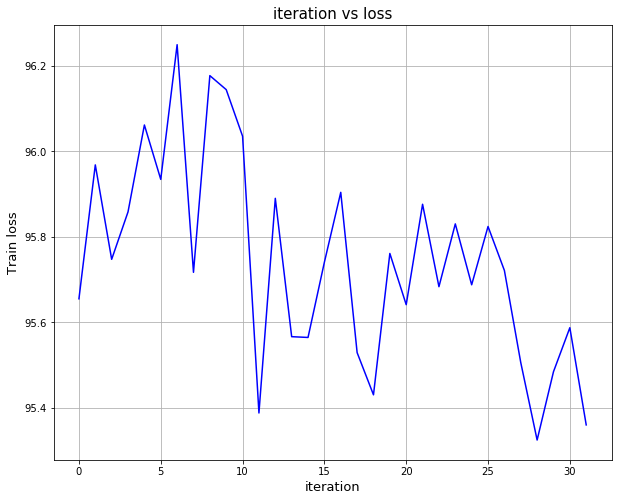

 44/200 [=====>........................] - ETA: 829s - train loss: 95.7453 - dev loss: 94.9415

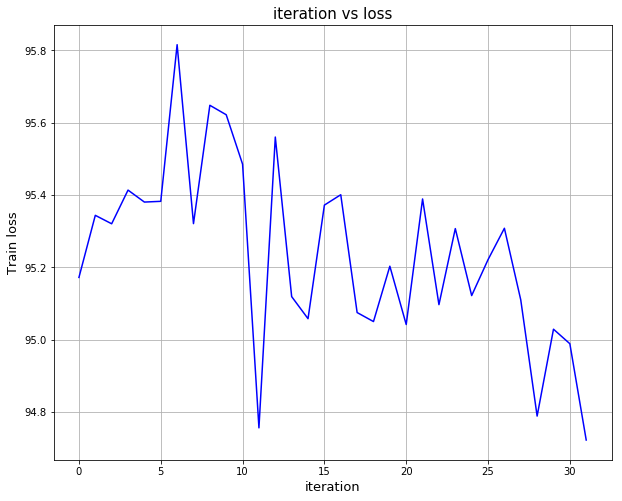

 45/200 [=====>........................] - ETA: 824s - train loss: 95.2384 - dev loss: 94.4250

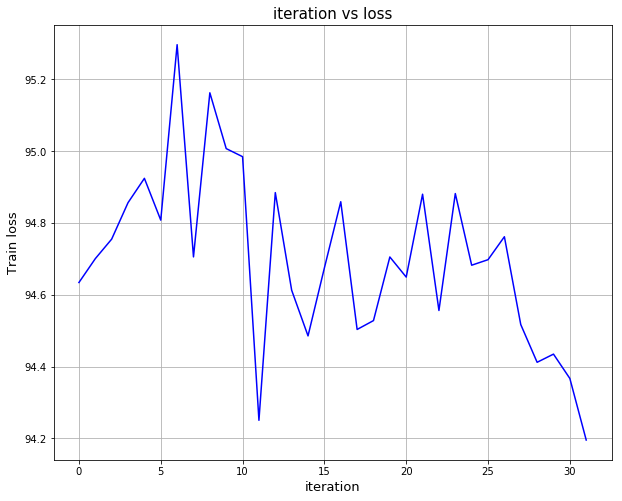

 46/200 [=====>........................] - ETA: 819s - train loss: 94.6993 - dev loss: 93.9153

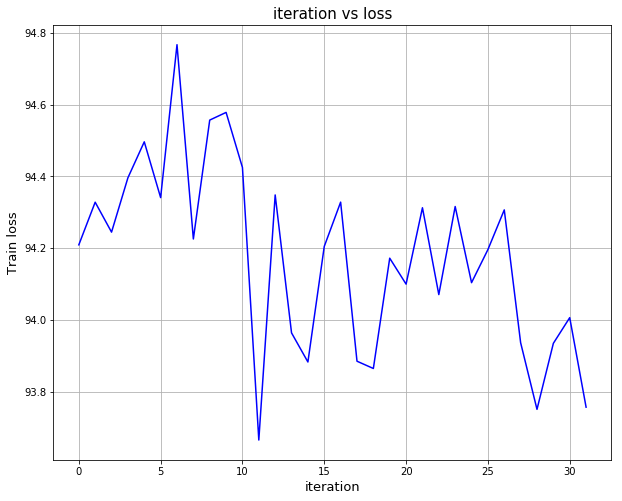

 47/200 [======>.......................] - ETA: 813s - train loss: 94.1774 - dev loss: 93.4122

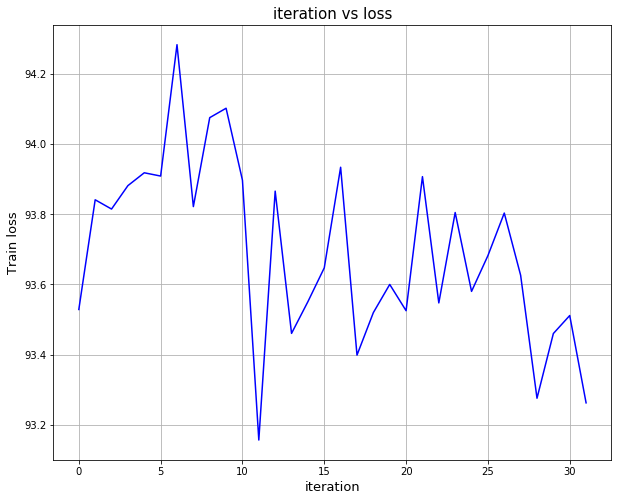

 48/200 [======>.......................] - ETA: 808s - train loss: 93.6936 - dev loss: 92.8517

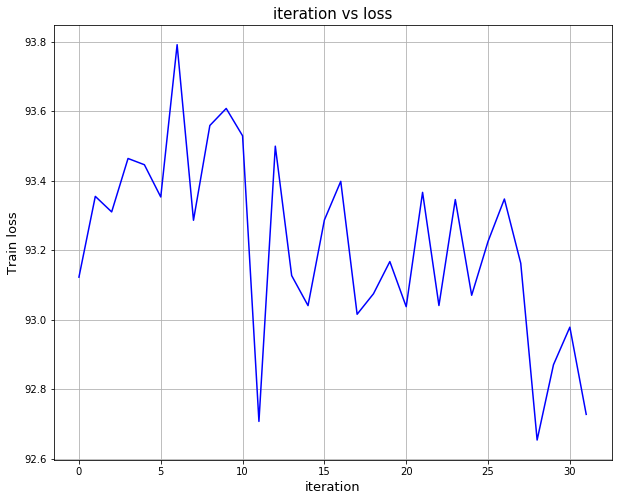

 49/200 [======>.......................] - ETA: 802s - train loss: 93.2175 - dev loss: 92.3599

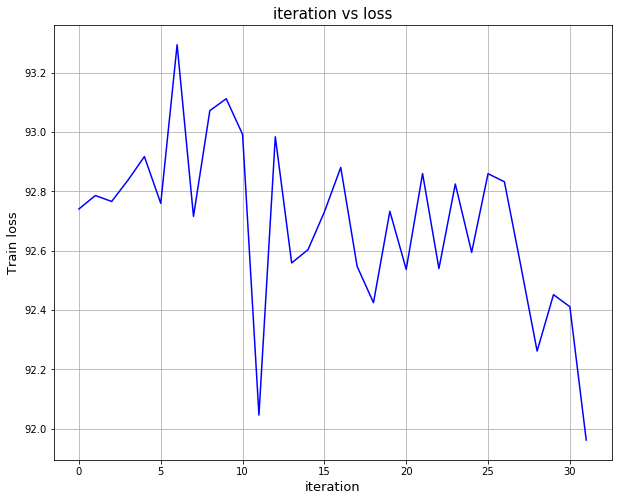

 50/200 [======>.......................] - ETA: 797s - train loss: 92.6931 - dev loss: 91.8761

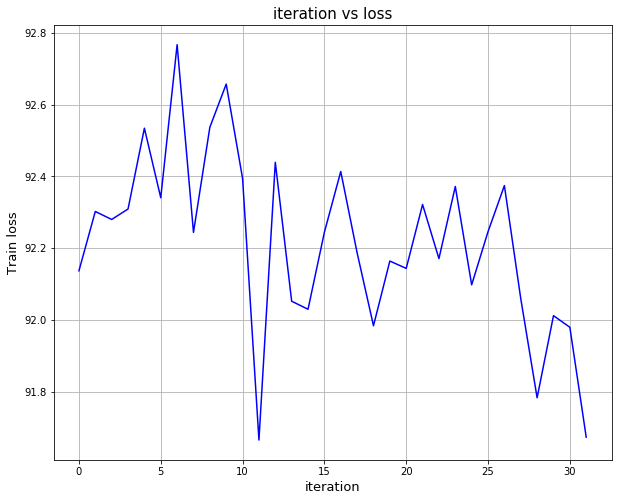

 51/200 [======>.......................] - ETA: 791s - train loss: 92.2157 - dev loss: 91.3983

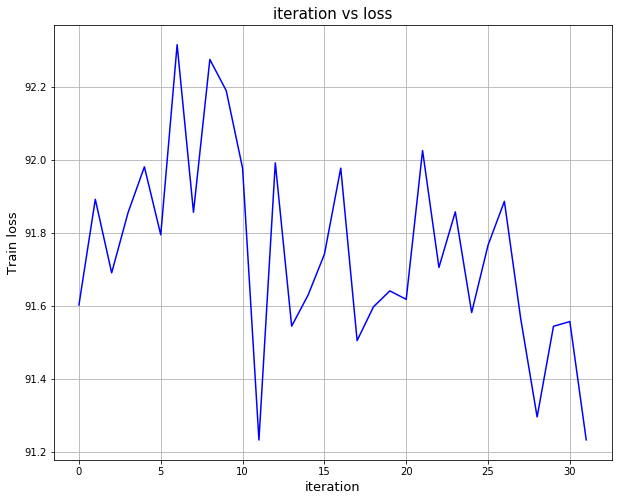

 52/200 [======>.......................] - ETA: 786s - train loss: 91.7473 - dev loss: 90.9266

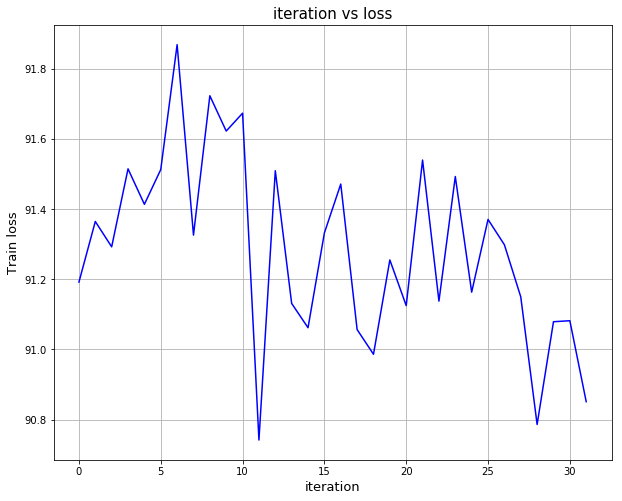

 53/200 [======>.......................] - ETA: 781s - train loss: 91.2855 - dev loss: 90.4600

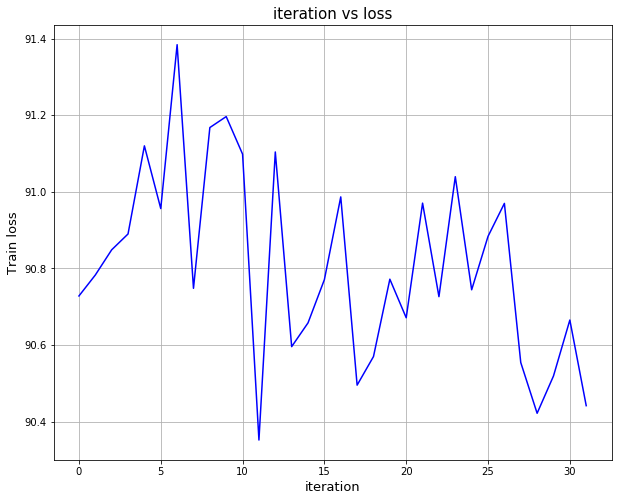

 54/200 [=======>......................] - ETA: 775s - train loss: 90.8073 - dev loss: 89.9995

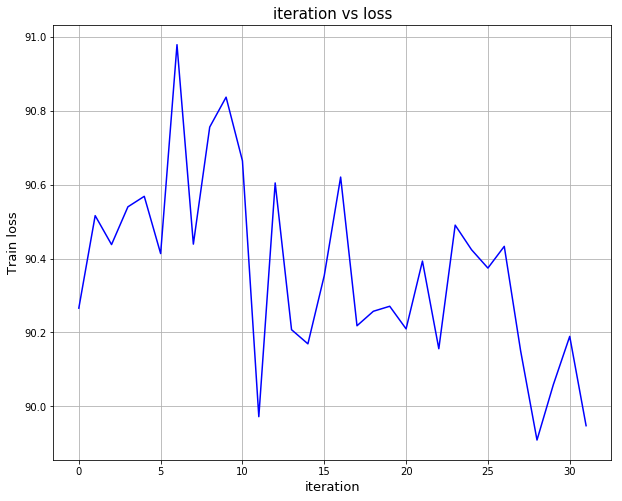

 55/200 [=======>......................] - ETA: 770s - train loss: 90.3695 - dev loss: 89.5449

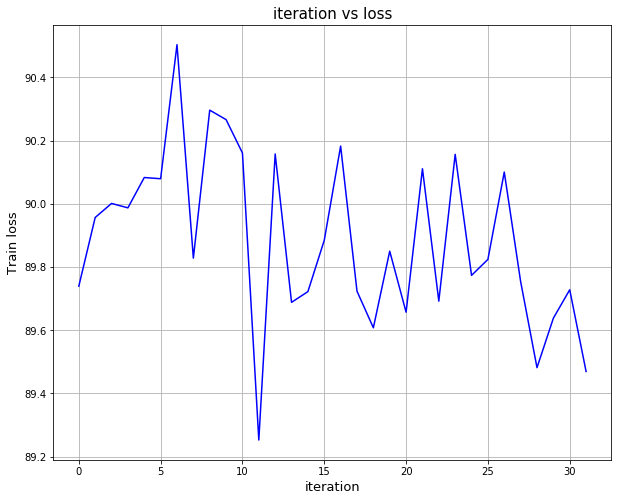

 56/200 [=======>......................] - ETA: 765s - train loss: 89.8861 - dev loss: 89.0962

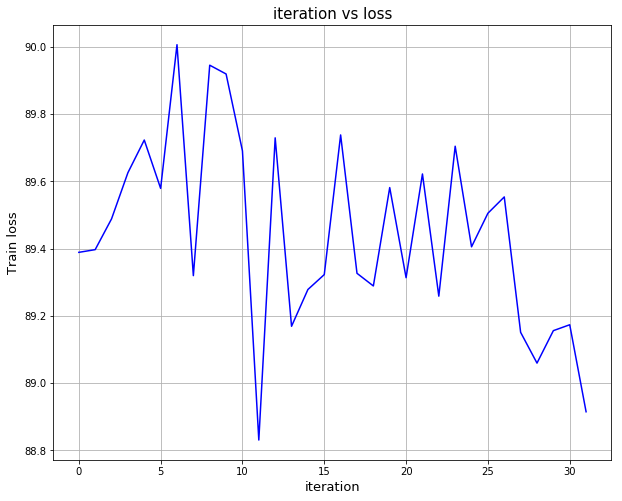

 57/200 [=======>......................] - ETA: 759s - train loss: 89.4427 - dev loss: 88.6518

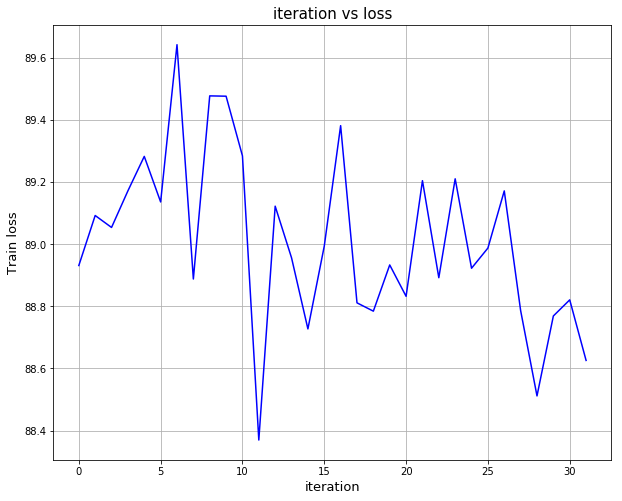

 58/200 [=======>......................] - ETA: 755s - train loss: 89.0080 - dev loss: 88.2138

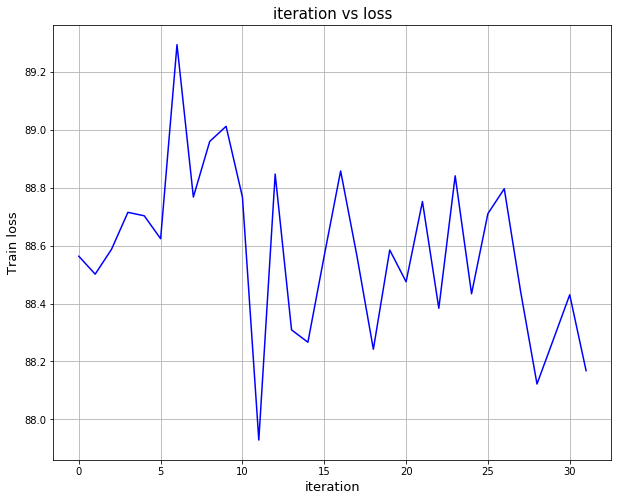

 59/200 [=======>......................] - ETA: 749s - train loss: 88.5778 - dev loss: 87.7803

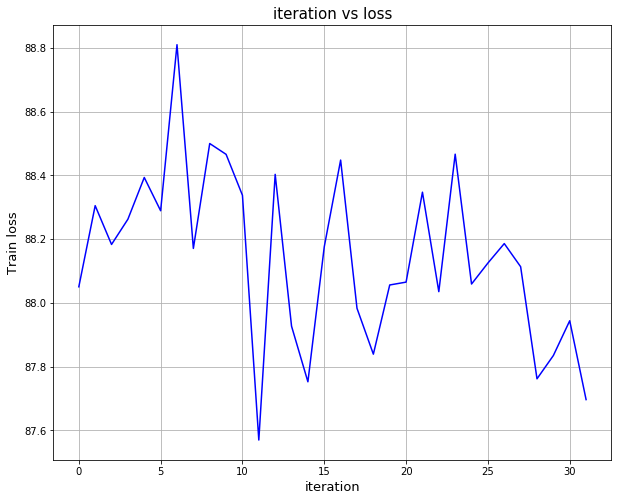

 60/200 [========>.....................] - ETA: 744s - train loss: 88.1424 - dev loss: 87.3527

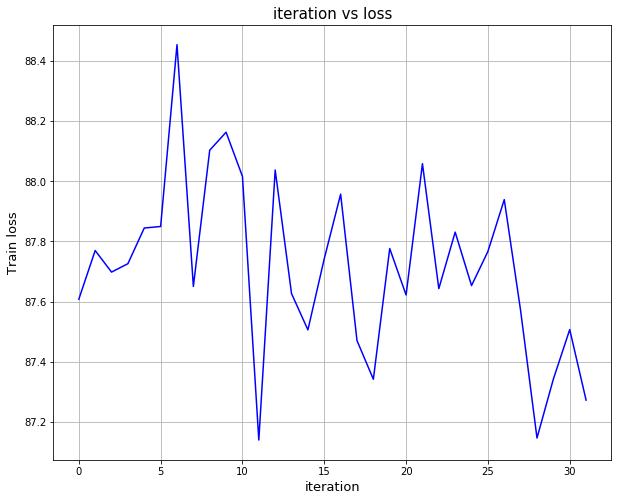

 61/200 [========>.....................] - ETA: 739s - train loss: 87.7134 - dev loss: 86.9311

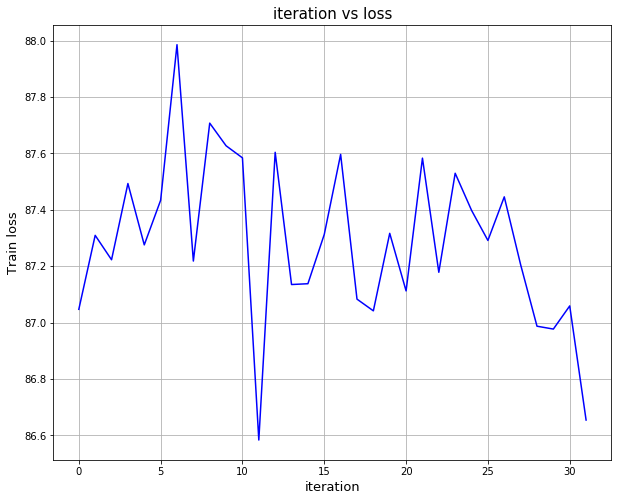

 62/200 [========>.....................] - ETA: 733s - train loss: 87.2854 - dev loss: 86.5159

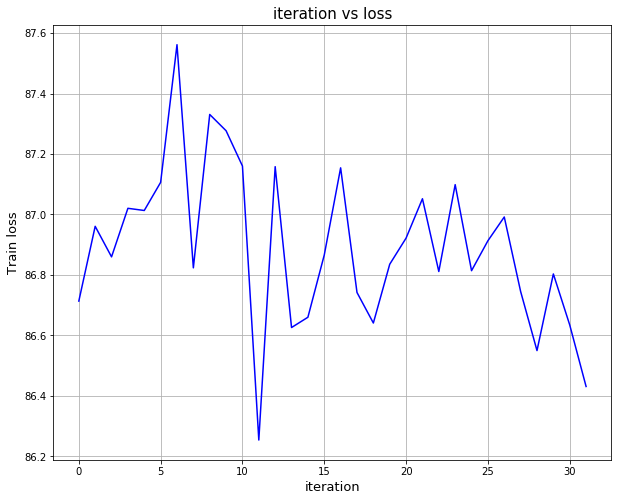

 63/200 [========>.....................] - ETA: 728s - train loss: 86.8916 - dev loss: 86.1057

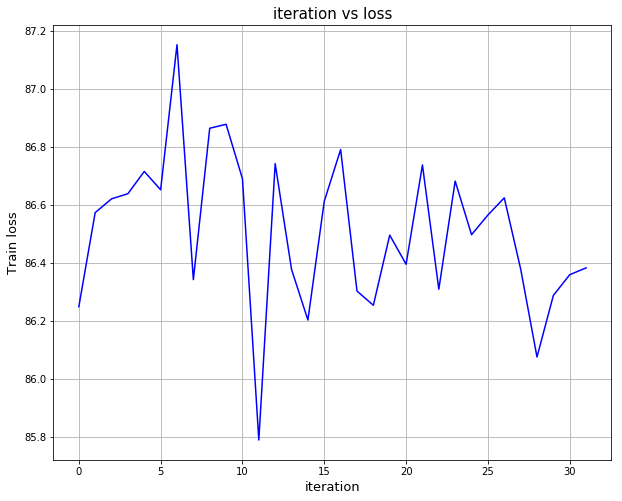

 64/200 [========>.....................] - ETA: 723s - train loss: 86.5077 - dev loss: 85.7005

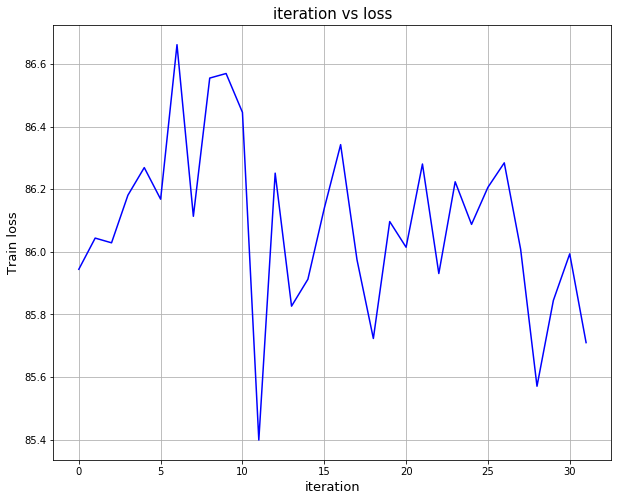

 65/200 [========>.....................] - ETA: 718s - train loss: 86.0873 - dev loss: 85.3019

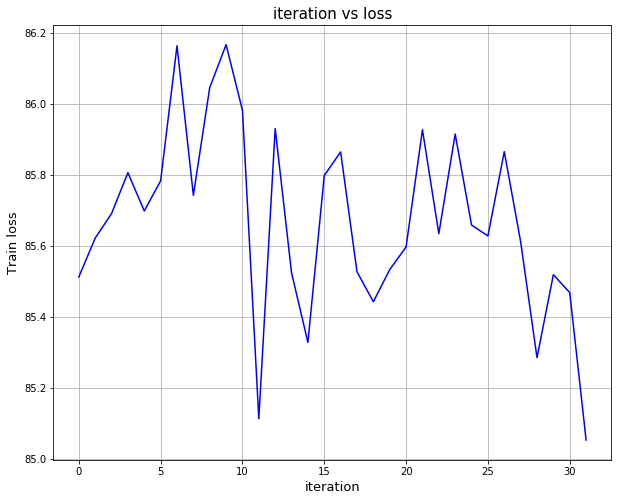

 66/200 [========>.....................] - ETA: 712s - train loss: 85.6706 - dev loss: 84.8839

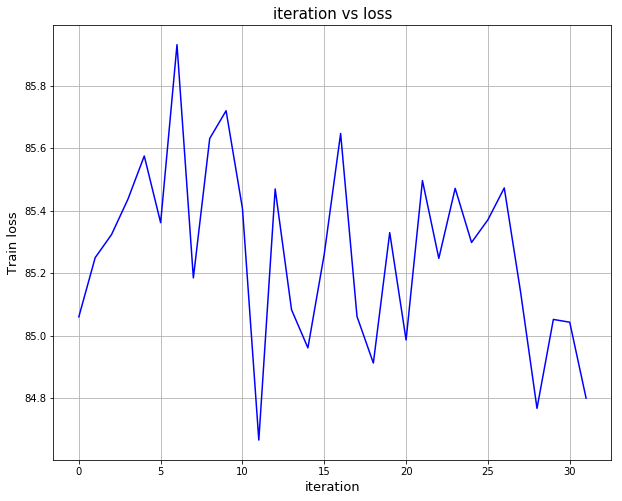

 67/200 [=========>....................] - ETA: 707s - train loss: 85.2629 - dev loss: 84.4940

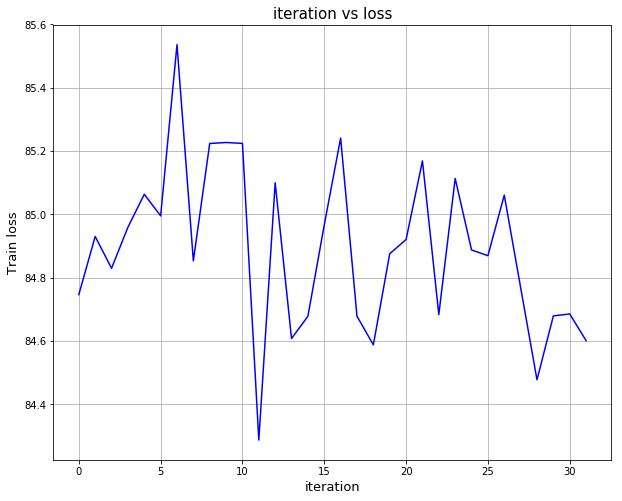

 68/200 [=========>....................] - ETA: 701s - train loss: 84.8917 - dev loss: 84.1116

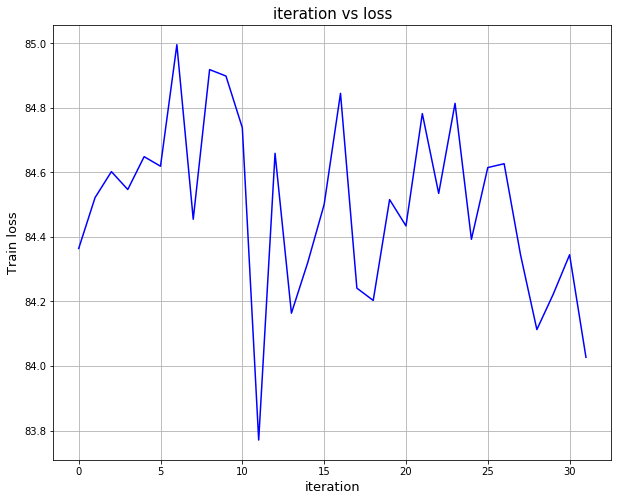

 69/200 [=========>....................] - ETA: 696s - train loss: 84.4932 - dev loss: 83.7342

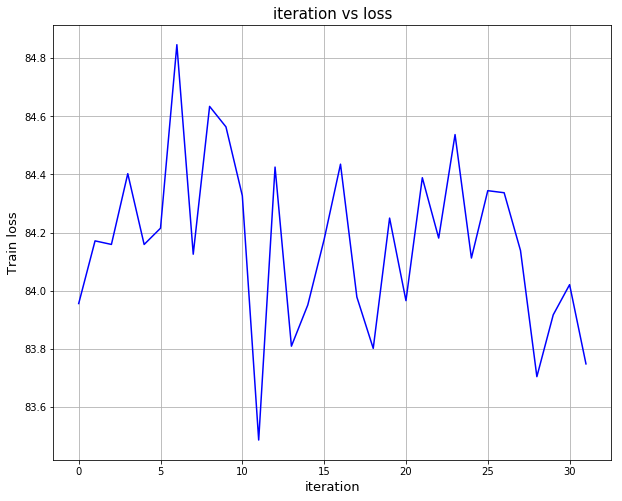

 70/200 [=========>....................] - ETA: 691s - train loss: 84.1647 - dev loss: 83.3629

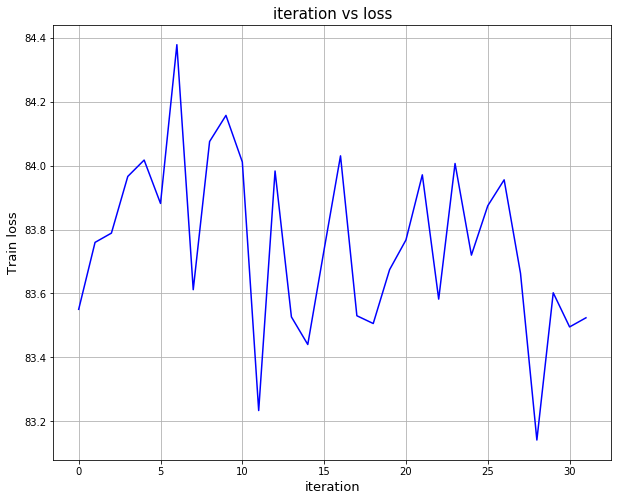

 71/200 [=========>....................] - ETA: 685s - train loss: 83.7552 - dev loss: 82.9967

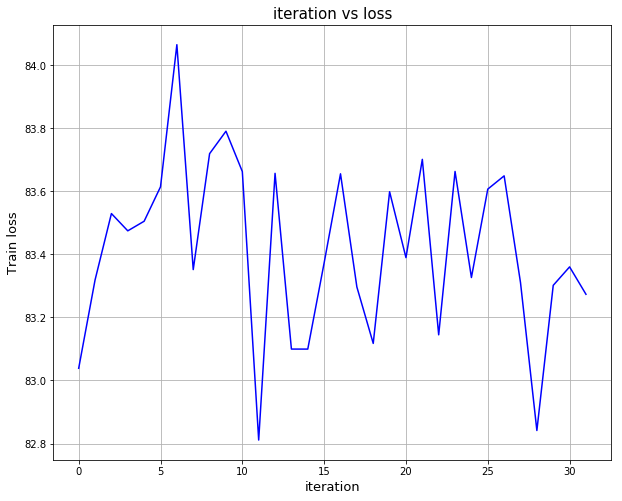

 72/200 [=========>....................] - ETA: 680s - train loss: 83.4172 - dev loss: 82.6352

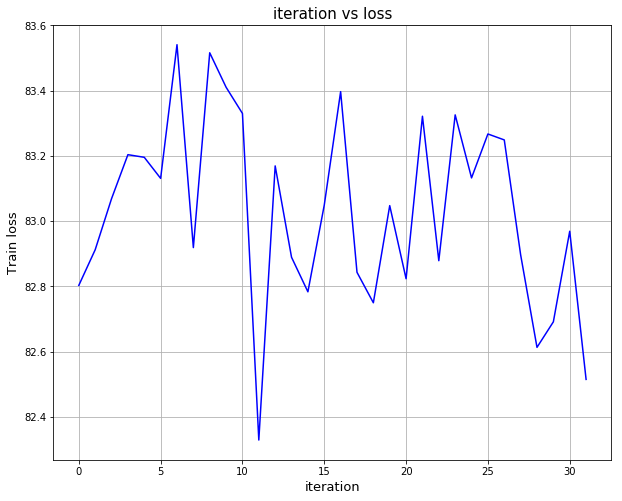

 73/200 [=========>....................] - ETA: 675s - train loss: 83.0304 - dev loss: 82.2804

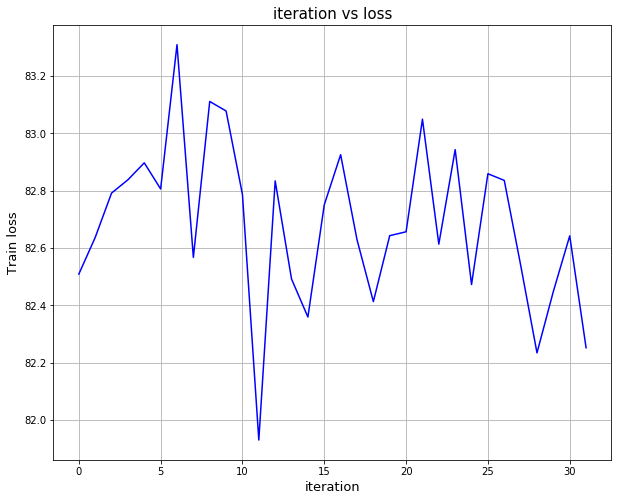

 74/200 [==========>...................] - ETA: 669s - train loss: 82.6827 - dev loss: 81.9307

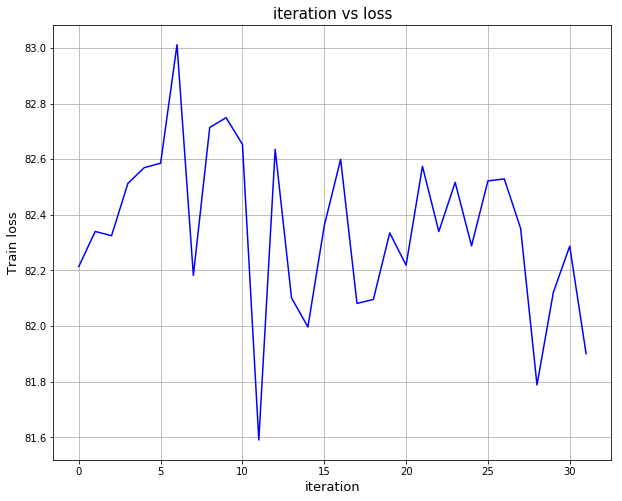

 75/200 [==========>...................] - ETA: 664s - train loss: 82.3465 - dev loss: 81.5848

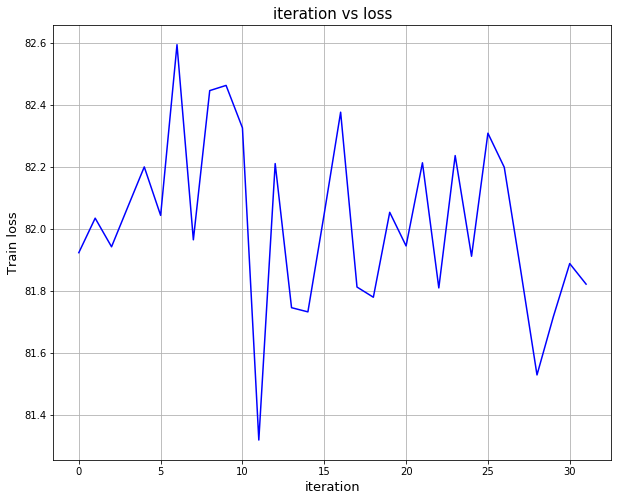

 76/200 [==========>...................] - ETA: 659s - train loss: 82.0163 - dev loss: 81.2434

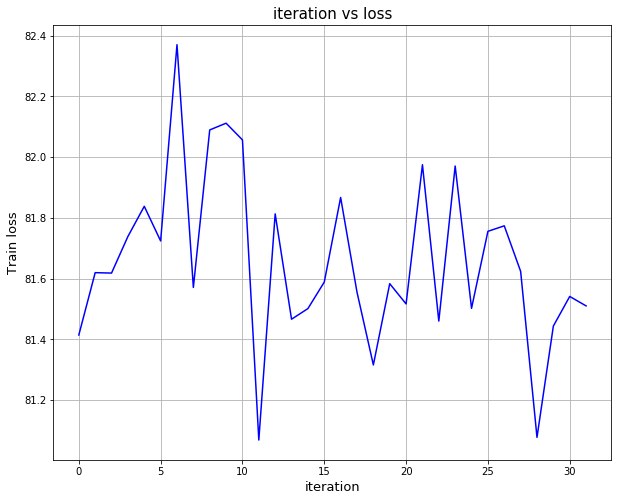

 77/200 [==========>...................] - ETA: 654s - train loss: 81.6582 - dev loss: 80.9083

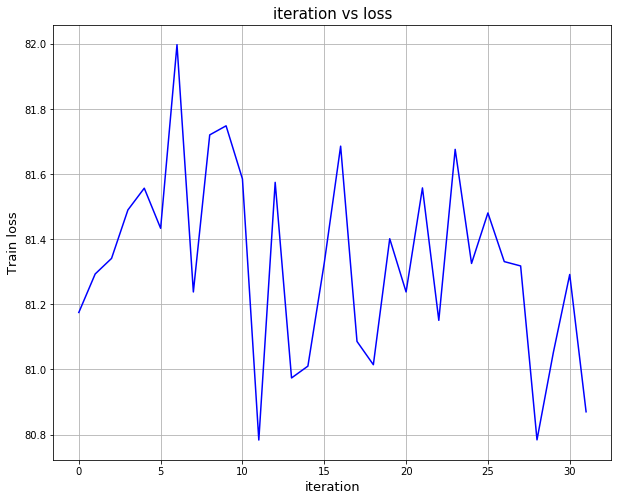

 78/200 [==========>...................] - ETA: 648s - train loss: 81.3289 - dev loss: 80.6358

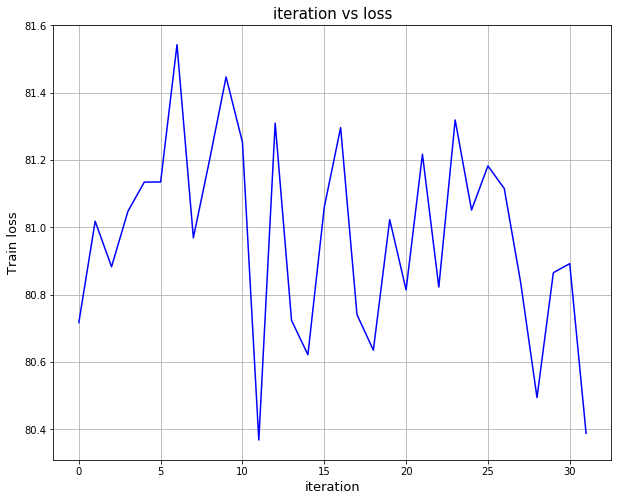

 79/200 [==========>...................] - ETA: 643s - train loss: 80.9725 - dev loss: 80.3117

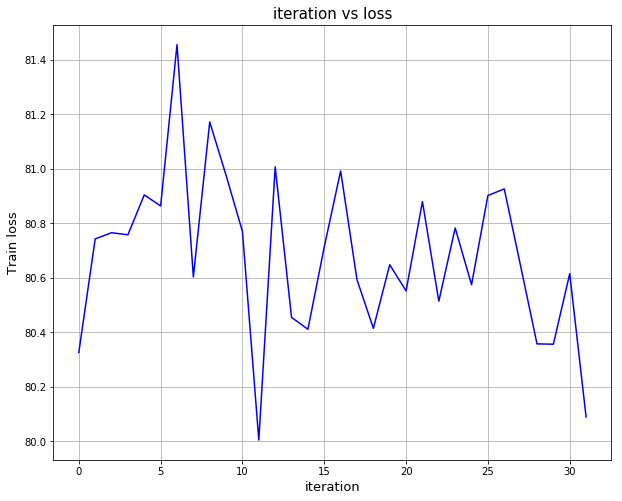

 80/200 [===========>..................] - ETA: 638s - train loss: 80.6807 - dev loss: 79.9916

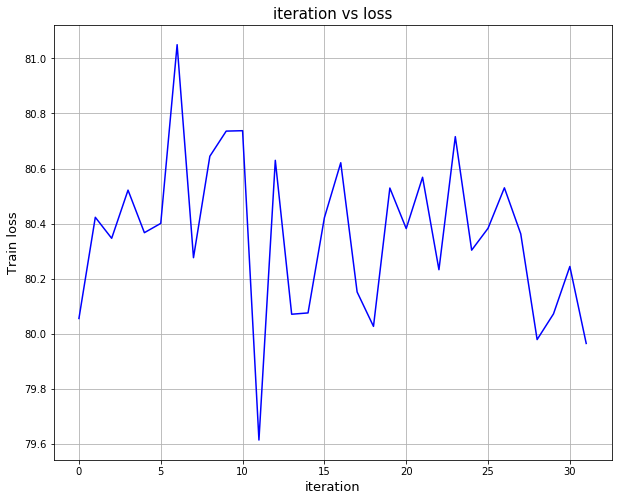

 81/200 [===========>..................] - ETA: 633s - train loss: 80.3574 - dev loss: 79.6758

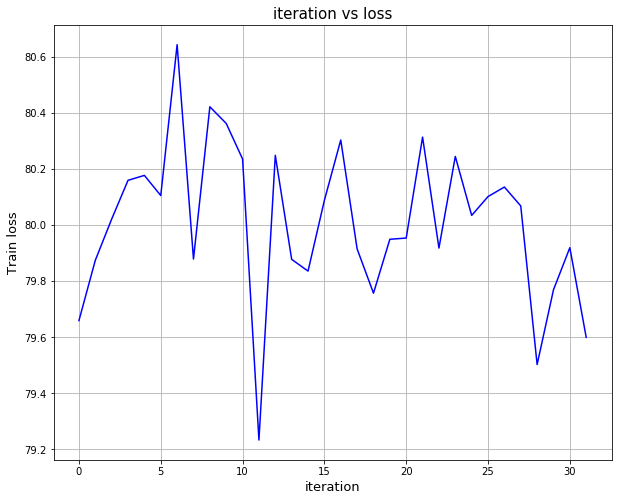

 82/200 [===========>..................] - ETA: 627s - train loss: 80.0101 - dev loss: 79.3652

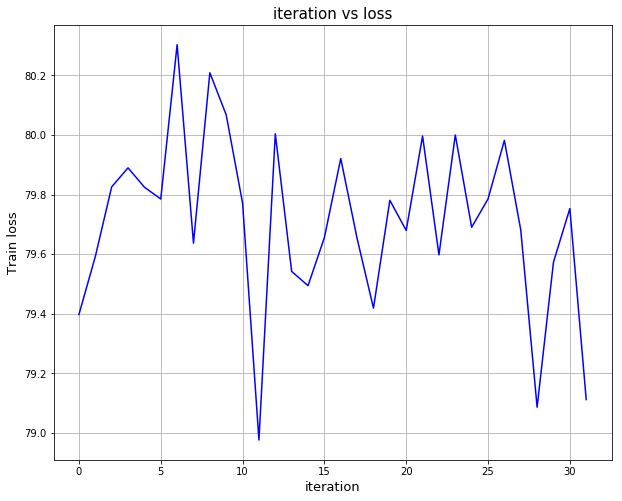

 83/200 [===========>..................] - ETA: 622s - train loss: 79.7090 - dev loss: 79.0581

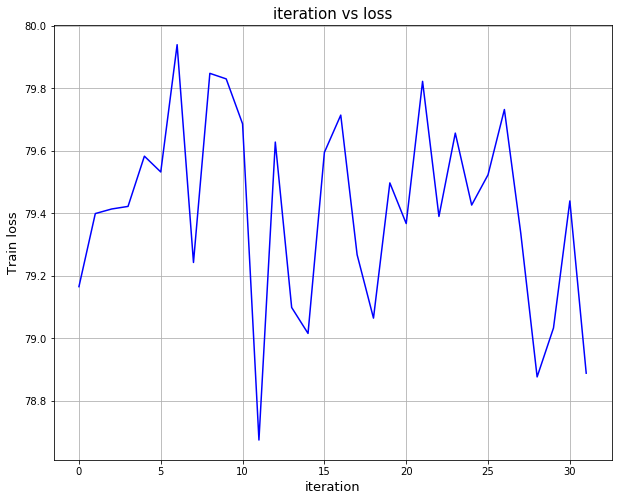

 84/200 [===========>..................] - ETA: 617s - train loss: 79.4099 - dev loss: 78.7549

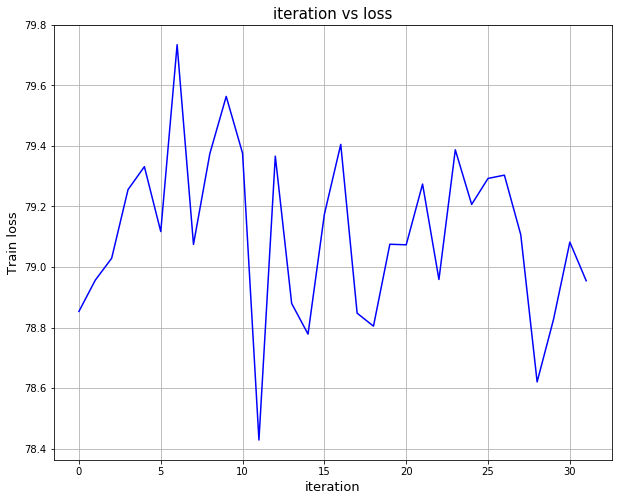

 85/200 [===========>..................] - ETA: 611s - train loss: 79.1096 - dev loss: 78.4561

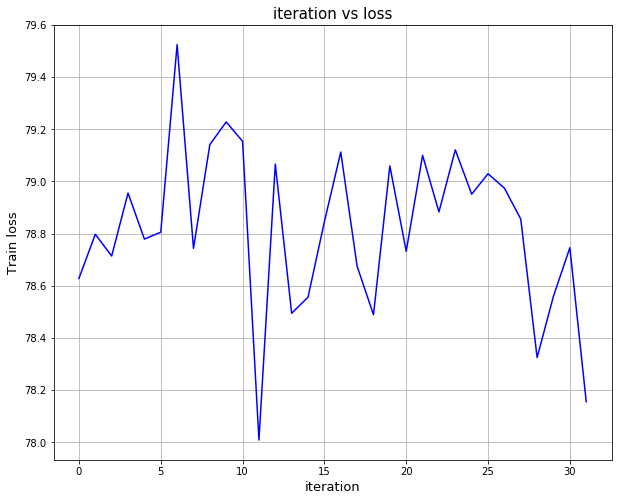

 86/200 [===========>..................] - ETA: 606s - train loss: 78.8192 - dev loss: 78.1636

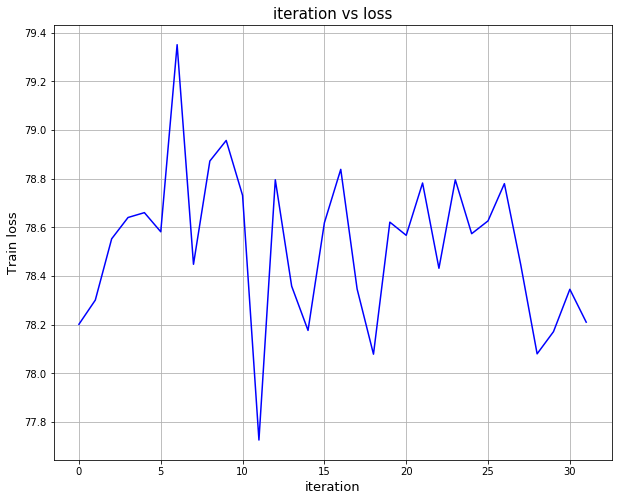

 87/200 [============>.................] - ETA: 601s - train loss: 78.5209 - dev loss: 77.9027

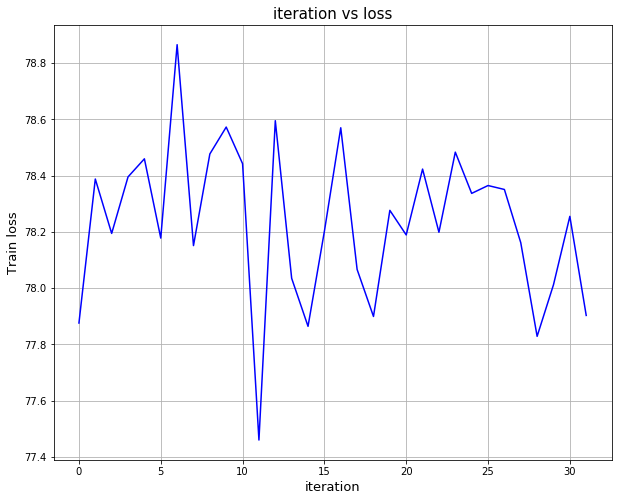

 88/200 [============>.................] - ETA: 595s - train loss: 78.2333 - dev loss: 77.7965

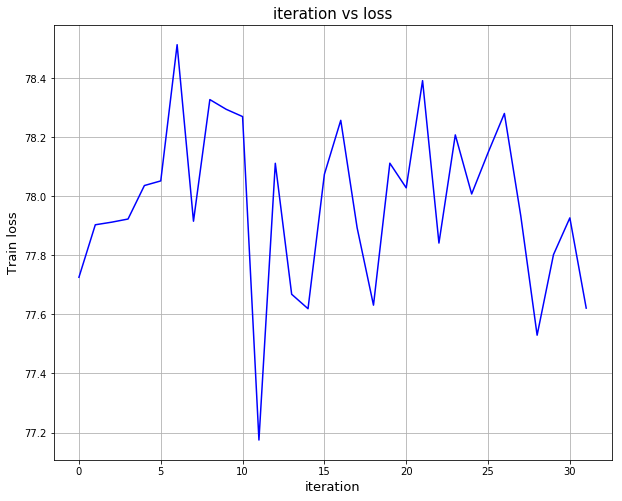

 89/200 [============>.................] - ETA: 590s - train loss: 77.9735 - dev loss: 77.5226

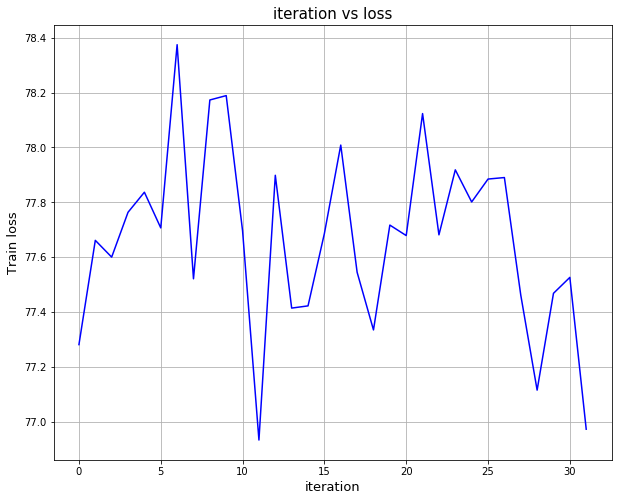

 90/200 [============>.................] - ETA: 585s - train loss: 77.6650 - dev loss: 77.2499

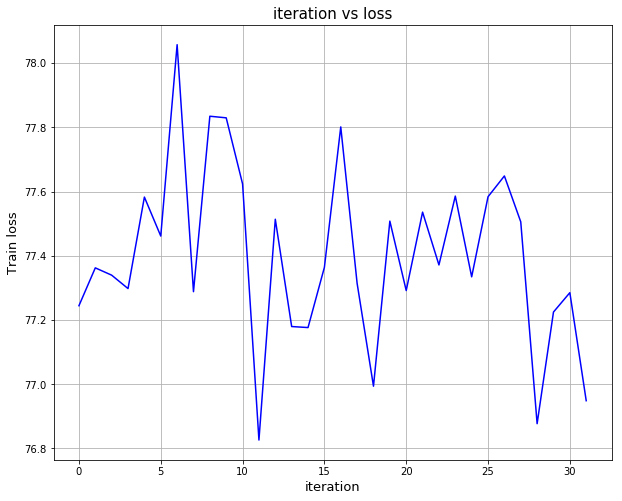

 91/200 [============>.................] - ETA: 580s - train loss: 77.3999 - dev loss: 76.9738

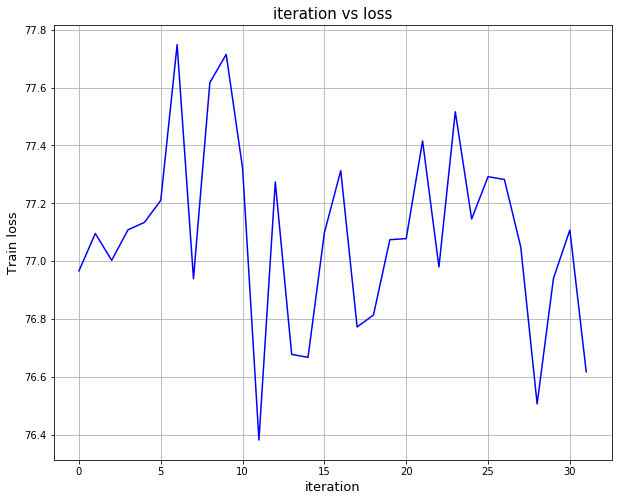

 92/200 [============>.................] - ETA: 574s - train loss: 77.0896 - dev loss: 76.7046

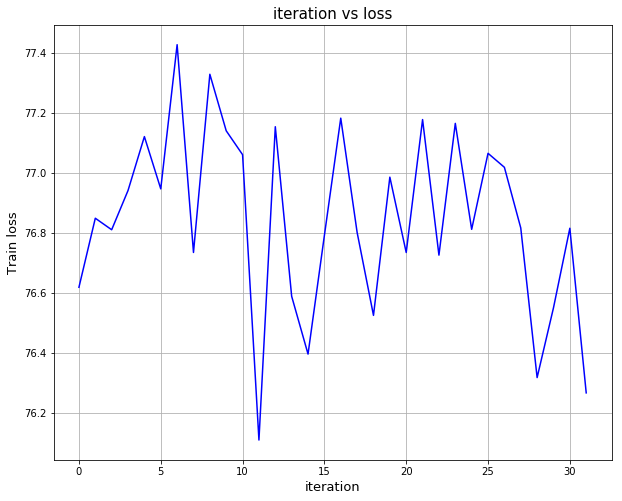

 93/200 [============>.................] - ETA: 569s - train loss: 76.8433 - dev loss: 76.4438

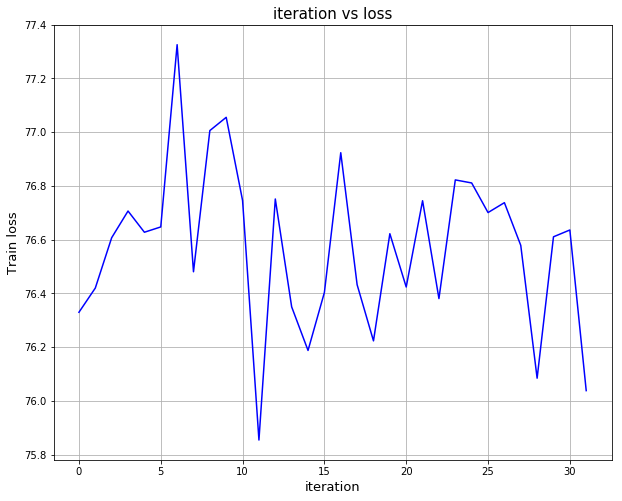

 94/200 [=============>................] - ETA: 564s - train loss: 76.5709 - dev loss: 76.1817

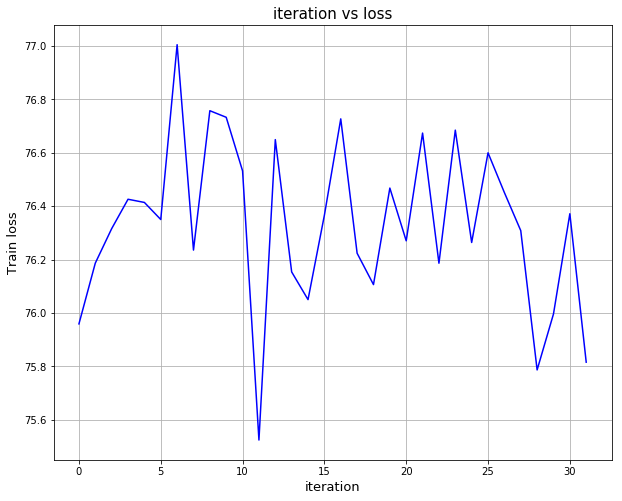

 95/200 [=============>................] - ETA: 558s - train loss: 76.3308 - dev loss: 75.9249

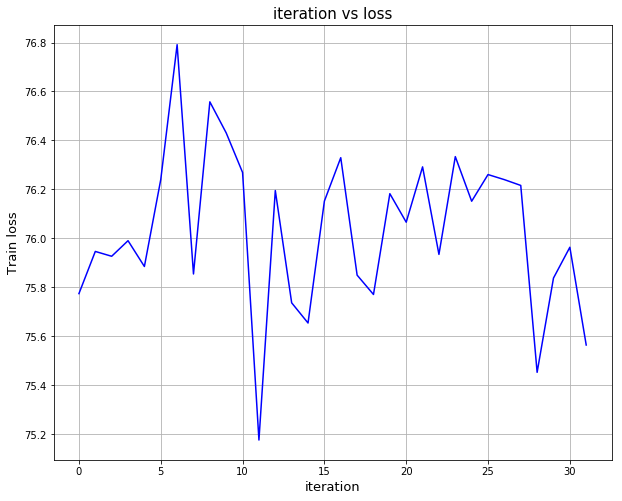

 96/200 [=============>................] - ETA: 553s - train loss: 76.0325 - dev loss: 75.6725

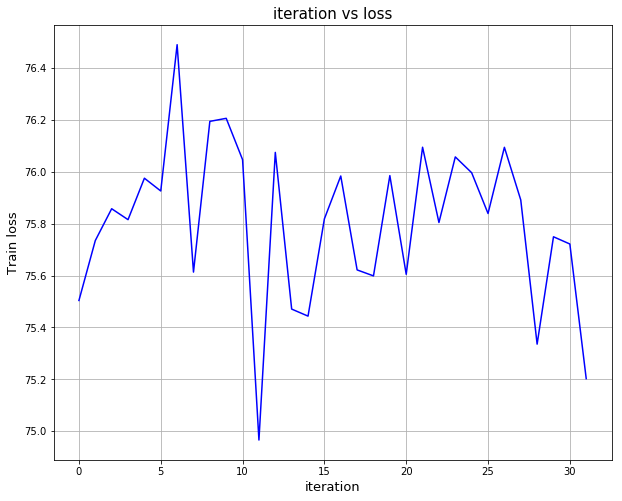

 97/200 [=============>................] - ETA: 548s - train loss: 75.8037 - dev loss: 75.4216

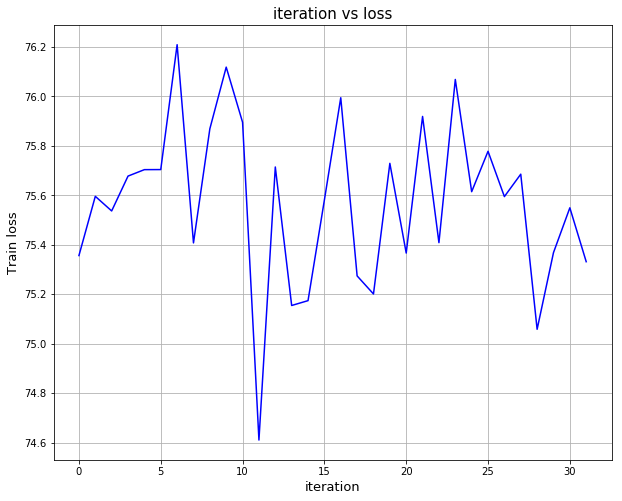

 98/200 [=============>................] - ETA: 543s - train loss: 75.5701 - dev loss: 75.1728

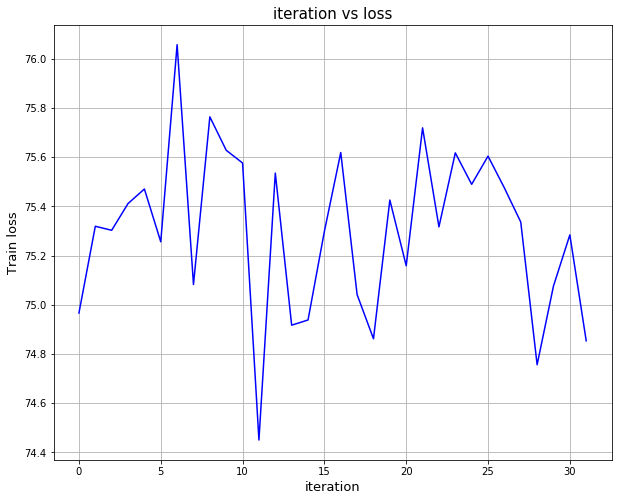

 99/200 [=============>................] - ETA: 537s - train loss: 75.3000 - dev loss: 75.2791

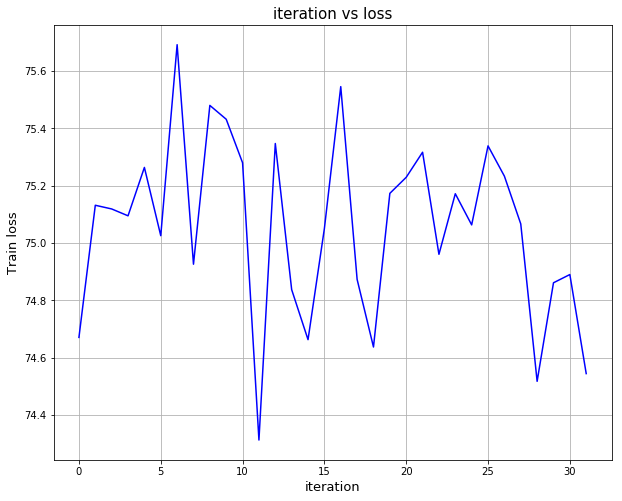

100/200 [==============>...............] - ETA: 532s - train loss: 75.0547 - dev loss: 75.0483

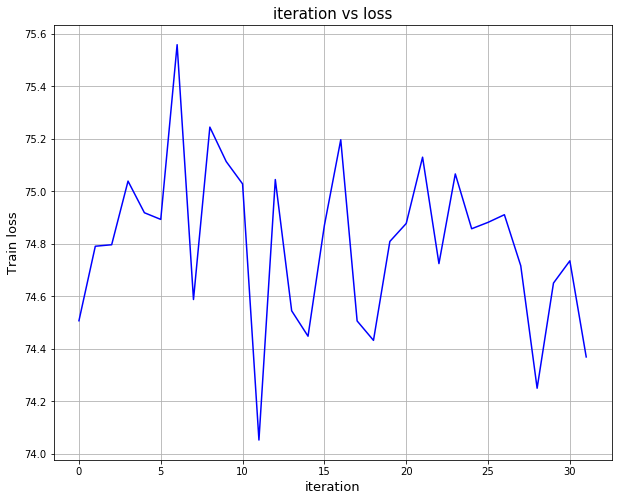

101/200 [==============>...............] - ETA: 527s - train loss: 74.7986 - dev loss: 74.8102

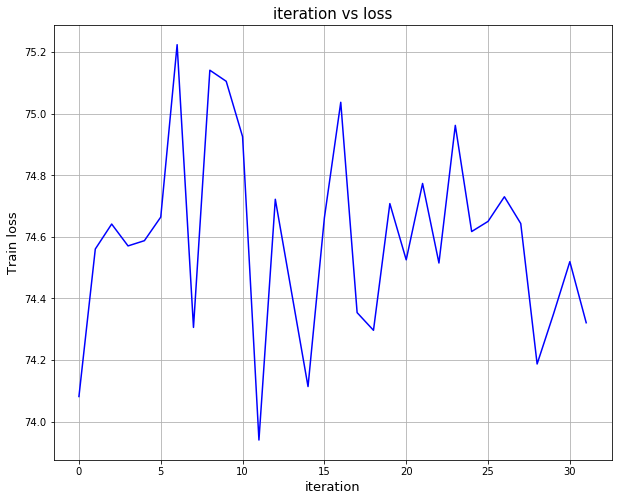

102/200 [==============>...............] - ETA: 521s - train loss: 74.5892 - dev loss: 74.5763

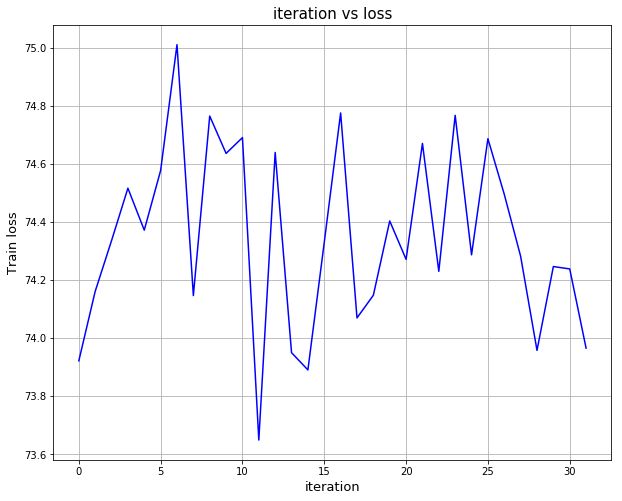

103/200 [==============>...............] - ETA: 516s - train loss: 74.3463 - dev loss: 74.3496

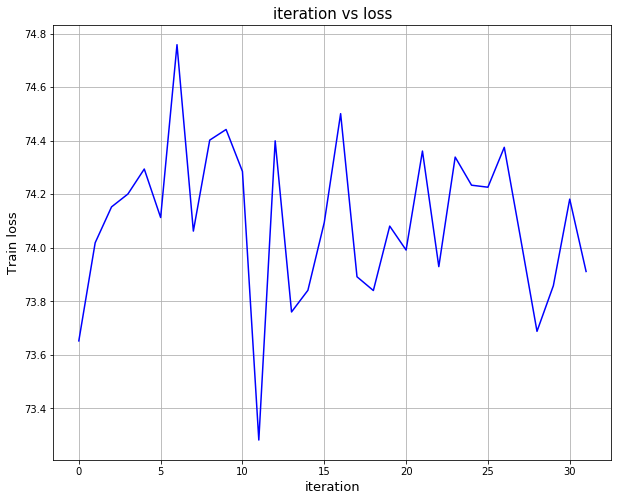

104/200 [==============>...............] - ETA: 511s - train loss: 74.1000 - dev loss: 74.1249

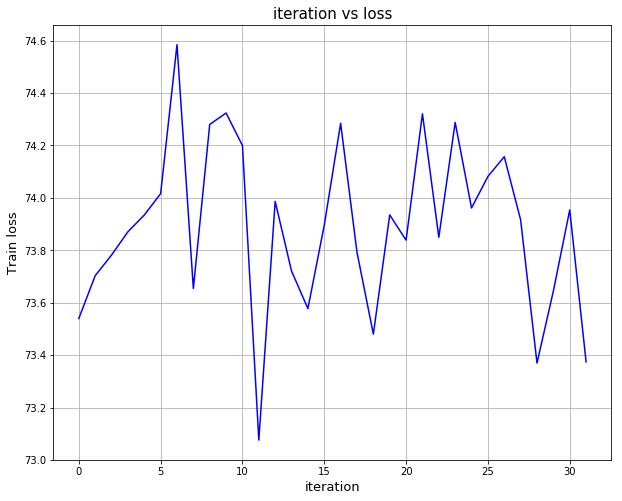

105/200 [==============>...............] - ETA: 505s - train loss: 73.8874 - dev loss: 73.8920

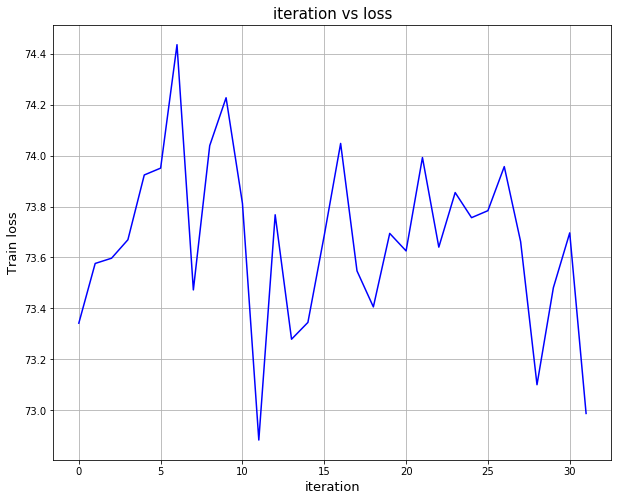

106/200 [==============>...............] - ETA: 500s - train loss: 73.6638 - dev loss: 73.6737

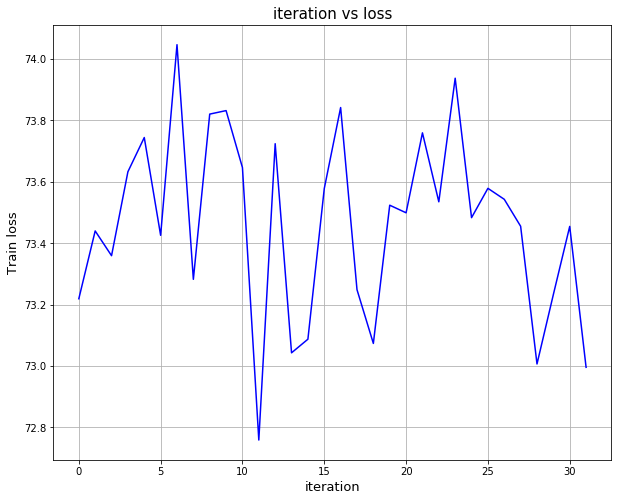

107/200 [===============>..............] - ETA: 495s - train loss: 73.4629 - dev loss: 73.4544

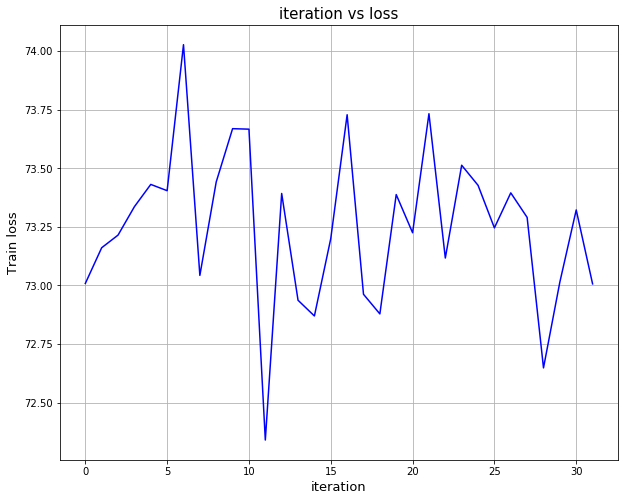

108/200 [===============>..............] - ETA: 493s - train loss: 73.2514 - dev loss: 73.2428

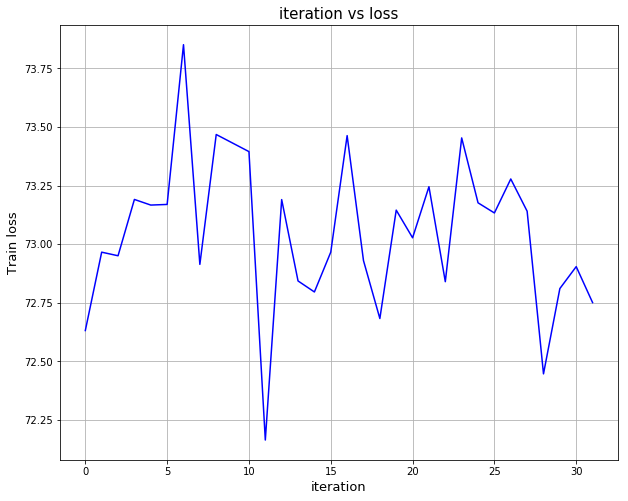

109/200 [===============>..............] - ETA: 492s - train loss: 73.0475 - dev loss: 73.0338

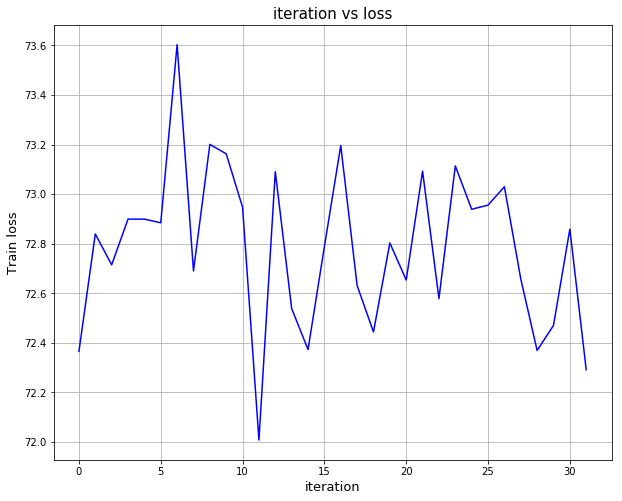

110/200 [===============>..............] - ETA: 491s - train loss: 72.7841 - dev loss: 72.8159

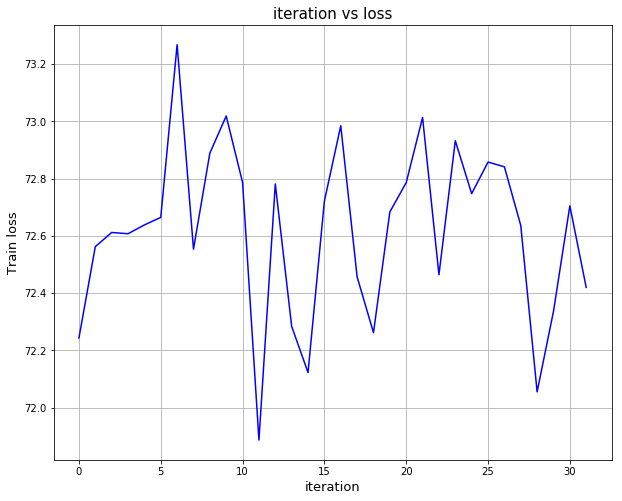

111/200 [===============>..............] - ETA: 489s - train loss: 72.6194 - dev loss: 72.6130

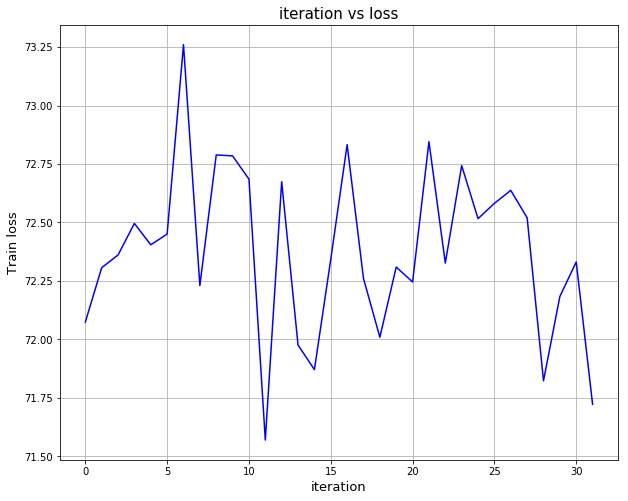

112/200 [===============>..............] - ETA: 488s - train loss: 72.3800 - dev loss: 72.4083

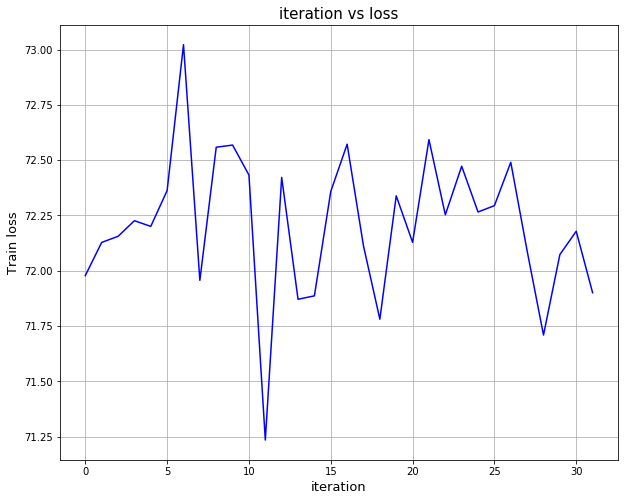

113/200 [===============>..............] - ETA: 486s - train loss: 72.2066 - dev loss: 72.2102

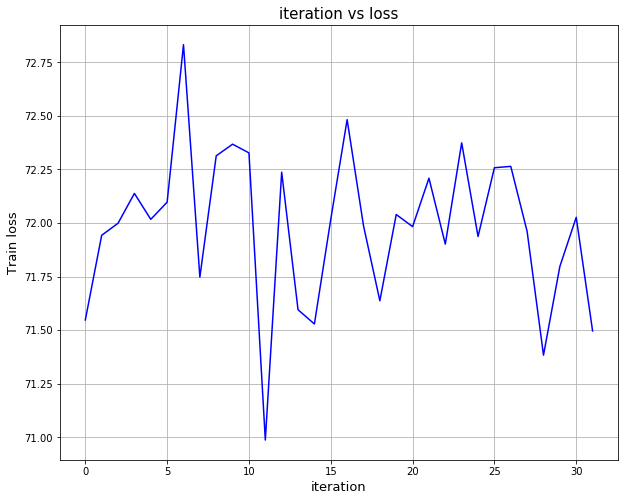

114/200 [================>.............] - ETA: 484s - train loss: 71.9823 - dev loss: 72.0105

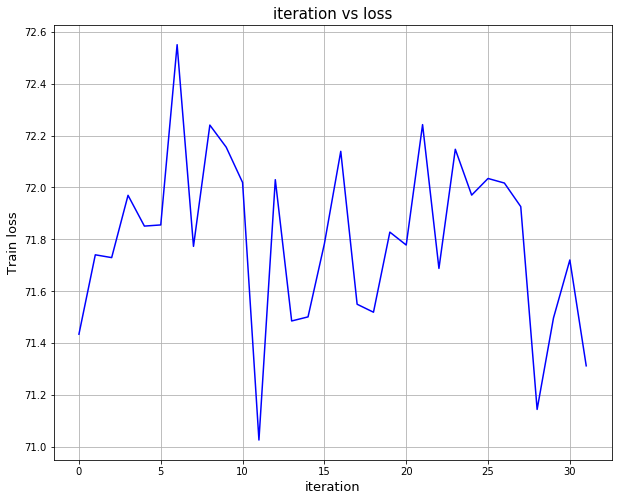

115/200 [================>.............] - ETA: 481s - train loss: 71.8019 - dev loss: 71.8116

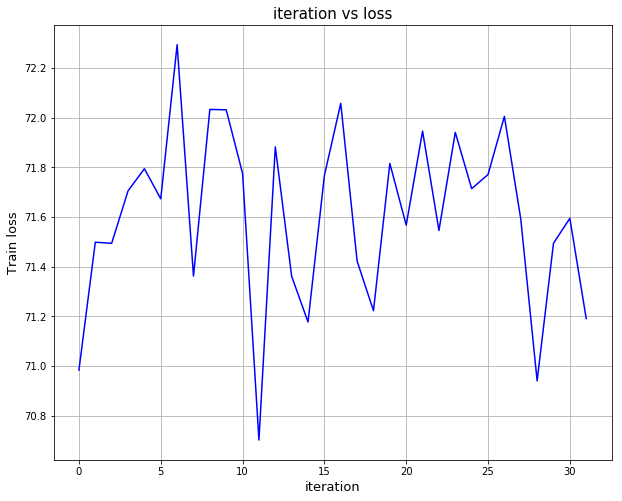

116/200 [================>.............] - ETA: 479s - train loss: 71.6054 - dev loss: 71.6167

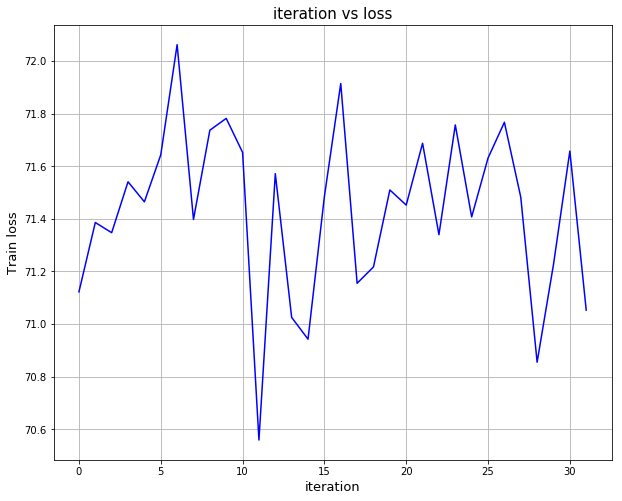

117/200 [================>.............] - ETA: 473s - train loss: 71.4324 - dev loss: 71.6605

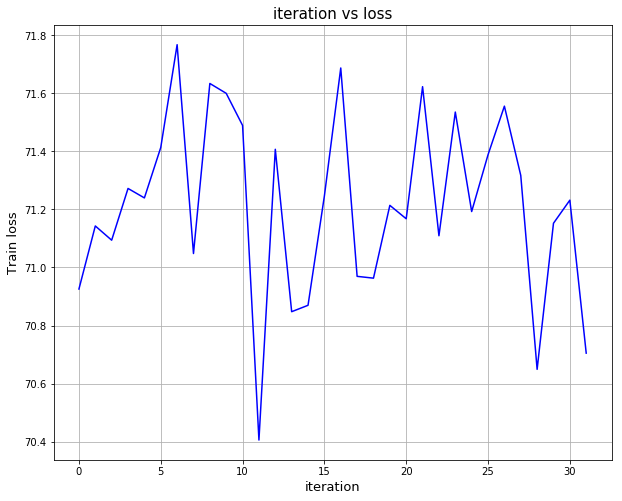

118/200 [================>.............] - ETA: 467s - train loss: 71.2145 - dev loss: 71.5638

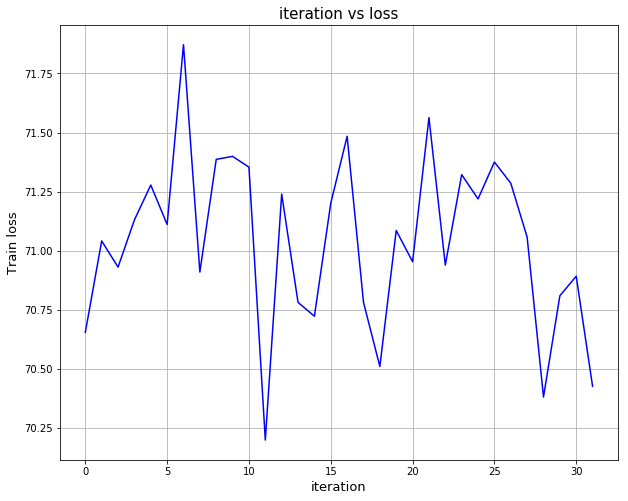

119/200 [================>.............] - ETA: 461s - train loss: 71.0407 - dev loss: 71.5535

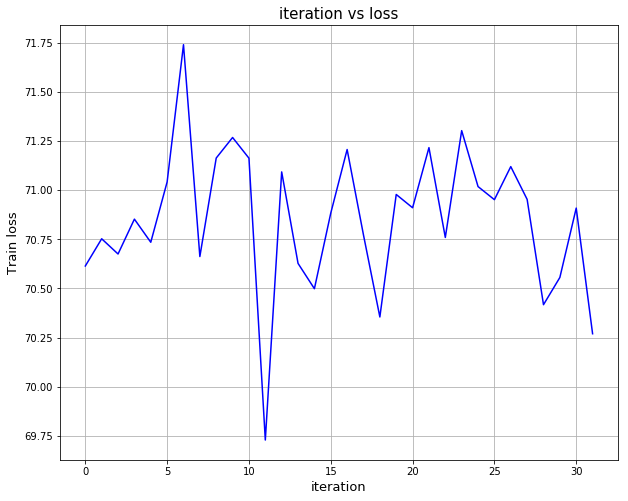

120/200 [=================>............] - ETA: 455s - train loss: 70.8497 - dev loss: 71.3863

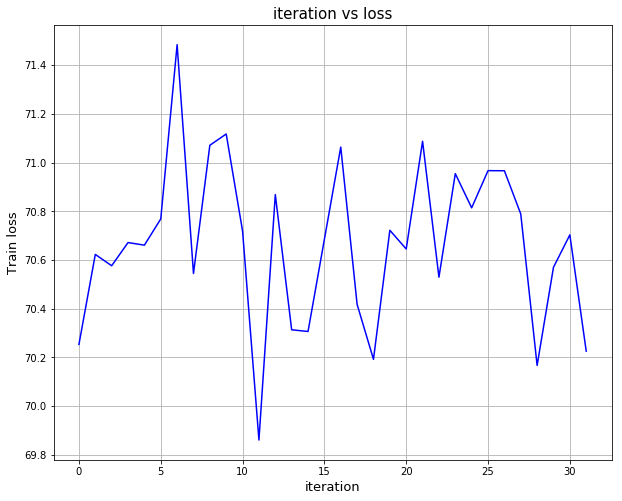

121/200 [=================>............] - ETA: 449s - train loss: 70.6669 - dev loss: 71.2108

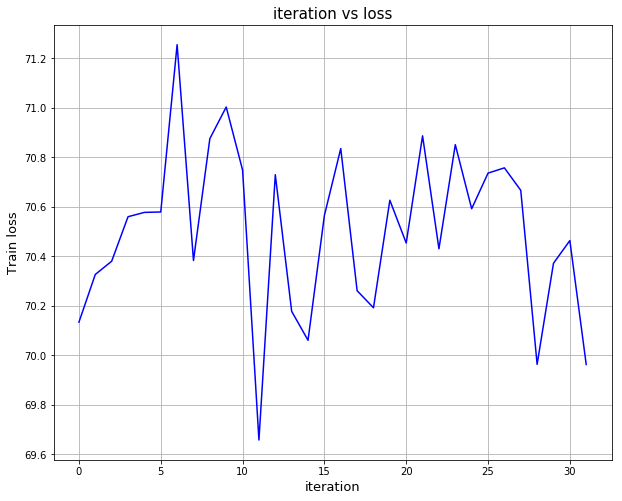

122/200 [=================>............] - ETA: 443s - train loss: 70.5025 - dev loss: 71.0337

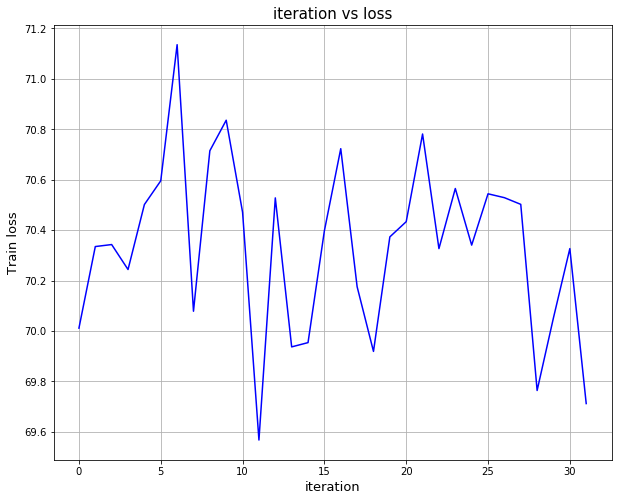

123/200 [=================>............] - ETA: 437s - train loss: 70.3350 - dev loss: 70.6181

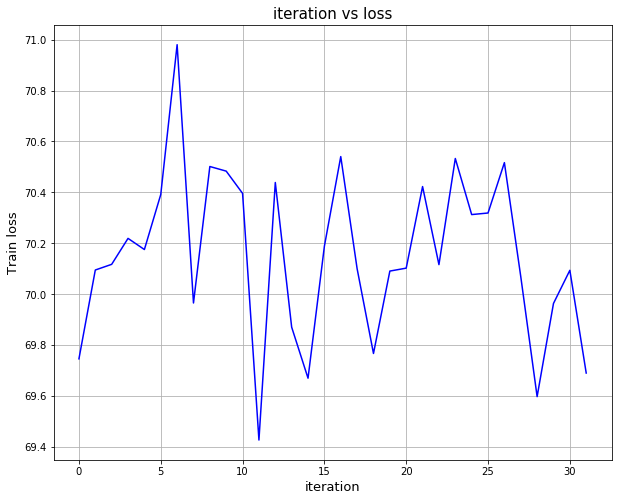

124/200 [=================>............] - ETA: 431s - train loss: 70.1533 - dev loss: 70.5952

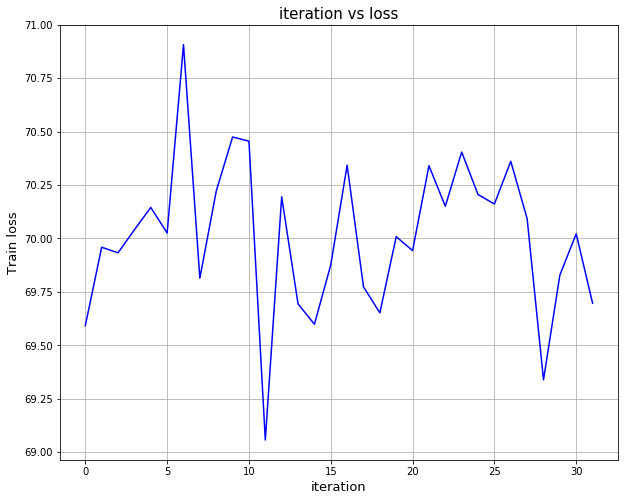

125/200 [=================>............] - ETA: 426s - train loss: 70.0095 - dev loss: 70.4710

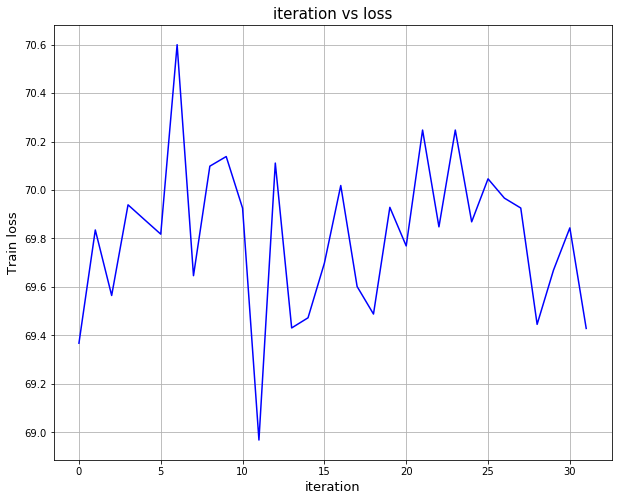

126/200 [=================>............] - ETA: 420s - train loss: 69.8072 - dev loss: 70.3159

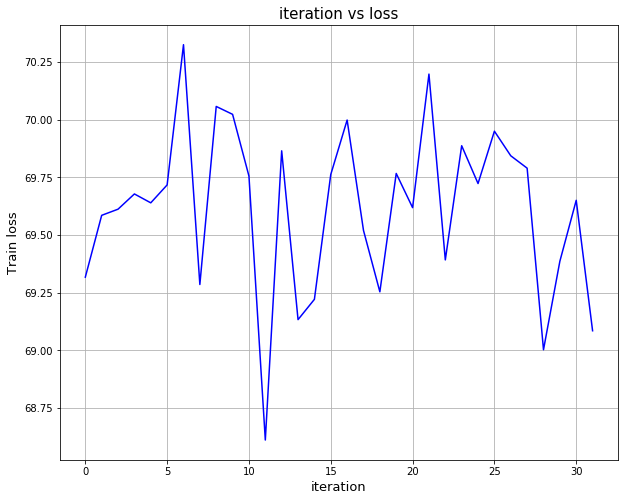

127/200 [==================>...........] - ETA: 414s - train loss: 69.6144 - dev loss: 70.1559

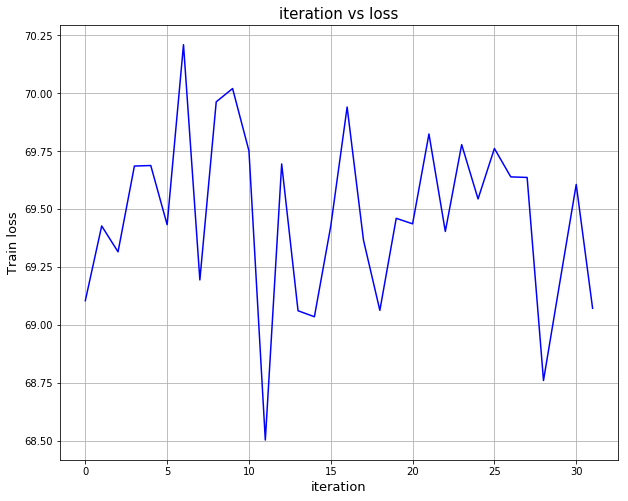

128/200 [==================>...........] - ETA: 408s - train loss: 69.4687 - dev loss: 69.9904

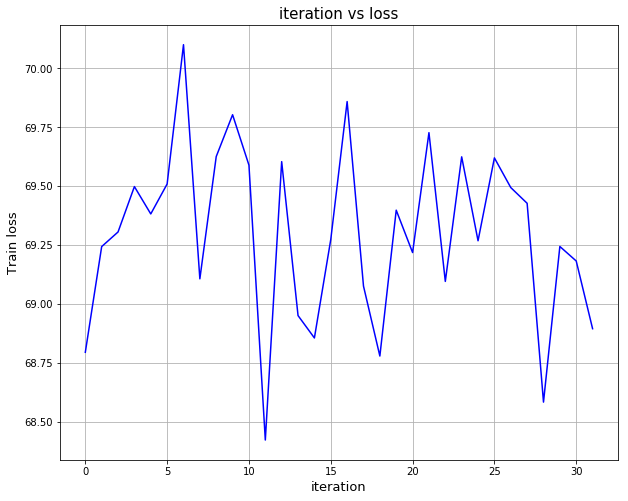

129/200 [==================>...........] - ETA: 402s - train loss: 69.2990 - dev loss: 69.8291

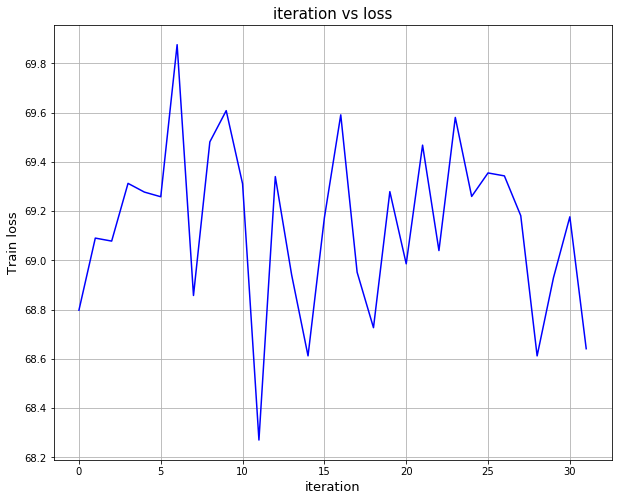

130/200 [==================>...........] - ETA: 396s - train loss: 69.1379 - dev loss: 69.6733

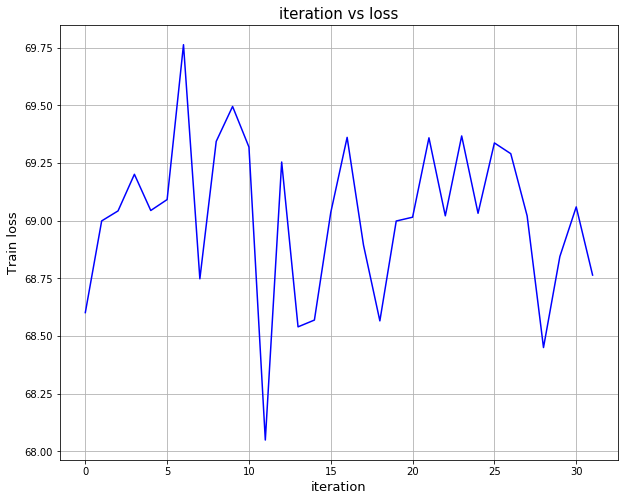

131/200 [==================>...........] - ETA: 390s - train loss: 69.0153 - dev loss: 69.5205

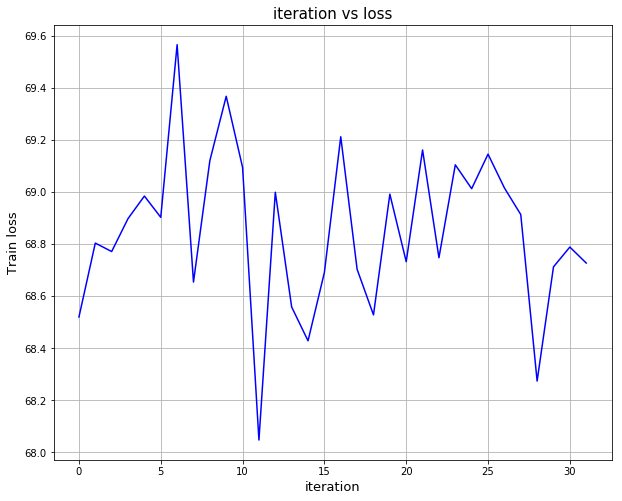

132/200 [==================>...........] - ETA: 385s - train loss: 68.8494 - dev loss: 69.3653

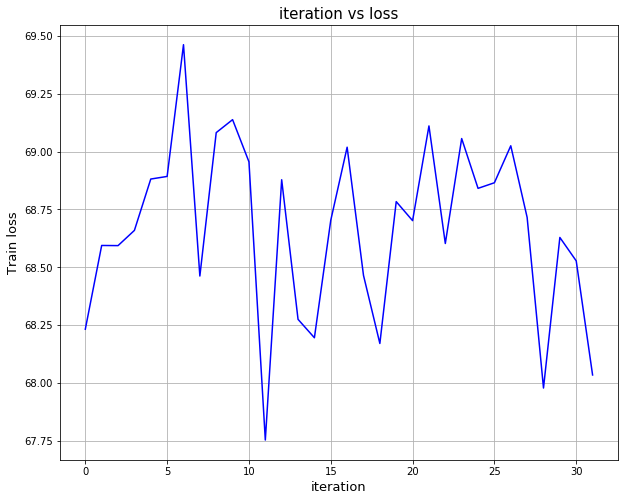

133/200 [==================>...........] - ETA: 379s - train loss: 68.6650 - dev loss: 69.2189

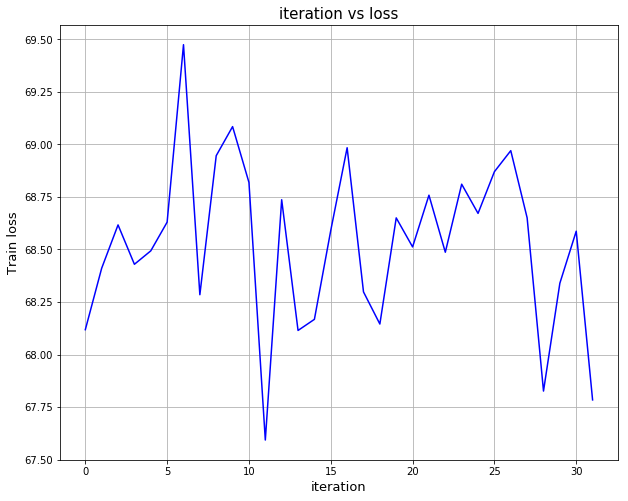

134/200 [===================>..........] - ETA: 373s - train loss: 68.5268 - dev loss: 69.0684

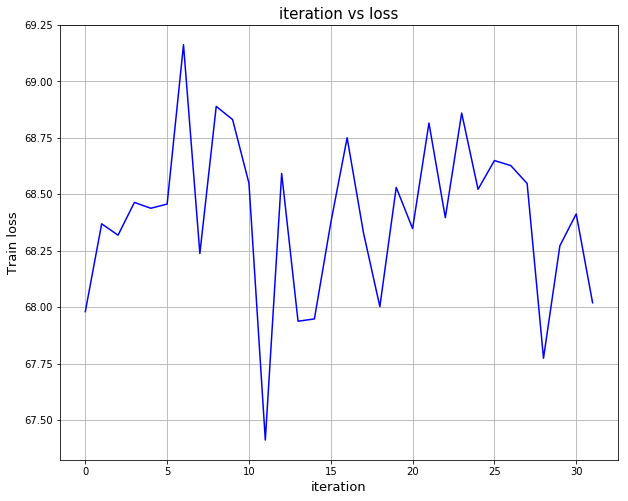

135/200 [===================>..........] - ETA: 367s - train loss: 68.4000 - dev loss: 68.9314

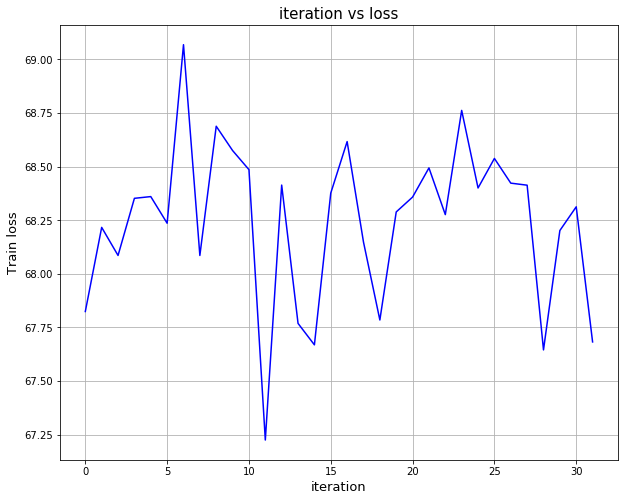

136/200 [===================>..........] - ETA: 361s - train loss: 68.2431 - dev loss: 68.7872

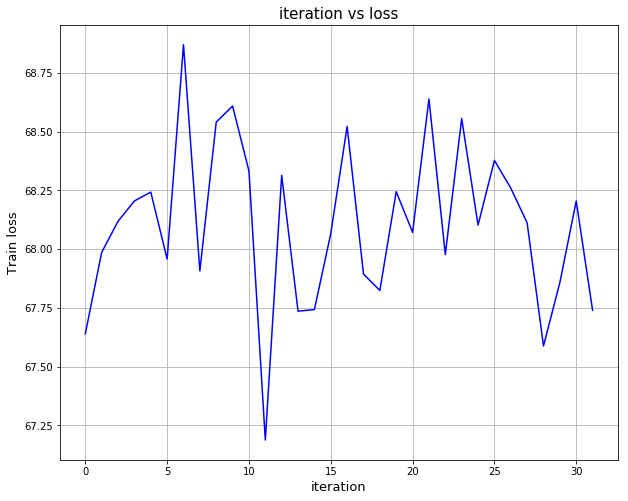

137/200 [===================>..........] - ETA: 356s - train loss: 68.1073 - dev loss: 68.6502

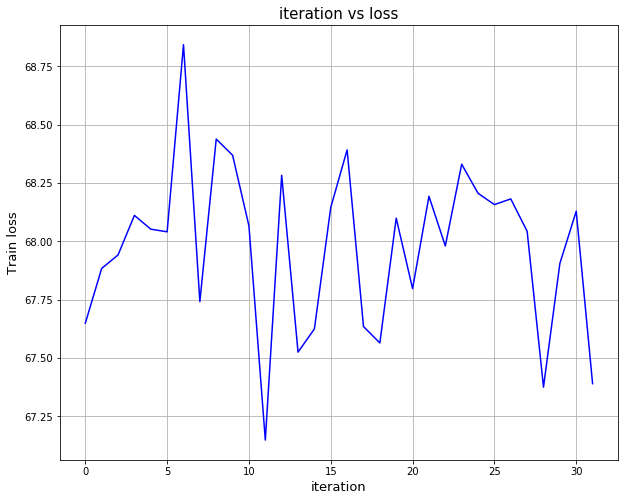

138/200 [===================>..........] - ETA: 350s - train loss: 67.9769 - dev loss: 68.5135

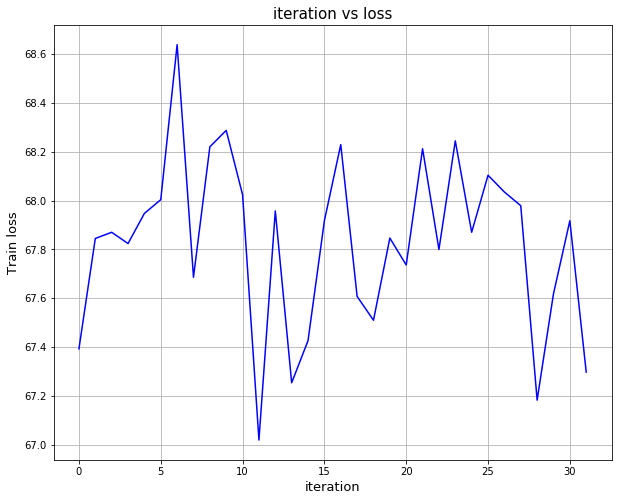

139/200 [===================>..........] - ETA: 344s - train loss: 67.8279 - dev loss: 68.3747

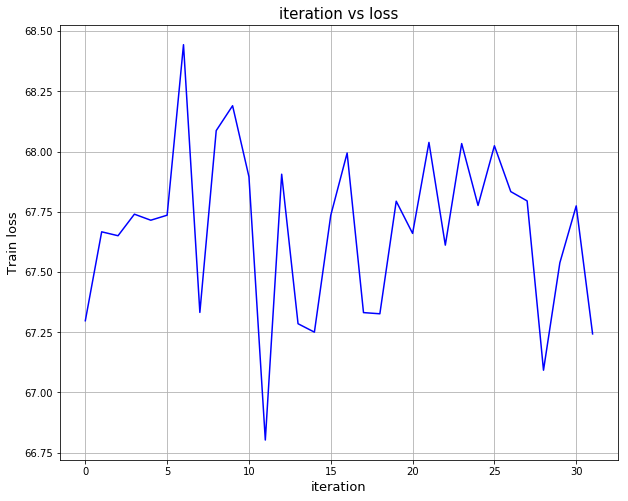

140/200 [====================>.........] - ETA: 338s - train loss: 67.6751 - dev loss: 68.2455

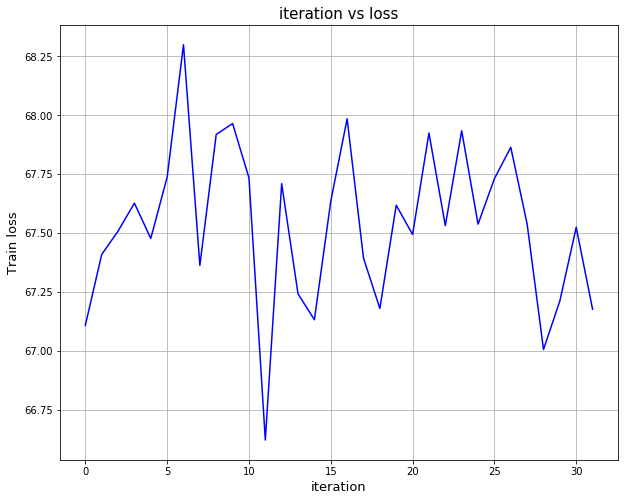

141/200 [====================>.........] - ETA: 332s - train loss: 67.5354 - dev loss: 68.1111

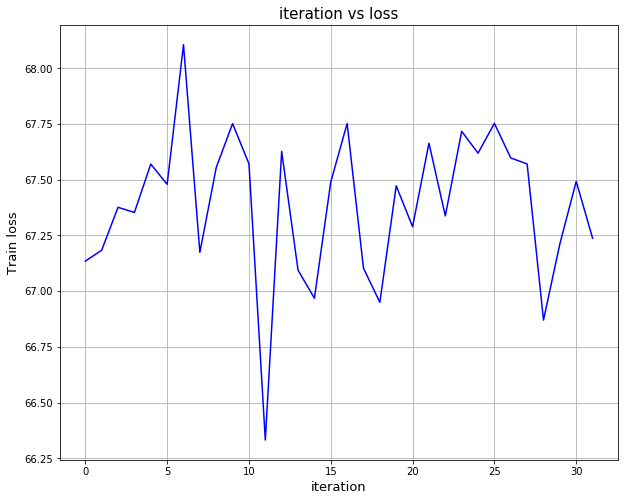

142/200 [====================>.........] - ETA: 327s - train loss: 67.3874 - dev loss: 67.9892

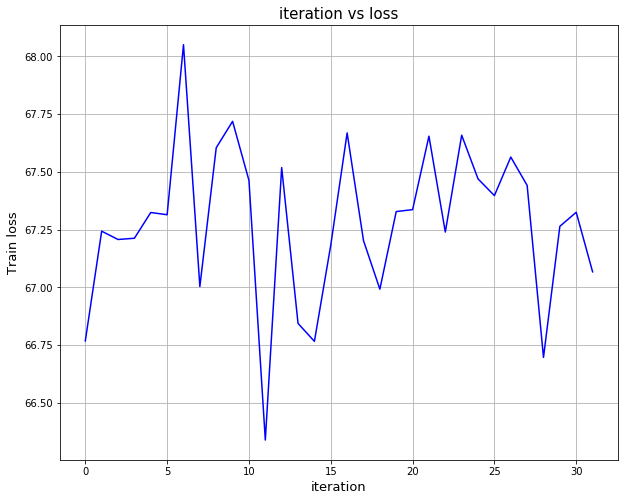

143/200 [====================>.........] - ETA: 321s - train loss: 67.2768 - dev loss: 67.8667

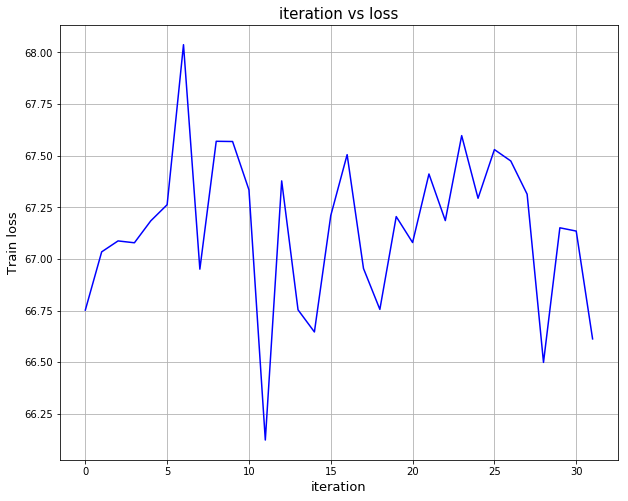

144/200 [====================>.........] - ETA: 315s - train loss: 67.1458 - dev loss: 67.7411

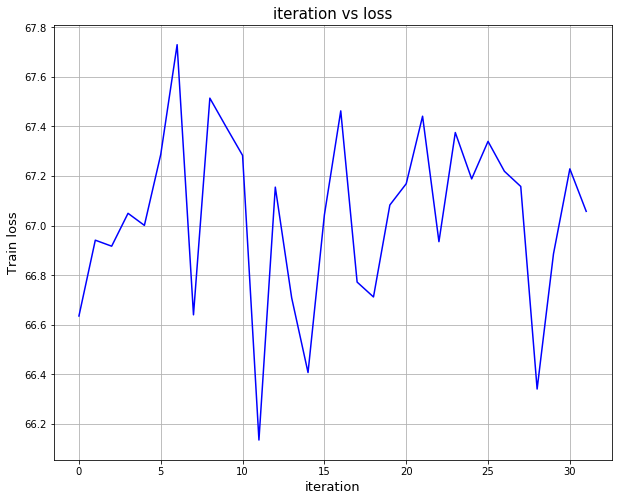

145/200 [====================>.........] - ETA: 309s - train loss: 67.0382 - dev loss: 67.6209

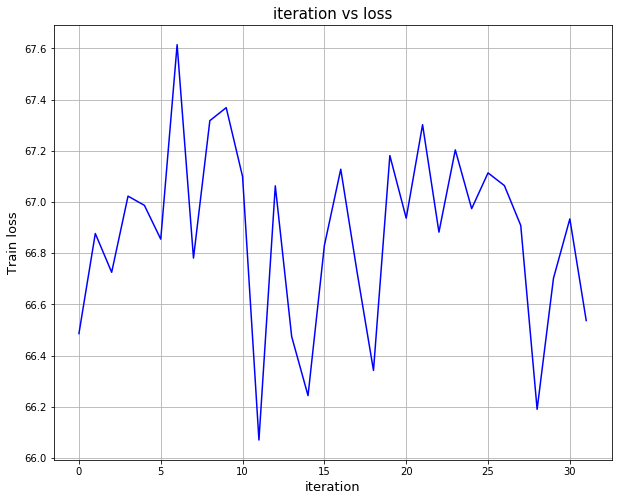

146/200 [====================>.........] - ETA: 304s - train loss: 66.8730 - dev loss: 67.5067

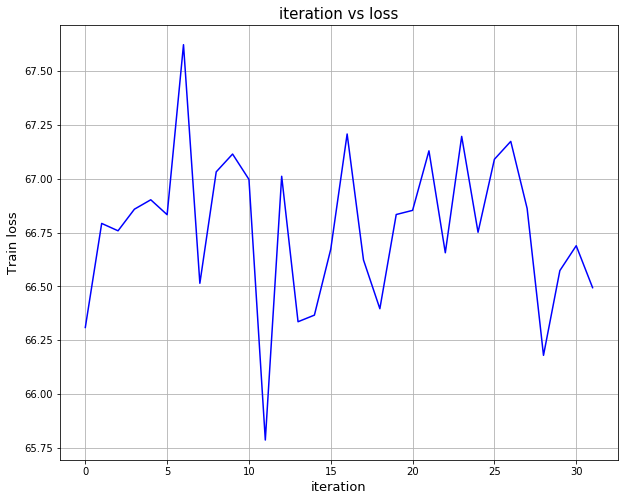

147/200 [=====================>........] - ETA: 298s - train loss: 66.7691 - dev loss: 67.3849

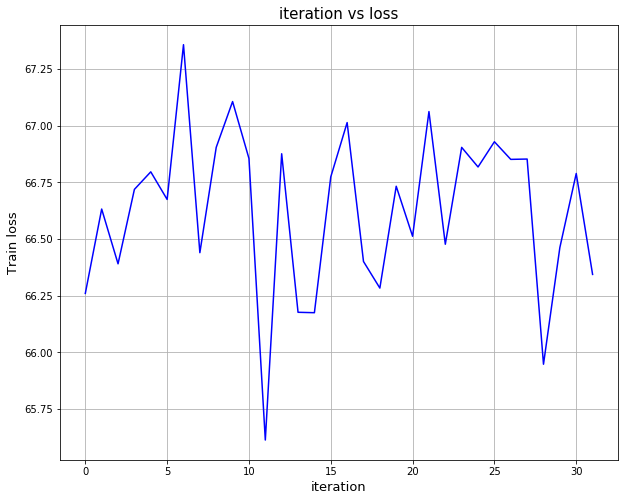

148/200 [=====================>........] - ETA: 292s - train loss: 66.6295 - dev loss: 67.2757

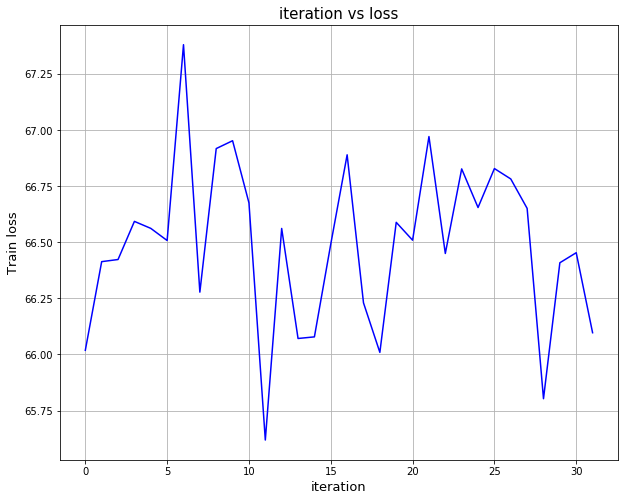

149/200 [=====================>........] - ETA: 287s - train loss: 66.4910 - dev loss: 67.1577

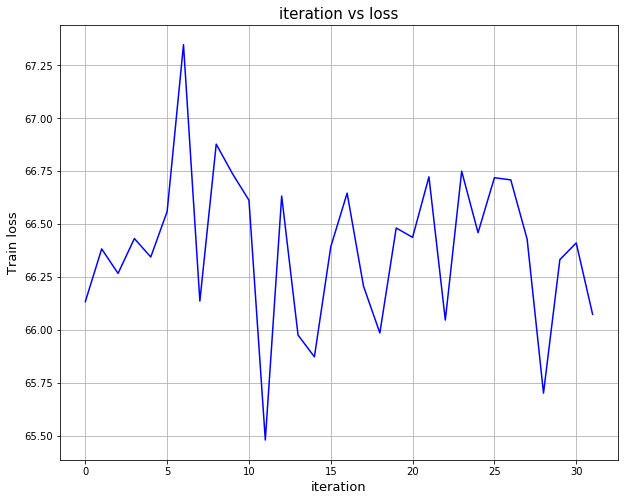

150/200 [=====================>........] - ETA: 281s - train loss: 66.3840 - dev loss: 67.0465

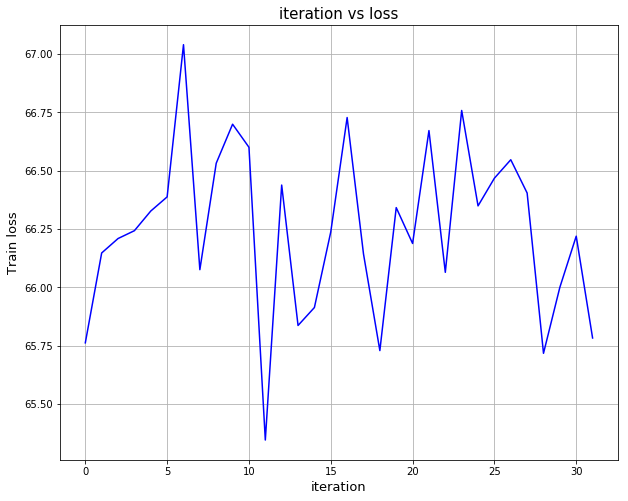

151/200 [=====================>........] - ETA: 275s - train loss: 66.2470 - dev loss: 66.9385

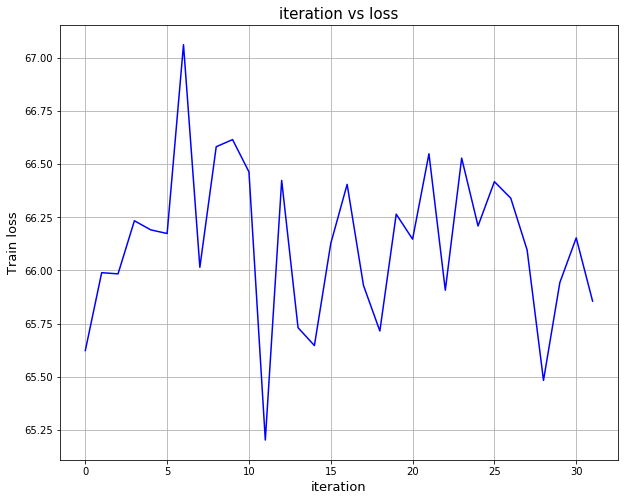

152/200 [=====================>........] - ETA: 269s - train loss: 66.1252 - dev loss: 66.8333

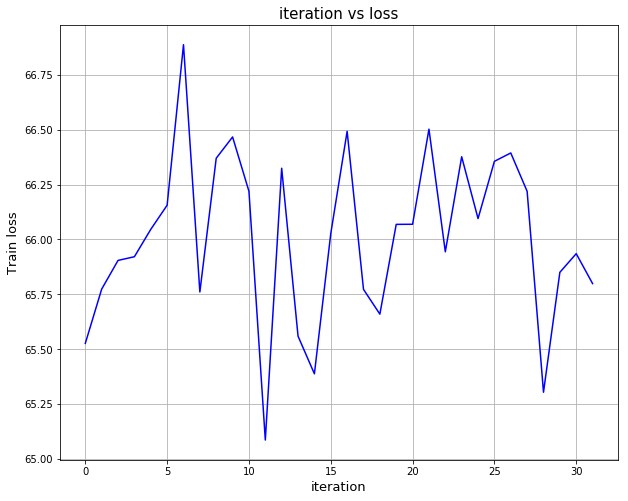

153/200 [=====================>........] - ETA: 264s - train loss: 66.0079 - dev loss: 66.7203

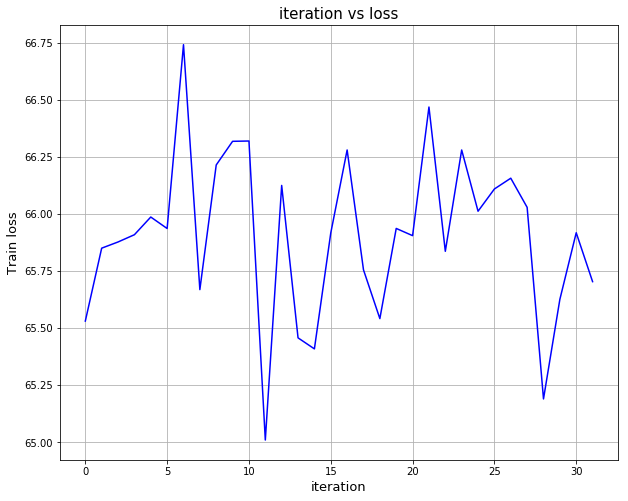

154/200 [======================>.......] - ETA: 258s - train loss: 65.9067 - dev loss: 66.6134

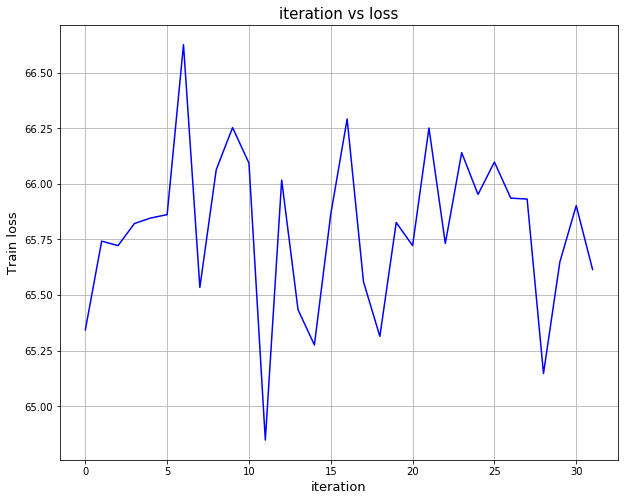

155/200 [======================>.......] - ETA: 252s - train loss: 65.7943 - dev loss: 66.5097

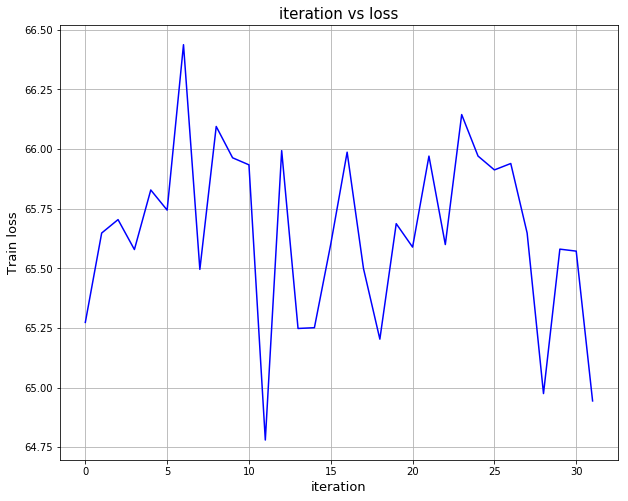

156/200 [======================>.......] - ETA: 247s - train loss: 65.6500 - dev loss: 66.4091

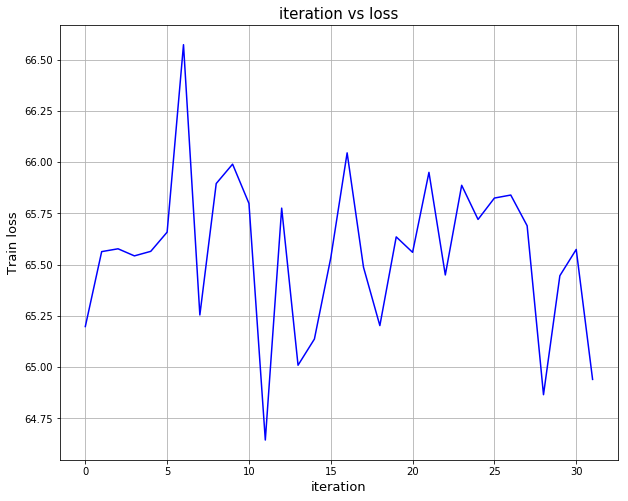

157/200 [======================>.......] - ETA: 241s - train loss: 65.5574 - dev loss: 66.3014

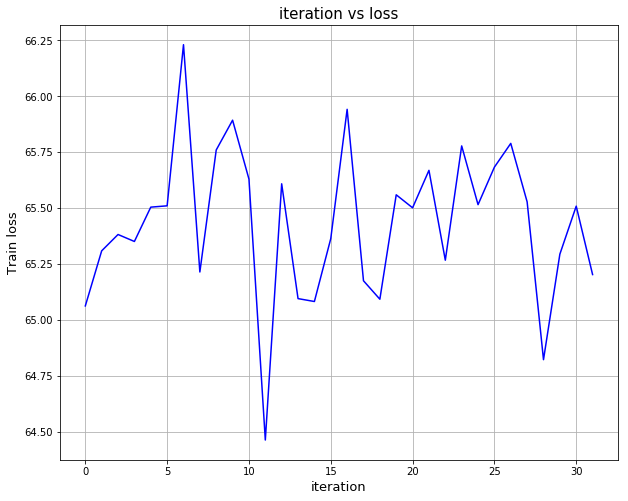

158/200 [======================>.......] - ETA: 235s - train loss: 65.4307 - dev loss: 66.2041

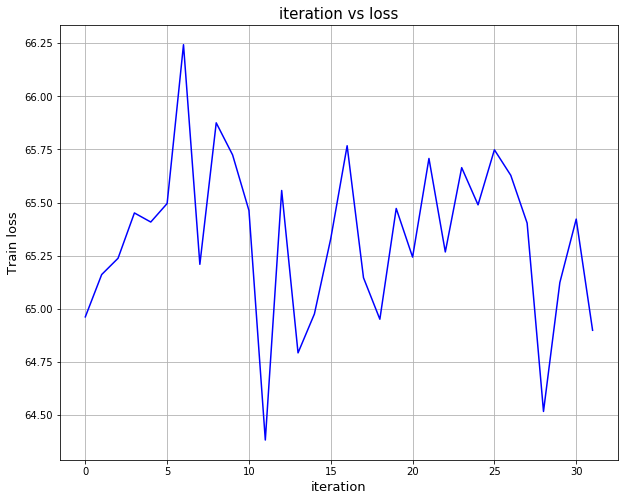

159/200 [======================>.......] - ETA: 230s - train loss: 65.3349 - dev loss: 66.1116

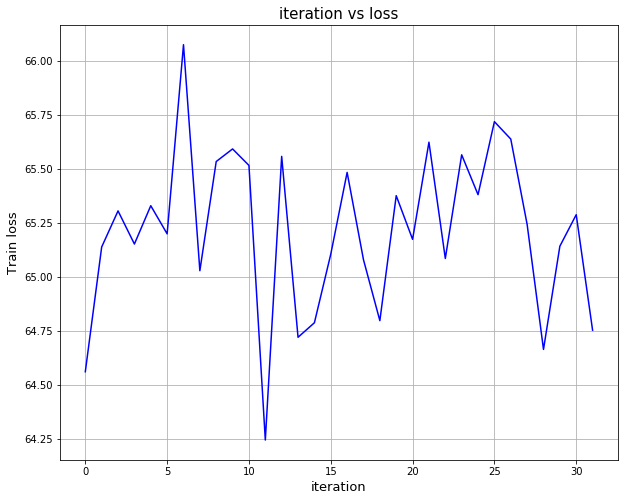

160/200 [=======================>......] - ETA: 224s - train loss: 65.2137 - dev loss: 66.0895

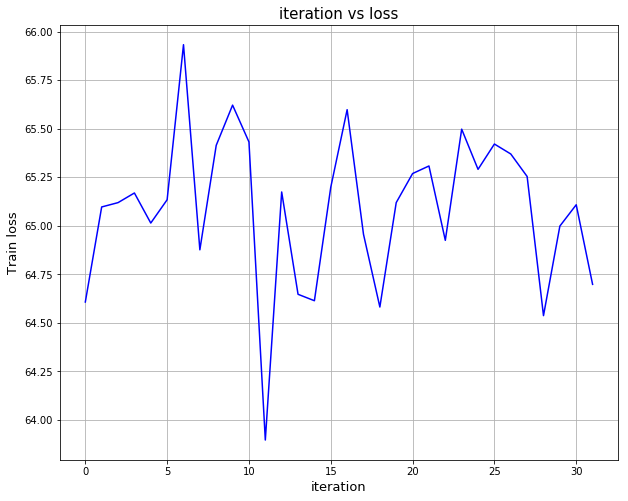

161/200 [=======================>......] - ETA: 218s - train loss: 65.0897 - dev loss: 66.1191

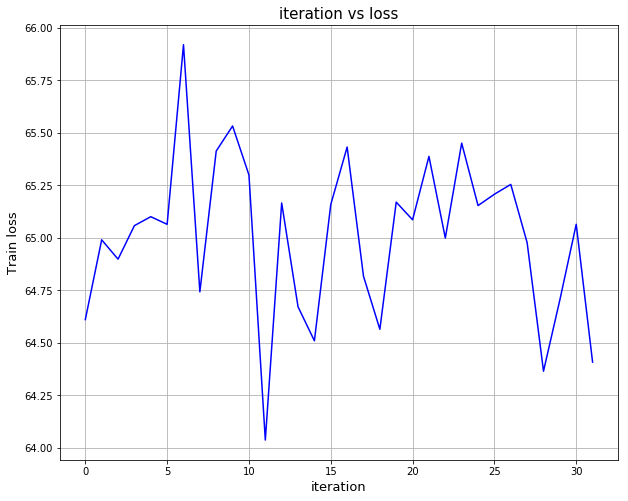

162/200 [=======================>......] - ETA: 213s - train loss: 65.0064 - dev loss: 66.0044

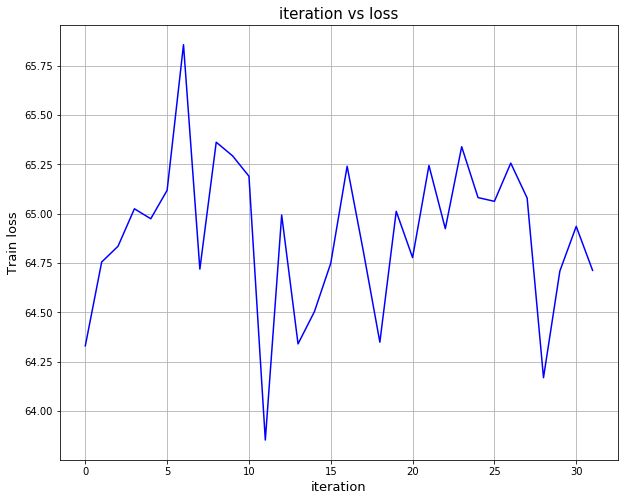

163/200 [=======================>......] - ETA: 207s - train loss: 64.8938 - dev loss: 66.0058

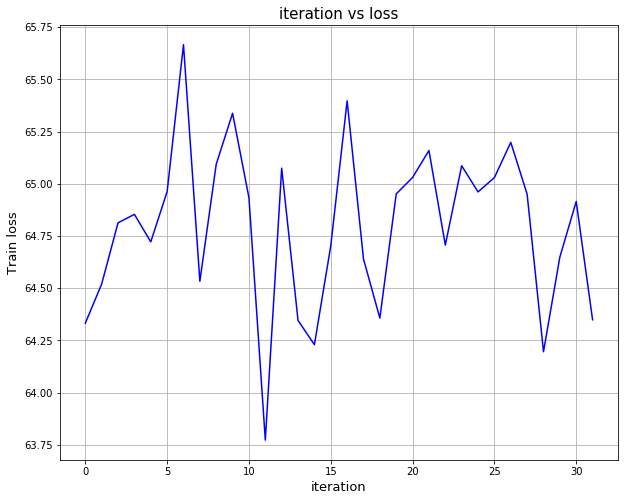

164/200 [=======================>......] - ETA: 201s - train loss: 64.7957 - dev loss: 65.9711

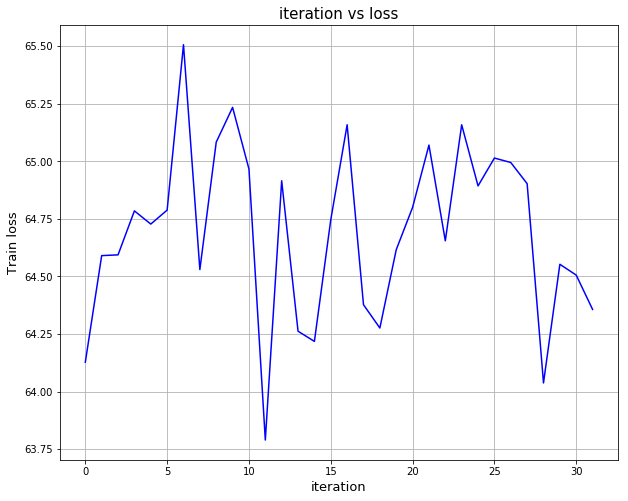

165/200 [=======================>......] - ETA: 196s - train loss: 64.6947 - dev loss: 66.0032

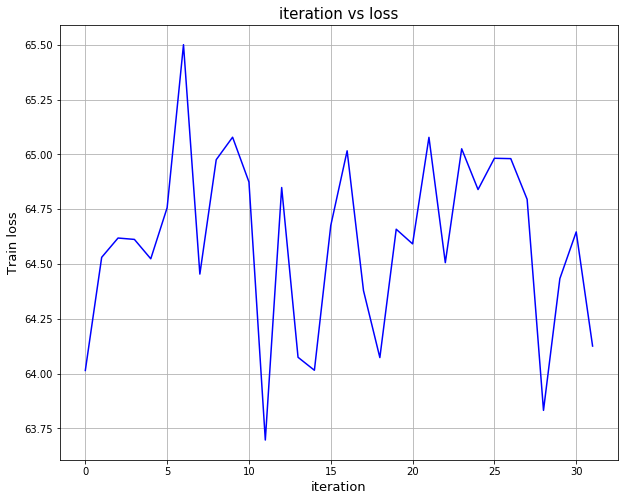

166/200 [=======================>......] - ETA: 190s - train loss: 64.6000 - dev loss: 65.9693

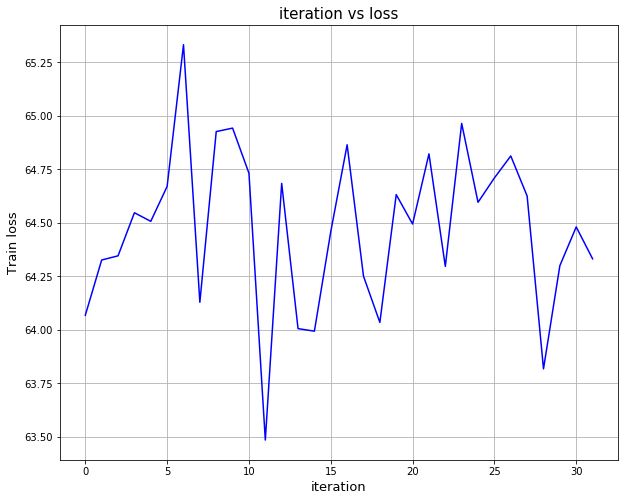

167/200 [========================>.....] - ETA: 184s - train loss: 64.4746 - dev loss: 65.8961

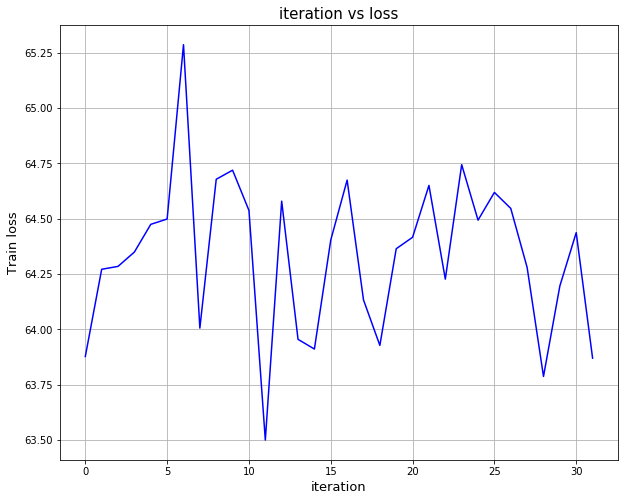

168/200 [========================>.....] - ETA: 179s - train loss: 64.3338 - dev loss: 65.8343

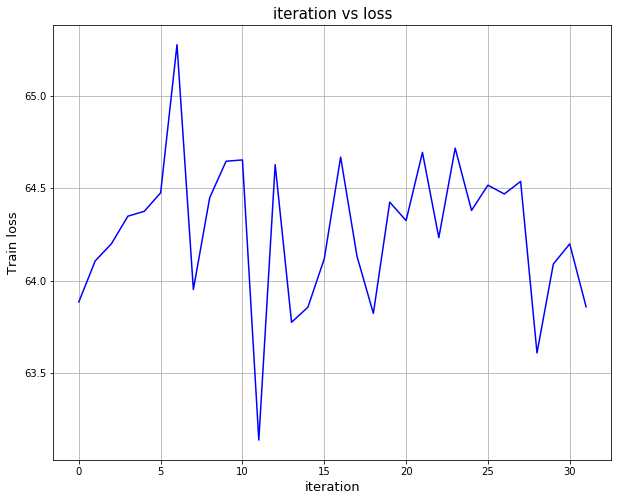

169/200 [========================>.....] - ETA: 173s - train loss: 64.2668 - dev loss: 65.7490

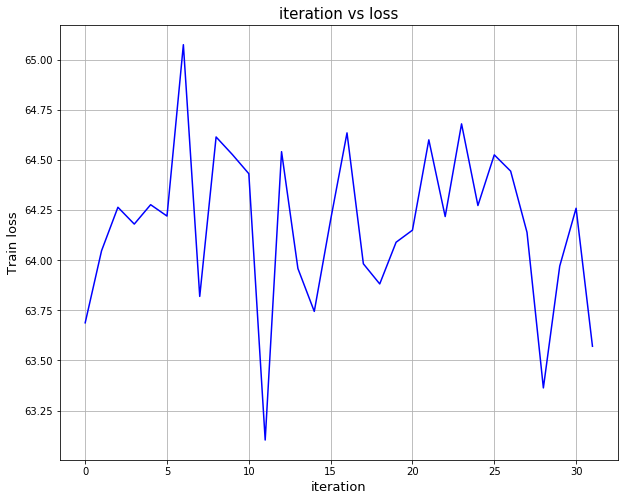

170/200 [========================>.....] - ETA: 167s - train loss: 64.1712 - dev loss: 65.7077

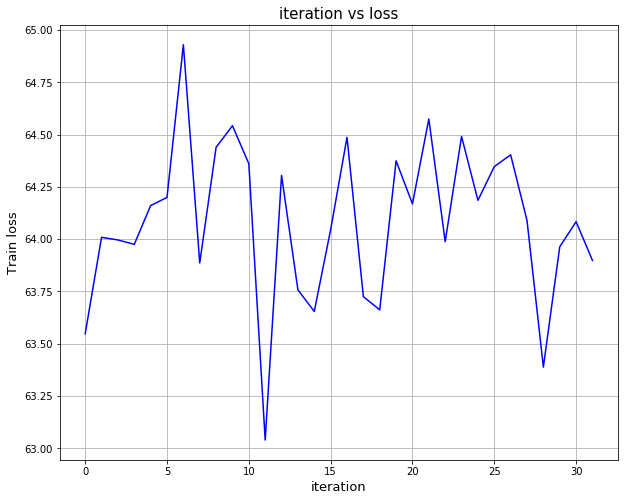

171/200 [========================>.....] - ETA: 162s - train loss: 64.0838 - dev loss: 65.6121

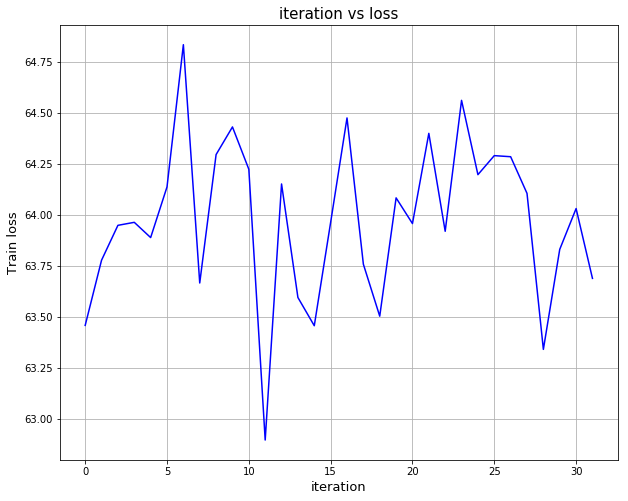

172/200 [========================>.....] - ETA: 156s - train loss: 63.9714 - dev loss: 65.5740

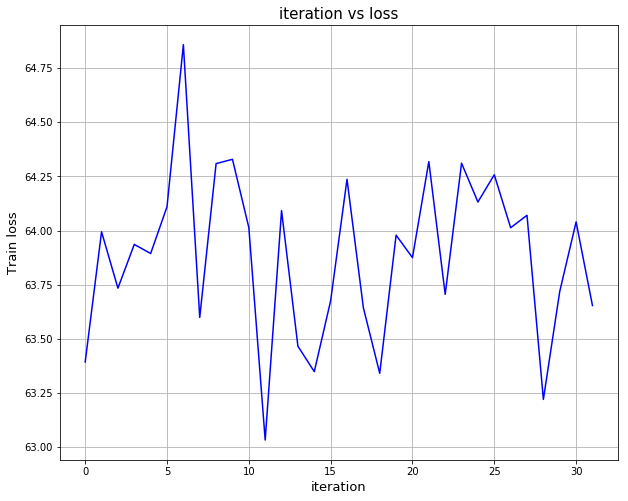

173/200 [========================>.....] - ETA: 150s - train loss: 63.8843 - dev loss: 65.4856

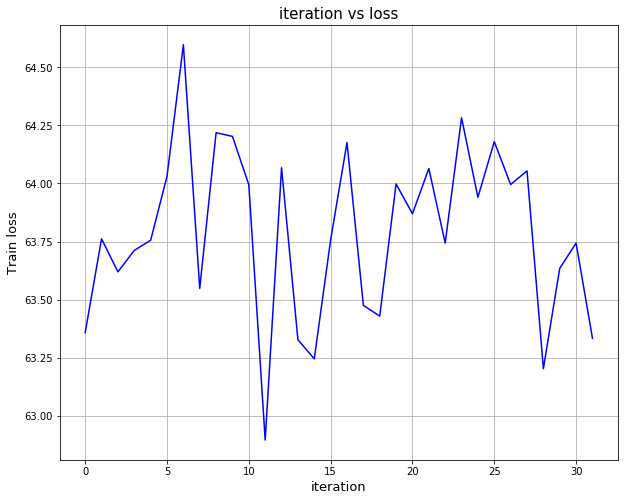

174/200 [=========================>....] - ETA: 145s - train loss: 63.7882 - dev loss: 65.4301

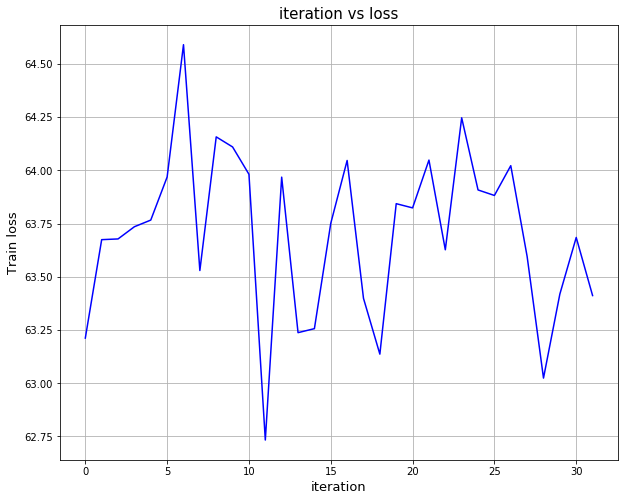

175/200 [=========================>....] - ETA: 139s - train loss: 63.7023 - dev loss: 65.3259

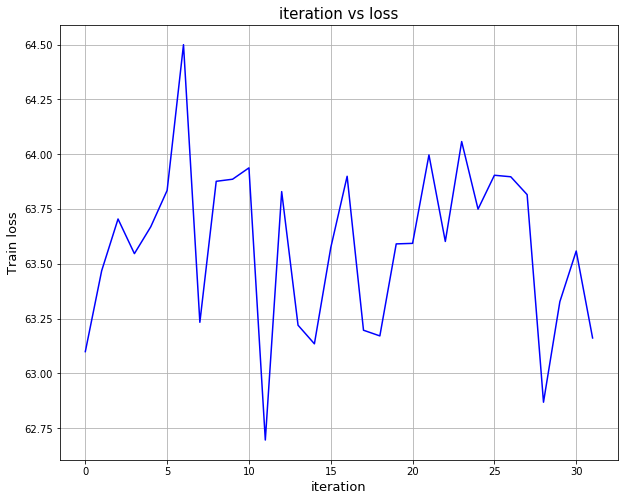

176/200 [=========================>....] - ETA: 134s - train loss: 63.5815 - dev loss: 65.2558

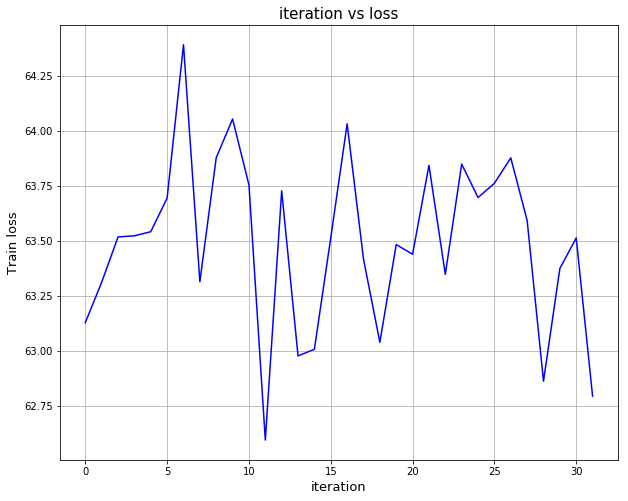

177/200 [=========================>....] - ETA: 128s - train loss: 63.4947 - dev loss: 65.2022

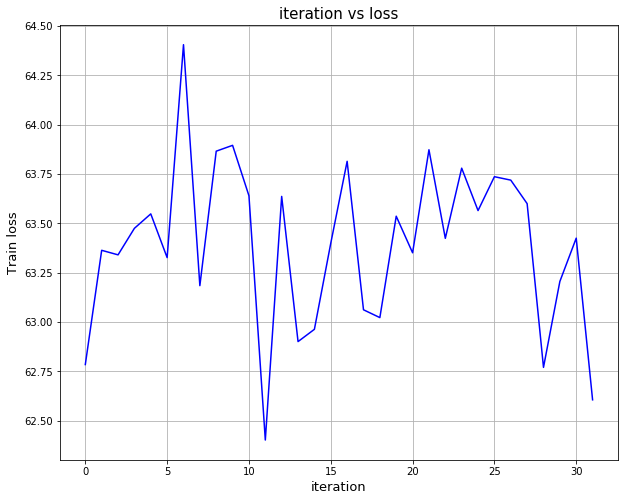

178/200 [=========================>....] - ETA: 122s - train loss: 63.3945 - dev loss: 65.1104

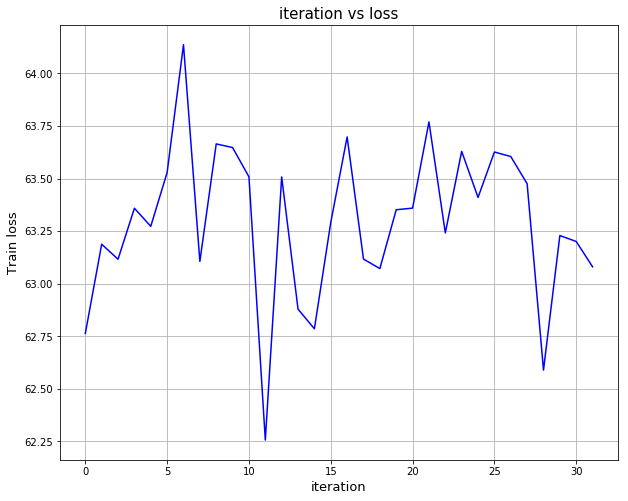

179/200 [=========================>....] - ETA: 117s - train loss: 63.2958 - dev loss: 65.0647

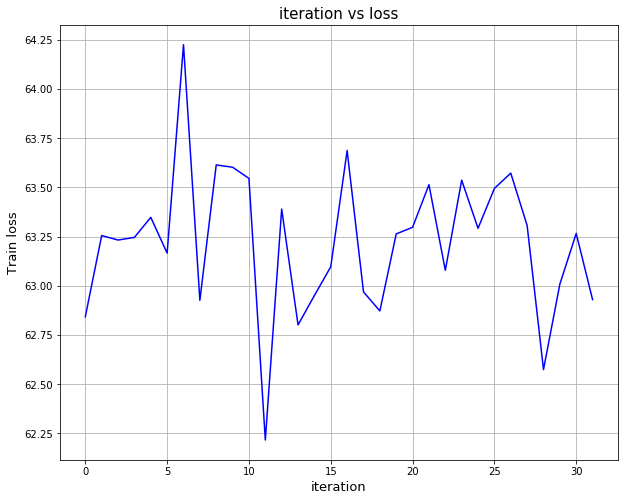

180/200 [==========================>...] - ETA: 111s - train loss: 63.2229 - dev loss: 64.9878

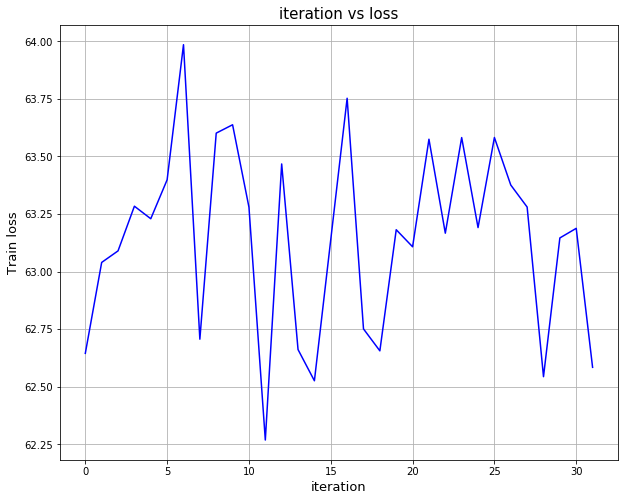

181/200 [==========================>...] - ETA: 106s - train loss: 63.1445 - dev loss: 64.9312

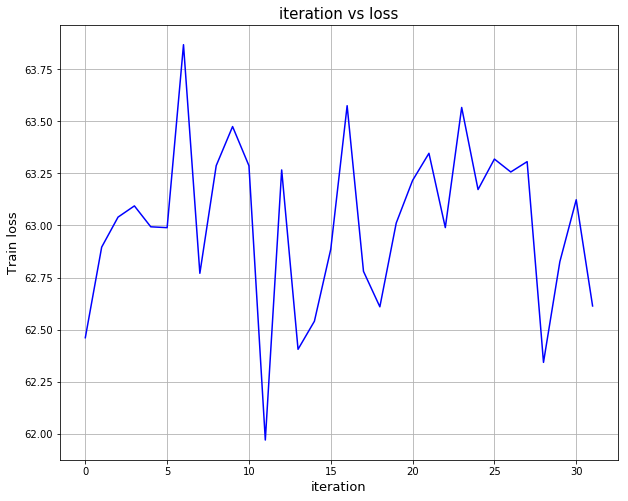

182/200 [==========================>...] - ETA: 100s - train loss: 63.0090 - dev loss: 64.8606

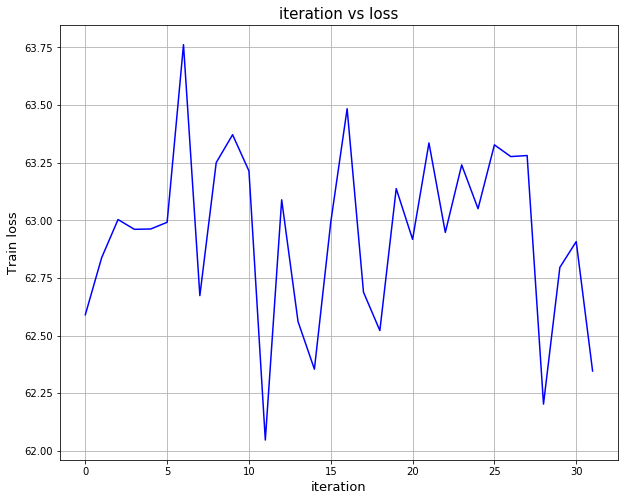

183/200 [==========================>...] - ETA: 94s - train loss: 62.9410 - dev loss: 64.7947 

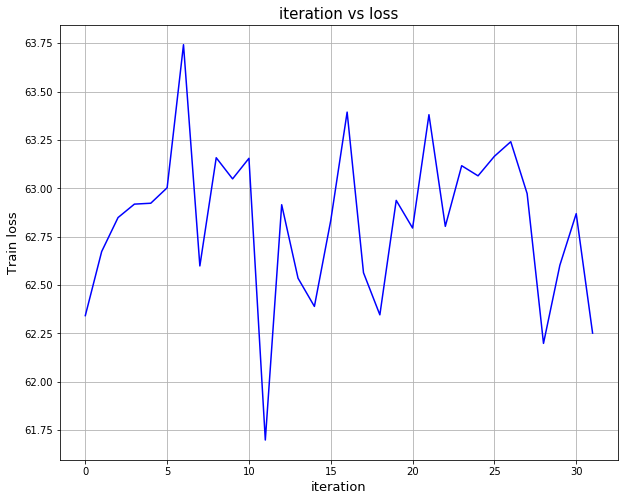

184/200 [==========================>...] - ETA: 89s - train loss: 62.8274 - dev loss: 64.7453

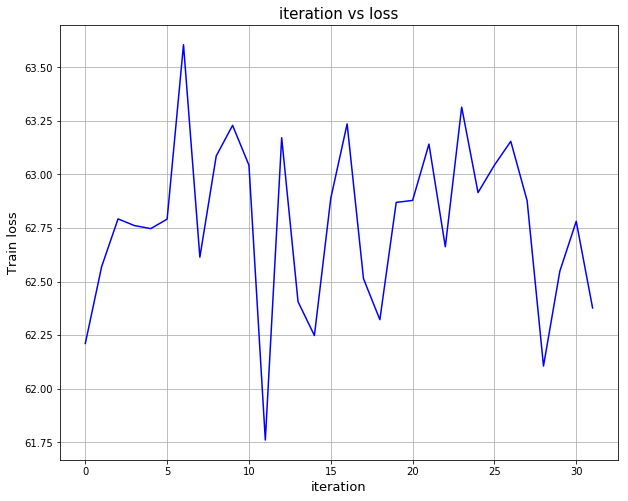

185/200 [==========================>...] - ETA: 83s - train loss: 62.7710 - dev loss: 64.6838

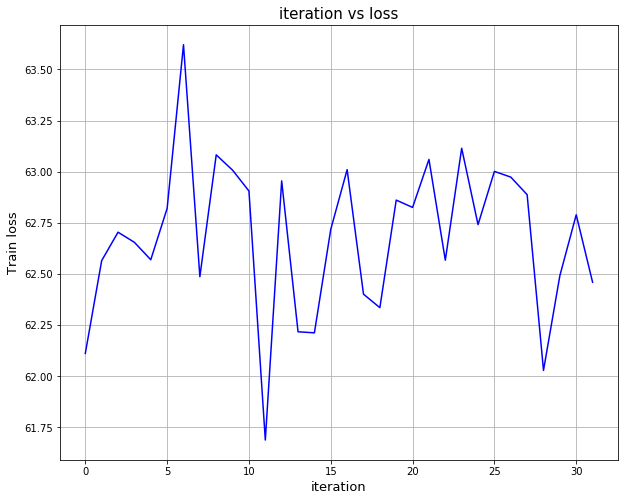

186/200 [==========================>...] - ETA: 78s - train loss: 62.6837 - dev loss: 64.6043

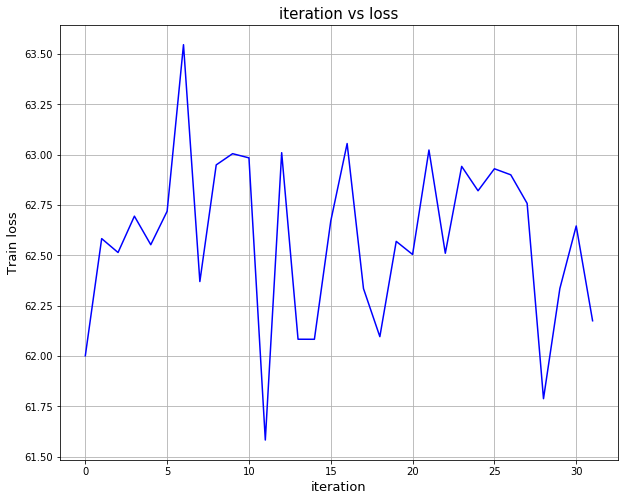

187/200 [===========================>..] - ETA: 72s - train loss: 62.5852 - dev loss: 64.5561

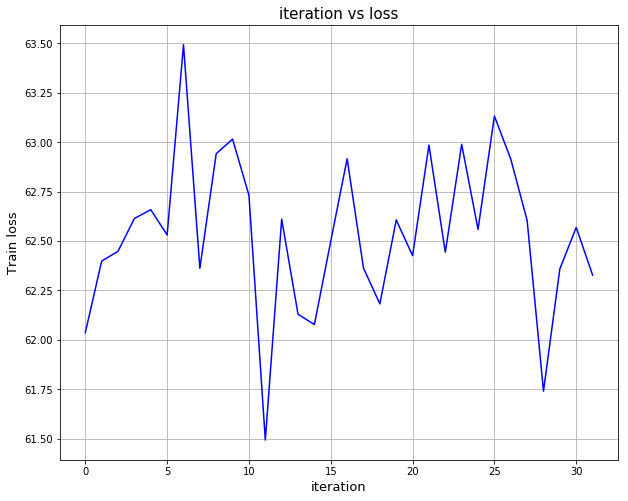

188/200 [===========================>..] - ETA: 66s - train loss: 62.5363 - dev loss: 64.5024

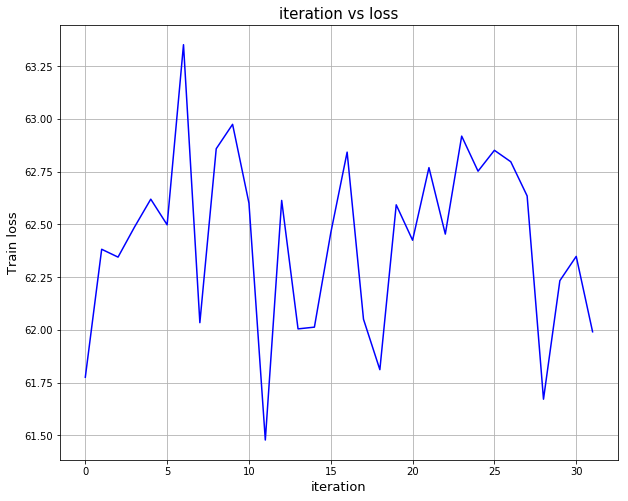

189/200 [===========================>..] - ETA: 61s - train loss: 62.4267 - dev loss: 64.4367

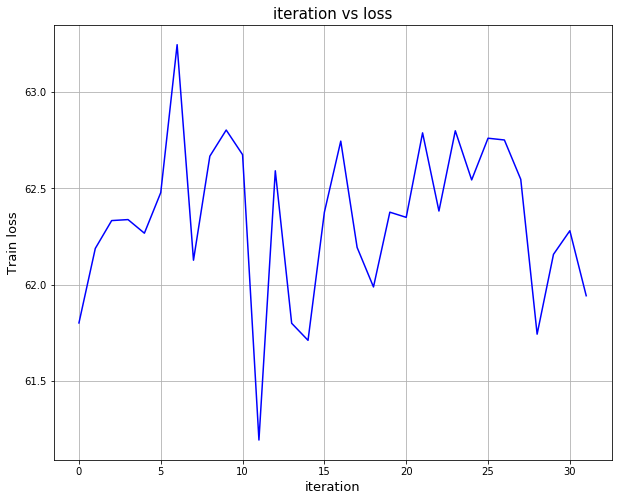

190/200 [===========================>..] - ETA: 55s - train loss: 62.3423 - dev loss: 64.3804

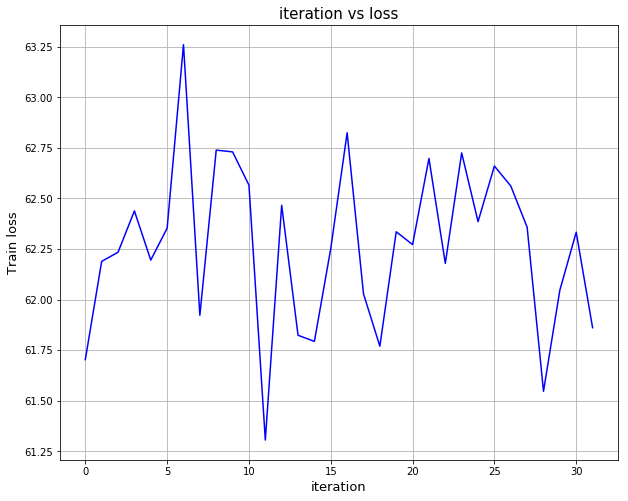

191/200 [===========================>..] - ETA: 50s - train loss: 62.2674 - dev loss: 64.3326

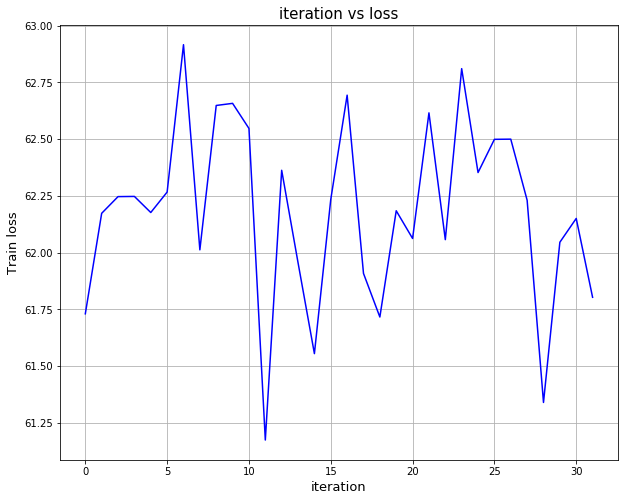

192/200 [===========================>..] - ETA: 44s - train loss: 62.1835 - dev loss: 64.3088

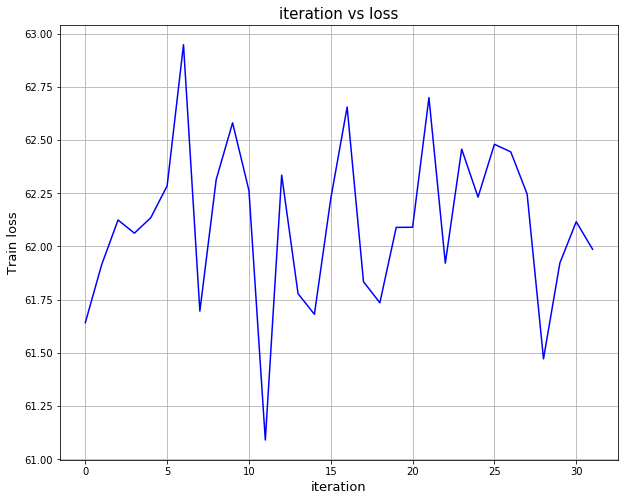

193/200 [===========================>..] - ETA: 38s - train loss: 62.1080 - dev loss: 64.2425

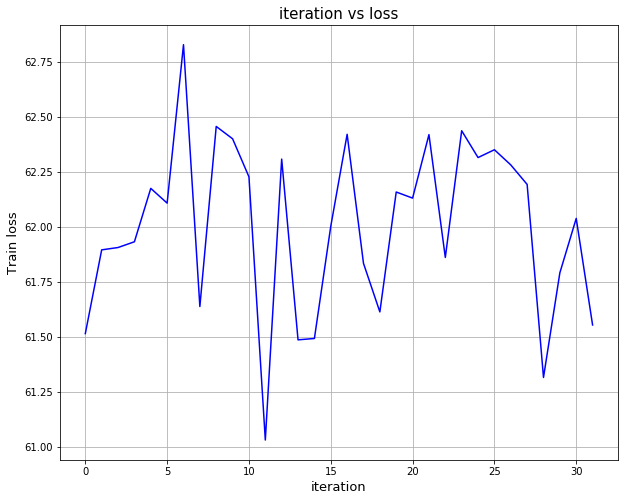

194/200 [============================>.] - ETA: 33s - train loss: 62.0031 - dev loss: 64.1750

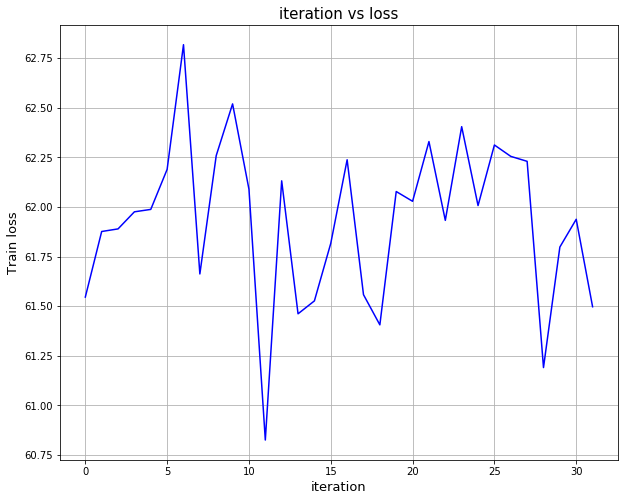

195/200 [============================>.] - ETA: 27s - train loss: 61.9302 - dev loss: 64.1603

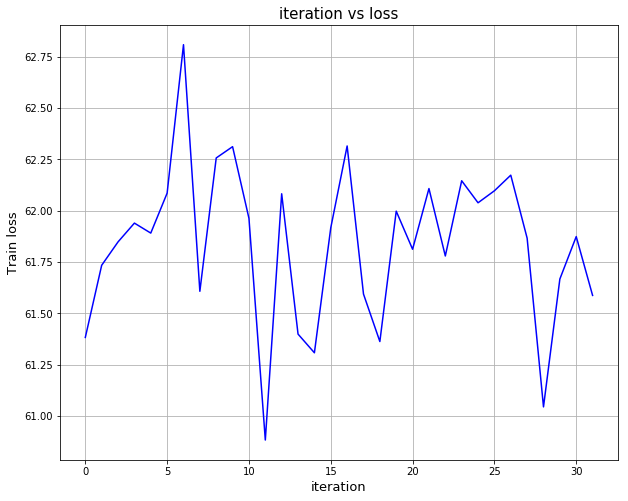

196/200 [============================>.] - ETA: 22s - train loss: 61.8395 - dev loss: 64.0889

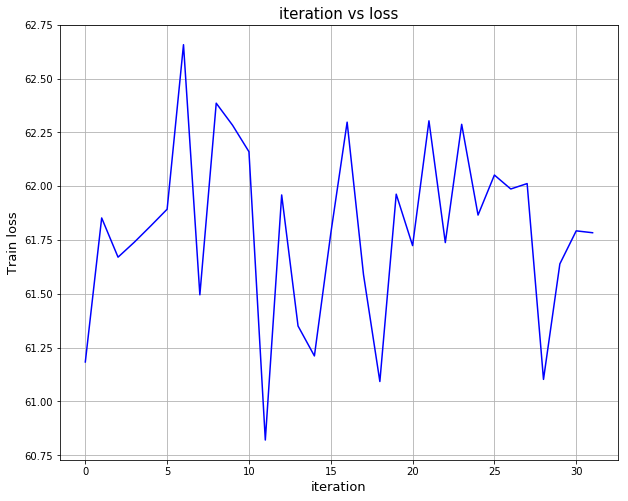

197/200 [============================>.] - ETA: 16s - train loss: 61.7964 - dev loss: 64.0674

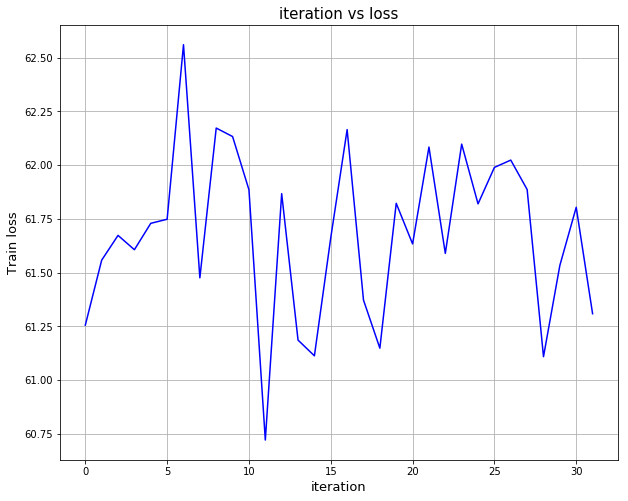

198/200 [============================>.] - ETA: 11s - train loss: 61.6787 - dev loss: 64.2607

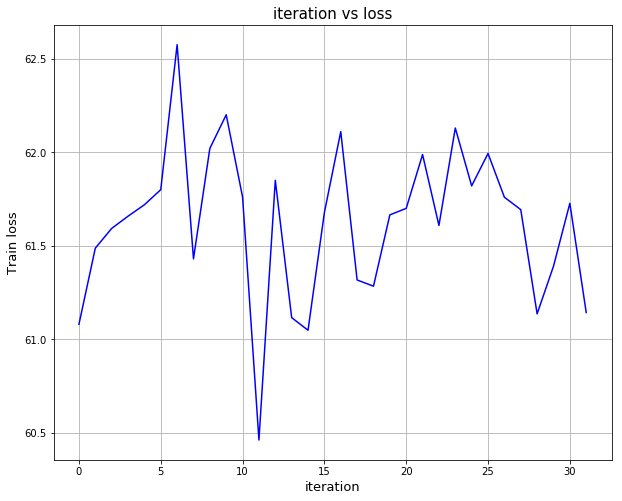

199/200 [============================>.] - ETA: 5s - train loss: 61.6237 - dev loss: 64.4047 

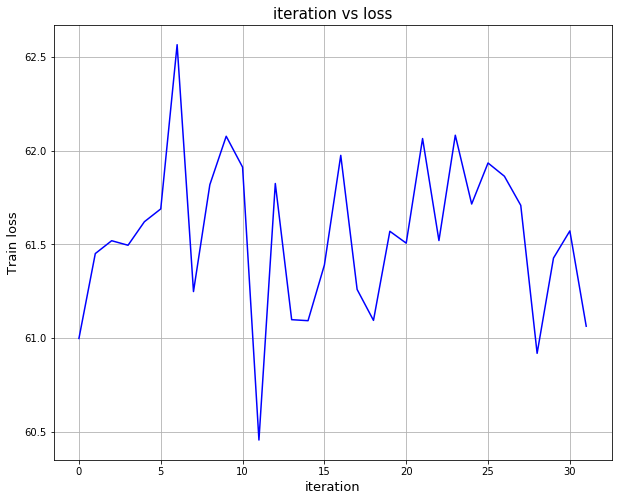

200/200 [==============================] - 1112s - train loss: 61.5479 - dev loss: 64.5161  


ValueError: Parent directory of /saved_model/COCO_lstm.ckpt doesn't exist, can't save.

In [7]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    pack = model.train(sess, (input_frames_train, captions_train), verbose = True)
    save_path = saver.save(sess, "/saved_model/COCO_lstm.ckpt")
    print("Model saved in file: %s" % save_path)
val_loss, tr_loss, tr_pred, val_pred, train_id, val_id = pack

In [8]:
val_loss, tr_loss, tr_pred, val_pred, train_id, val_id = pack
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/CoCo_caption_learning_curve.png')

NameError: name 'tr_loss' is not defined

In [ ]:
# check captions
batch_size = batch_size
# sample = tr_pred[idx] # training
# # sample = val_pred[idx] # validation 
# words = []
# embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = train_id[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2word[i]
        true = index2word[cap[idx]]
        if word not in ['<START>', '<NULL>', '<END>']:
            words.append(word)
        if true not in ['<START>', '<NULL>', '<END>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

# Look At Data

In [ ]:


url = train_urls[vid]
plt.imshow(image_from_url(url))
plt.axis('off')
caption_str = decode_captions(caption, data['idx_to_word'])
plt.title(caption_str)
plt.show()

# # Sample a minibatch and show the images and captions
# batch_size = 1
# captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
# for i, (caption, url) in enumerate(zip(captions, urls)):
#     plt.imshow(image_from_url(url))
#     plt.axis('off')
#     caption_str = decode_captions(caption, data['idx_to_word'])
#     plt.title(caption_str)
#     plt.show()